Changed ignore iters, lr ranges, computation of best metric and using **average of last 10 runs** metric to store new model

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import h5py

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import os
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.modules.module import Module

# sklearn functions
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, KFold

# load functions from nitorch
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity
from nitorch.utils import count_parameters

In [5]:
import random
from models_ms import ModelA, ModelB
from hyperparameter_options import params_baseline_2 as hyperparams

In [6]:
torch.__version__

'1.0.0'

In [7]:
gpu = 2
multi_gpus = [2, 3]
zero_one_normalize = False
zoom = 0.525

dtype = np.float64

In [8]:
# load mask
mask = None

In [9]:
train_h5 = h5py.File('/ritter/share/data/MS/CIS/train_dataset.h5', 'r')
holdout_h5 = h5py.File('/ritter/share/data/MS/CIS/holdout_dataset.h5', 'r')

In [10]:
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']
X_train, y_train = train_h5['X'], train_h5['y']

In [11]:
X = np.concatenate([X_train, X_holdout])
y = np.concatenate([y_train, y_holdout])

In [12]:
# define dataset

In [13]:
class MSDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None, mask=None, z_factor=zoom, dtype=np.float32):
        self.X = np.copy(X)
        self.y = np.copy(y)
        self.transform = transform
        self.target_transform = target_transform
        self.mask = mask
        self.z_factor = zoom
        self.dtype = dtype
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx] >= 0.5
        label = torch.FloatTensor([label])
        
        # normalize by max
        image /= np.max(image)
        
        if self.transform:
            image = self.transform(image)
            
        sample = {"image" : image,
                 "label" : label}
        return sample

# Define the classifier

In [14]:
"""if multi_gpus is None:
    net = SixtyFourNet().cuda(gpu)
else:
    net = torch.nn.DataParallel(SixtyFourNet(), device_ids=multi_gpus).cuda(gpu)"""

'if multi_gpus is None:\n    net = SixtyFourNet().cuda(gpu)\nelse:\n    net = torch.nn.DataParallel(SixtyFourNet(), device_ids=multi_gpus).cuda(gpu)'

In [15]:
def pick_model(name):
    if name == "ModelA":
        net = ModelA()
    elif name == "ModelB":
        net = ModelB()
    elif name == "ModelAPIF":
        net = ModelAPIF()
    elif name == "ModelBPIF":
        net = ModelBPIF()
    return net

def update_outer_scores(outer_fold_best, report, retain_metric, selected_hyperparams, inner_fold_idx):
    outer_fold_best["final_acc"] = report["val_metrics"][retain_metric][-1]
    outer_fold_best["best_acc"] = np.max(report["val_metrics"][retain_metric][ignore_epochs:])
    outer_fold_best["final_iter"] = len(report["val_metrics"][retain_metric])
    outer_fold_best["best_iter"] = outer_fold_best["final_iter"] - np.argmax(np.flip(np.copy(report["val_metrics"][retain_metric])))
    outer_fold_best["params"] = selected_hyperparams
    outer_fold_best["inner_fold_idx"] = inner_fold_idx
    return outer_fold_best

# Training

In [16]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=None,
    num_epochs=35,
    retain_metric=None
):      

    fold_metric = []
    best_metric = []
    models = []
    fold = 0
    initial_prepend = None
    random_states = np.arange(20, 30) # will be used again to split in testing phase
    #random_states = [20]
    for outer_fold, r in enumerate(random_states):
        print("###### Starting outer fold {}".format(outer_fold))
        # load new random data split each outer fold
        # separate new test set
        X_train, _, y_train, _ = train_test_split(data[0], data[1], test_size=0.15, random_state=r)
        if zero_one_normalize:
            intensity = IntensityRescale()
            ms_data_train = MSDataset(X_train, y_train, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
        else:
            ms_data_train = MSDataset(X_train, y_train, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)
        
        all_indices = list(range(len(X_train)))
        train_idx, val_idx = train_test_split(all_indices, test_size=0.1, random_state=12)
        print(len(train_idx))
        print(len(val_idx))
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)
        print("Shuffled the data..")
        
        outer_fold_best = {
            "final_acc" : 0,
            "best_acc" : 0,
            "final_iter" : 0,
            "best_iter" : 0,
            "params" : {},
            "inner_fold_idx" : 0
        }

        for inner_fold in range(5):
            print("###### Starting inner fold {}".format(inner_fold))
            # sample randomly from the hyperparameter options each inner fold
            b = random.choice(hyperparams["batch_size"])
            patience = random.choice(hyperparams["patience"]["small"])
            lr = random.choice(hyperparams["lr"])
            # force each model architecture to occur twice
            if inner_fold < 2:
                model_name = "ModelA"
            elif inner_fold < 4:
                model_name = "ModelB"
            else:
                # only choose model randomly in the last run
                model_name = random.choice(hyperparams["model"])
            

            selected_hyperparams = {
                "model" : model_name,
                "batch_size" : b,
                "patience" : patience,
                "lr" : lr
                }
            print(selected_hyperparams)

            # load model
            if multi_gpus is None:
                net = pick_model(model_name).cuda(gpu)
            else:
                net = torch.nn.DataParallel(pick_model(model_name), device_ids=multi_gpus).cuda(gpu)
            print("Trainable model parameters: {}".format(count_parameters(net)))

            callbacks = [EarlyStopping(patience=patience, ignore_before=ignore_epochs, retain_metric="loss", mode='min'),
                         ModelCheckpoint(path=output_dir,
                                         prepend="outer_{}_inner_{}".format(outer_fold, inner_fold),
                                         store_best=True,
                                         ignore_before=ignore_epochs,
                                         retain_metric=retain_metric)]
            # add current fold number to model checkpoint path
            if callbacks is not None:
                for idx, callback in enumerate(callbacks):
                    if isinstance(callback, ModelCheckpoint):
                        if initial_prepend is None:
                            initial_prepend = callbacks[idx].prepend
                        callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
                        initial_prepend = None
            fold += 1

            # set optimizer
            wd = 1e-4
            criterion = nn.BCEWithLogitsLoss().cuda(gpu)
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

            # create dataloaders for specific inner folds (due to batch size)
            train_loader = DataLoader(
                ms_data_train, batch_size=b, num_workers=4, sampler=train_sampler
            )
            val_loader = DataLoader(
                ms_data_train, batch_size=1, num_workers=1, sampler=val_sampler
            )

            trainer = Trainer(
                net,
                criterion,
                optimizer,
                metrics=metrics,
                callbacks=callbacks,
                device=gpu
            )
            # train model and store results
            net, report = trainer.train_model(
                train_loader,
                val_loader,
                num_epochs=num_epochs,
                show_train_steps=5,
                show_validation_epochs=1,
            )
            # append validation score of the retain metric
            if isinstance(retain_metric, str):
                # use the average of the last 10 epochs
                best_val = np.mean(report["val_metrics"][retain_metric][-10:])
                fold_metric.append(report["val_metrics"][retain_metric][-1])
                best_metric.append(best_val)
                # replace best model for this outer_fold in case of improvement
                #if report["val_metrics"][retain_metric][-1] > outer_fold_best["final_acc"]:
                if report["val_metrics"][retain_metric][-1] > outer_fold_best["final_acc"]:
                    update_outer_scores(outer_fold_best, report, retain_metric, selected_hyperparams, inner_fold)
            else:
                # use the average of the last 10 epochs
                best_val = np.mean(report["val_metrics"][retain_metric.__name__][-10:])
                fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])
                best_metric.append(best_val)
                # replace best model for this outer_fold in case of improvement
                #if report["val_metrics"][retain_metric.__name__][-1] > outer_fold_best["final_acc"]:
                if best_val > outer_fold_best["final_acc"]:
                    update_outer_scores(outer_fold_best, report, retain_metric.__name__, selected_hyperparams, inner_fold)

            models.append(net)        
            print("Finished inner fold.")

            # visualize result
            trainer.visualize_training(report, metrics)
            trainer.evaluate_model(val_loader, gpu)
        print("Finished outer fold.")
        print(outer_fold_best)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    print("Best accuracies mean: {} All :{}".format(np.mean(best_metric), best_metric))
    return fold_metric, models

In [17]:
num_epochs = 200
min_iters = 30
ignore_epochs = 40
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy]

In [18]:
r = 2

In [19]:
augmentations = [] # augmentations seem to decrease validation accuracy

output_dir = "/ritter/share/projects/Methods/Eitel_local_filter/experiments_submission/models/MS/full_set/10xrandom_splits/baseline_r3/"


###### Starting outer fold 0
111
13
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 468521
[0,     5] loss: 0.69425
Time elapsed: 0h:0m:6s
train accuracy_score: 48.65 %
train balanced_accuracy: 50.00 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.698175
[1,     5] loss: 0.69553
Time elapsed: 0h:0m:8s
train accuracy_score: 48.65 %
train balanced_accuracy: 49.12 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.689581
[2,     5] loss: 0.68751
Time elapsed: 0h:0m:11s
train accuracy_score: 53.15 %
train balanced_accuracy: 52.53 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690933
[3,     5] loss: 0.68603
Time elapsed: 0h:0m:13s
train accuracy_score: 53.15 %
train balanced_accuracy: 53.27 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694201
[4,     5] loss: 0.69800
Time elapsed: 0h:0m:15s
train 

Time elapsed: 0h:1m:45s
train accuracy_score: 57.66 %
train balanced_accuracy: 57.50 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.655695
[43,     5] loss: 0.67724
Time elapsed: 0h:1m:47s
train accuracy_score: 63.06 %
train balanced_accuracy: 62.67 %
val accuracy_score: 53.85 %
val balanced_accuracy: 53.57 %
Val loss: 0.655251
[44,     5] loss: 0.61102
Time elapsed: 0h:1m:50s
train accuracy_score: 66.67 %
train balanced_accuracy: 66.57 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.654910
[45,     5] loss: 0.63384
Time elapsed: 0h:1m:52s
train accuracy_score: 65.77 %
train balanced_accuracy: 65.64 %
val accuracy_score: 53.85 %
val balanced_accuracy: 53.57 %
Val loss: 0.646837
[46,     5] loss: 0.60841
Time elapsed: 0h:1m:55s
train accuracy_score: 61.26 %
train balanced_accuracy: 61.21 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.646789
[47,     5] loss: 0.54709
Time elapsed: 0h:1m:57s
train accuracy_score:

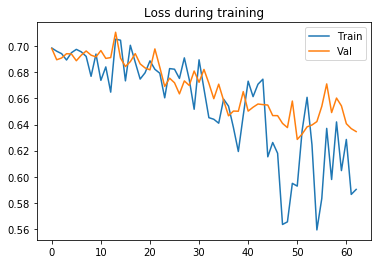

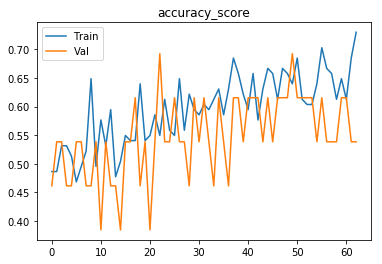

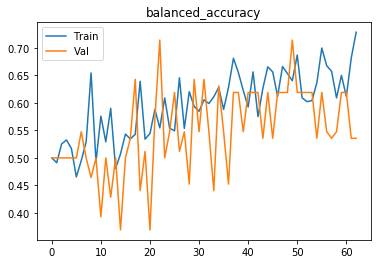

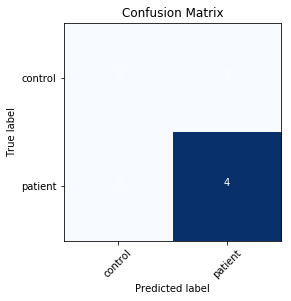

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 468521
[0,     5] loss: 0.69290
[0,    10] loss: 0.69073
[0,    15] loss: 0.69566
Time elapsed: 0h:0m:2s
train accuracy_score: 51.35 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.689151
[1,     5] loss: 0.69997
[1,    10] loss: 0.69185
[1,    15] loss: 0.69029
Time elapsed: 0h:0m:4s
train accuracy_score: 51.35 %
train balanced_accuracy: 50.29 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.689771
[2,     5] loss: 0.70928
[2,    10] loss: 0.68574
[2,    15] loss: 0.69823
Time elapsed: 0h:0m:7s
train accuracy_score: 45.95 %
train balanced_accuracy: 45.08 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.688378
[3,     5] loss: 0.69771
[3,    10] loss: 0.68551
[3,    15] loss: 0.68133
Time elapsed: 0h:0m:9s
train accuracy_score: 54.95 %
train balanced_accuracy: 

val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.564127
[34,     5] loss: 0.54256
[34,    10] loss: 0.57728
[34,    15] loss: 0.60431
Time elapsed: 0h:1m:29s
train accuracy_score: 71.17 %
train balanced_accuracy: 71.00 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.561519
[35,     5] loss: 0.53352
[35,    10] loss: 0.54862
[35,    15] loss: 0.59958
Time elapsed: 0h:1m:31s
train accuracy_score: 71.17 %
train balanced_accuracy: 71.10 %
val accuracy_score: 69.23 %
val balanced_accuracy: 71.43 %
Val loss: 0.587418
[36,     5] loss: 0.62434
[36,    10] loss: 0.47068
[36,    15] loss: 0.64044
Time elapsed: 0h:1m:34s
train accuracy_score: 68.47 %
train balanced_accuracy: 68.86 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.563223
[37,     5] loss: 0.47005
[37,    10] loss: 0.50573
[37,    15] loss: 0.80873
Time elapsed: 0h:1m:37s
train accuracy_score: 67.57 %
train balanced_accuracy: 67.40 %
val accuracy_score: 69.23 %


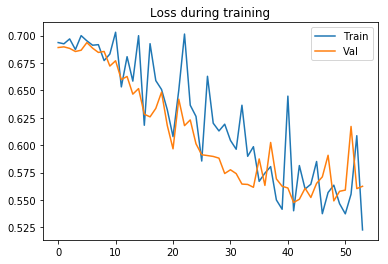

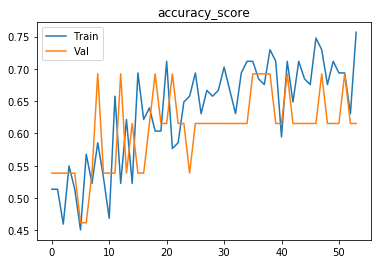

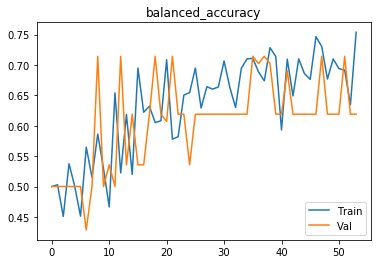

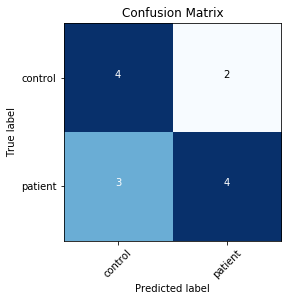

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 621961
[0,     5] loss: 0.69310
Time elapsed: 0h:0m:2s
train accuracy_score: 55.86 %
train balanced_accuracy: 55.31 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691357
[1,     5] loss: 0.69714
Time elapsed: 0h:0m:5s
train accuracy_score: 46.85 %
train balanced_accuracy: 46.83 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.689255
[2,     5] loss: 0.69695
Time elapsed: 0h:0m:8s
train accuracy_score: 46.85 %
train balanced_accuracy: 45.71 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.687915
[3,     5] loss: 0.69025
Time elapsed: 0h:0m:11s
train accuracy_score: 47.75 %
train balanced_accuracy: 47.95 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.695840
[4,     5] loss: 0.69189
Time elapsed: 0h:0m:15s
train accuracy_score: 55.86 %
train balanced_accuracy: 56.29 %


val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.530127
[43,     5] loss: 0.62745
Time elapsed: 0h:2m:16s
train accuracy_score: 66.67 %
train balanced_accuracy: 67.01 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.556780
[44,     5] loss: 0.58106
Time elapsed: 0h:2m:20s
train accuracy_score: 68.47 %
train balanced_accuracy: 68.47 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.535581
[45,     5] loss: 0.60398
Time elapsed: 0h:2m:23s
train accuracy_score: 71.17 %
train balanced_accuracy: 71.15 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.561729
[46,     5] loss: 0.53014
Time elapsed: 0h:2m:26s
train accuracy_score: 72.97 %
train balanced_accuracy: 73.00 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.547229
[47,     5] loss: 0.48152
Time elapsed: 0h:2m:29s
train accuracy_score: 70.27 %
train balanced_accuracy: 70.32 %
val accuracy_score: 69.23 %
val balanced_accu

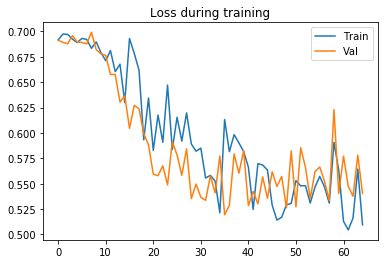

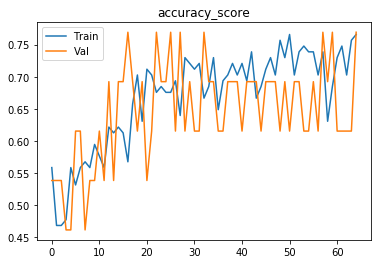

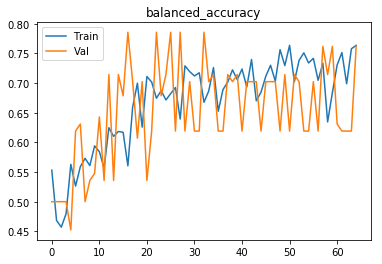

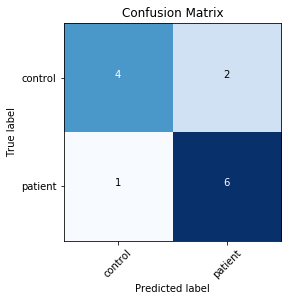

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 621961
[0,     5] loss: 0.70293
[0,    10] loss: 0.69827
[0,    15] loss: 0.68965
Time elapsed: 0h:0m:3s
train accuracy_score: 52.25 %
train balanced_accuracy: 52.73 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.689544
[1,     5] loss: 0.67155
[1,    10] loss: 0.72461
[1,    15] loss: 0.71261
Time elapsed: 0h:0m:6s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.93 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.687537
[2,     5] loss: 0.69500
[2,    10] loss: 0.70076
[2,    15] loss: 0.69648
Time elapsed: 0h:0m:9s
train accuracy_score: 44.14 %
train balanced_accuracy: 44.98 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.692601
[3,     5] loss: 0.69168
[3,    10] loss: 0.70948
[3,    15] loss: 0.69544
Time elapsed: 0h:0m:13s
train accuracy_score: 40.54 %
train balanced_accuracy:

val accuracy_score: 69.23 %
val balanced_accuracy: 71.43 %
Val loss: 0.613951
[34,     5] loss: 0.62933
[34,    10] loss: 0.58940
[34,    15] loss: 0.50343
Time elapsed: 0h:2m:0s
train accuracy_score: 66.67 %
train balanced_accuracy: 66.91 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.529168
[35,     5] loss: 0.65244
[35,    10] loss: 0.60494
[35,    15] loss: 0.54974
Time elapsed: 0h:2m:3s
train accuracy_score: 70.27 %
train balanced_accuracy: 70.42 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.517352
[36,     5] loss: 0.52805
[36,    10] loss: 0.47717
[36,    15] loss: 0.71411
Time elapsed: 0h:2m:7s
train accuracy_score: 67.57 %
train balanced_accuracy: 67.06 %
val accuracy_score: 61.54 %
val balanced_accuracy: 64.29 %
Val loss: 0.702487
[37,     5] loss: 0.77069
[37,    10] loss: 0.61028
[37,    15] loss: 0.59620
Time elapsed: 0h:2m:10s
train accuracy_score: 67.57 %
train balanced_accuracy: 68.08 %
val accuracy_score: 61.54 %
val

val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.484479
[68,     5] loss: 0.32135
[68,    10] loss: 0.33790
[68,    15] loss: 0.50454
Time elapsed: 0h:3m:56s
train accuracy_score: 84.68 %
train balanced_accuracy: 84.75 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.499939
[69,     5] loss: 0.32549
[69,    10] loss: 0.33331
[69,    15] loss: 0.34992
Time elapsed: 0h:4m:0s
train accuracy_score: 86.49 %
train balanced_accuracy: 86.50 %
val accuracy_score: 76.92 %
val balanced_accuracy: 75.00 %
Val loss: 0.563351
[70,     5] loss: 0.26729
[70,    10] loss: 0.46114
[70,    15] loss: 0.33461
Time elapsed: 0h:4m:3s
train accuracy_score: 82.88 %
train balanced_accuracy: 82.89 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.562240
[71,     5] loss: 0.34001
[71,    10] loss: 0.22594
[71,    15] loss: 0.27888
Time elapsed: 0h:4m:7s
train accuracy_score: 88.29 %
train balanced_accuracy: 88.30 %
val accuracy_score: 69.23 %
val

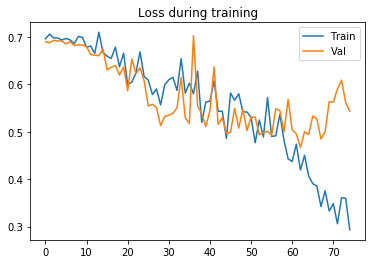

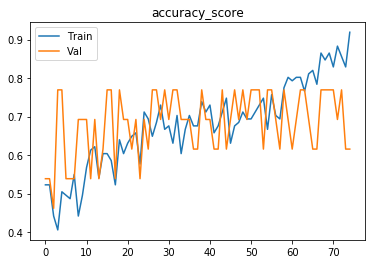

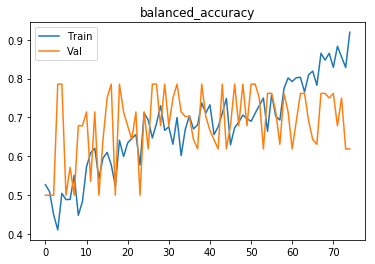

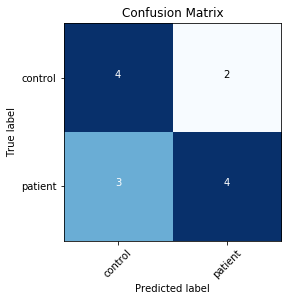

###### Starting inner fold 4
{'model': 'ModelB', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 621961
[0,     5] loss: 0.70955
[0,    10] loss: 0.67495
[0,    15] loss: 0.69866
Time elapsed: 0h:0m:3s
train accuracy_score: 51.35 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690413
[1,     5] loss: 0.68454
[1,    10] loss: 0.69404
[1,    15] loss: 0.70343
Time elapsed: 0h:0m:6s
train accuracy_score: 47.75 %
train balanced_accuracy: 47.03 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.695685
[2,     5] loss: 0.69219
[2,    10] loss: 0.70215
[2,    15] loss: 0.69008
Time elapsed: 0h:0m:9s
train accuracy_score: 45.05 %
train balanced_accuracy: 44.20 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.689801
[3,     5] loss: 0.69153
[3,    10] loss: 0.68730
[3,    15] loss: 0.69080
Time elapsed: 0h:0m:13s
train accuracy_score: 54.95 %
train balanced_accuracy:

val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.484974
[34,     5] loss: 0.44587
[34,    10] loss: 0.54060
[34,    15] loss: 0.64954
Time elapsed: 0h:2m:0s
train accuracy_score: 68.47 %
train balanced_accuracy: 68.27 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.474715
[35,     5] loss: 0.55591
[35,    10] loss: 0.53562
[35,    15] loss: 0.51102
Time elapsed: 0h:2m:3s
train accuracy_score: 72.97 %
train balanced_accuracy: 73.05 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.485806
[36,     5] loss: 0.47102
[36,    10] loss: 0.44267
[36,    15] loss: 0.62159
Time elapsed: 0h:2m:7s
train accuracy_score: 75.68 %
train balanced_accuracy: 75.34 %
val accuracy_score: 69.23 %
val balanced_accuracy: 71.43 %
Val loss: 0.585937
[37,     5] loss: 0.65408
[37,    10] loss: 0.57371
[37,    15] loss: 0.47578
Time elapsed: 0h:2m:10s
train accuracy_score: 72.07 %
train balanced_accuracy: 72.12 %
val accuracy_score: 76.92 %
val

val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.480528
[68,     5] loss: 0.25856
[68,    10] loss: 0.36888
[68,    15] loss: 0.29455
Time elapsed: 0h:3m:58s
train accuracy_score: 85.59 %
train balanced_accuracy: 85.58 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.86 %
Val loss: 0.500757
[69,     5] loss: 0.36250
[69,    10] loss: 0.31134
[69,    15] loss: 0.22352
Time elapsed: 0h:4m:1s
train accuracy_score: 85.59 %
train balanced_accuracy: 85.53 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.570696
[70,     5] loss: 0.37569
[70,    10] loss: 0.29987
[70,    15] loss: 0.33848
Time elapsed: 0h:4m:5s
train accuracy_score: 84.68 %
train balanced_accuracy: 84.65 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.514638
[71,     5] loss: 0.26445
[71,    10] loss: 0.23600
[71,    15] loss: 0.46261
Time elapsed: 0h:4m:8s
train accuracy_score: 88.29 %
train balanced_accuracy: 88.35 %
val accuracy_score: 61.54 %
val

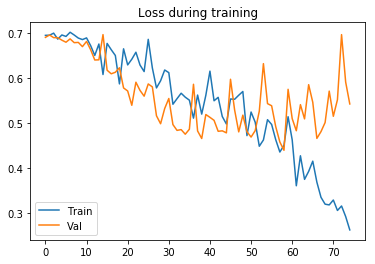

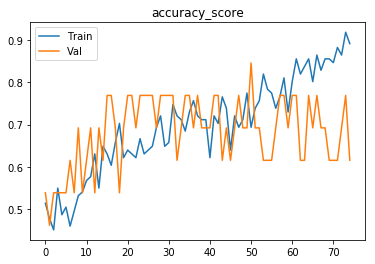

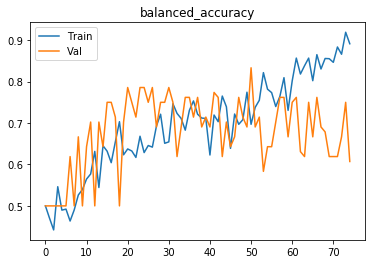

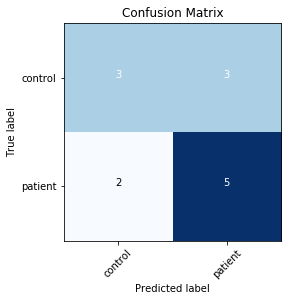

Finished outer fold.
{'final_acc': 0.761904761904762, 'best_acc': 0.761904761904762, 'final_iter': 65, 'best_iter': 33, 'params': {'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 2}
###### Starting outer fold 1
111
13
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 468521
[0,     5] loss: 0.71002
[0,    10] loss: 0.71328
[0,    15] loss: 0.69654
Time elapsed: 0h:0m:1s
train accuracy_score: 47.75 %
train balanced_accuracy: 48.45 %
val accuracy_score: 61.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.675134
[1,     5] loss: 0.68323
[1,    10] loss: 0.64895
[1,    15] loss: 0.77505
Time elapsed: 0h:0m:4s
train accuracy_score: 54.05 %
train balanced_accuracy: 50.96 %
val accuracy_score: 61.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.672721
[2,     5] loss: 0.69184
[2,    10] loss: 0.69735
[2,    15] loss: 0.70101
Time elapsed: 0h:0m:6s
train accuracy_sco

[32,    15] loss: 0.67032
Time elapsed: 0h:1m:17s
train accuracy_score: 64.86 %
train balanced_accuracy: 64.90 %
val accuracy_score: 76.92 %
val balanced_accuracy: 81.25 %
Val loss: 0.583554
[33,     5] loss: 0.61362
[33,    10] loss: 0.54923
[33,    15] loss: 0.49258
Time elapsed: 0h:1m:19s
train accuracy_score: 70.27 %
train balanced_accuracy: 69.64 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.50 %
Val loss: 0.515722
[34,     5] loss: 0.54317
[34,    10] loss: 0.56896
[34,    15] loss: 0.35463
Time elapsed: 0h:1m:22s
train accuracy_score: 78.38 %
train balanced_accuracy: 78.63 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.50 %
Val loss: 0.473667
[35,     5] loss: 0.55939
[35,    10] loss: 0.48484
[35,    15] loss: 0.60889
Time elapsed: 0h:1m:24s
train accuracy_score: 71.17 %
train balanced_accuracy: 71.06 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.50 %
Val loss: 0.478615
[36,     5] loss: 0.61526
[36,    10] loss: 0.48355
[36,    15] loss: 0.45379
Ti

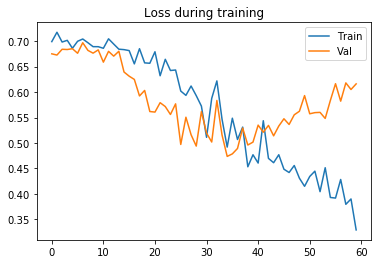

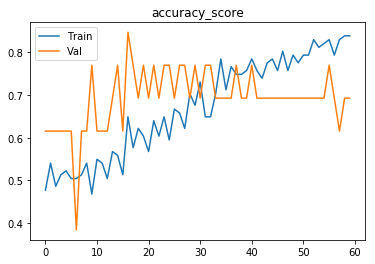

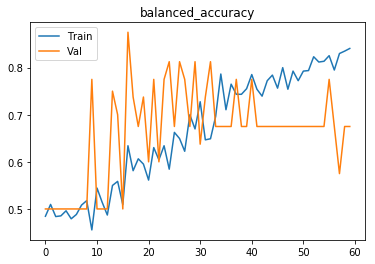

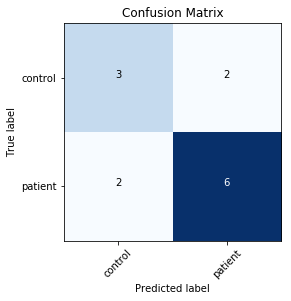

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 468521
[0,     5] loss: 0.69332
[0,    10] loss: 0.68010
[0,    15] loss: 0.70134
[0,    20] loss: 0.69523
[0,    25] loss: 0.67331
Time elapsed: 0h:0m:2s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 61.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.677855
[1,     5] loss: 0.69581
[1,    10] loss: 0.67869
[1,    15] loss: 0.68932
[1,    20] loss: 0.68680
[1,    25] loss: 0.74813
Time elapsed: 0h:0m:4s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 61.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.674999
[2,     5] loss: 0.68919
[2,    10] loss: 0.68937
[2,    15] loss: 0.69454
[2,    20] loss: 0.69308
[2,    25] loss: 0.69331
Time elapsed: 0h:0m:7s
train accuracy_score: 54.05 %
train balanced_accuracy: 52.56 %
val accuracy_score: 69.23 %
val balanced_accuracy: 63.75 %
Val loss: 0.690119
[3,

val accuracy_score: 76.92 %
val balanced_accuracy: 73.75 %
Val loss: 0.544670
[28,     5] loss: 0.58694
[28,    10] loss: 0.61659
[28,    15] loss: 0.53918
[28,    20] loss: 0.66605
[28,    25] loss: 0.59112
Time elapsed: 0h:1m:16s
train accuracy_score: 63.06 %
train balanced_accuracy: 63.43 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.50 %
Val loss: 0.526008
[29,     5] loss: 0.53201
[29,    10] loss: 0.66110
[29,    15] loss: 0.55220
[29,    20] loss: 0.67256
[29,    25] loss: 0.62934
Time elapsed: 0h:1m:18s
train accuracy_score: 66.67 %
train balanced_accuracy: 65.68 %
val accuracy_score: 76.92 %
val balanced_accuracy: 81.25 %
Val loss: 0.563997
[30,     5] loss: 0.61805
[30,    10] loss: 0.60845
[30,    15] loss: 0.62763
[30,    20] loss: 0.58112
[30,    25] loss: 0.64230
Time elapsed: 0h:1m:21s
train accuracy_score: 69.37 %
train balanced_accuracy: 69.25 %
val accuracy_score: 76.92 %
val balanced_accuracy: 73.75 %
Val loss: 0.524326
[31,     5] loss: 0.74355
[31,    10]

val accuracy_score: 69.23 %
val balanced_accuracy: 71.25 %
Val loss: 0.536071
[56,     5] loss: 0.45071
[56,    10] loss: 0.38952
[56,    15] loss: 0.43851
[56,    20] loss: 0.61144
[56,    25] loss: 0.38328
Time elapsed: 0h:2m:30s
train accuracy_score: 80.18 %
train balanced_accuracy: 80.22 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.50 %
Val loss: 0.494721
[57,     5] loss: 0.58090
[57,    10] loss: 0.38728
[57,    15] loss: 0.45459
[57,    20] loss: 0.43251
[57,    25] loss: 0.48053
Time elapsed: 0h:2m:32s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.44 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.50 %
Val loss: 0.500144
[58,     5] loss: 0.40191
[58,    10] loss: 0.42784
[58,    15] loss: 0.36448
[58,    20] loss: 0.48624
[58,    25] loss: 0.54024
Time elapsed: 0h:2m:35s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.44 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.50 %
Val loss: 0.503651
[59,     5] loss: 0.39501
[59,    10]

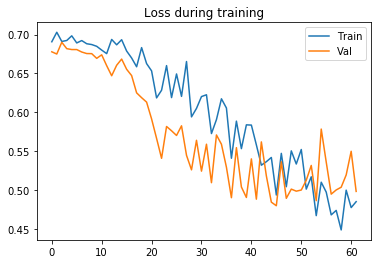

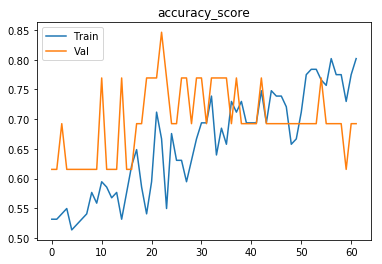

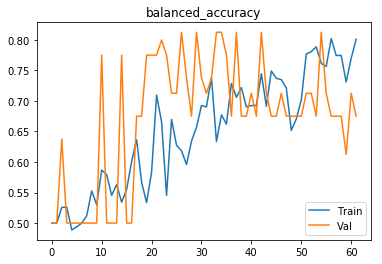

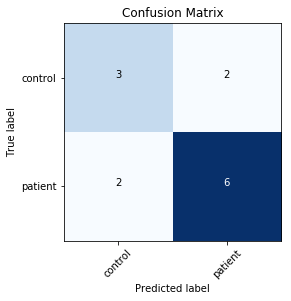

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 621961
[0,     5] loss: 0.69611
Time elapsed: 0h:0m:2s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 61.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.684436
[1,     5] loss: 0.67645
Time elapsed: 0h:0m:5s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.00 %
val accuracy_score: 61.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.675079
[2,     5] loss: 0.69165
Time elapsed: 0h:0m:8s
train accuracy_score: 50.45 %
train balanced_accuracy: 47.57 %
val accuracy_score: 61.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.683248
[3,     5] loss: 0.68230
Time elapsed: 0h:0m:11s
train accuracy_score: 51.35 %
train balanced_accuracy: 48.42 %
val accuracy_score: 61.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.675722
[4,     5] loss: 0.71198
Time elapsed: 0h:0m:14s
train accuracy_score: 49.55 %
train balanced_accuracy: 50.26 %

val accuracy_score: 69.23 %
val balanced_accuracy: 67.50 %
Val loss: 0.581212
[43,     5] loss: 0.48646
Time elapsed: 0h:2m:6s
train accuracy_score: 79.28 %
train balanced_accuracy: 79.48 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.50 %
Val loss: 0.578016
[44,     5] loss: 0.45283
Time elapsed: 0h:2m:9s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.22 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.50 %
Val loss: 0.577856
[45,     5] loss: 0.41124
Time elapsed: 0h:2m:12s
train accuracy_score: 86.49 %
train balanced_accuracy: 86.26 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.50 %
Val loss: 0.572343
[46,     5] loss: 0.35802
Time elapsed: 0h:2m:15s
train accuracy_score: 84.68 %
train balanced_accuracy: 84.79 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.50 %
Val loss: 0.580424
[47,     5] loss: 0.32872
Time elapsed: 0h:2m:18s
train accuracy_score: 84.68 %
train balanced_accuracy: 84.45 %
val accuracy_score: 69.23 %
val balanced_accura

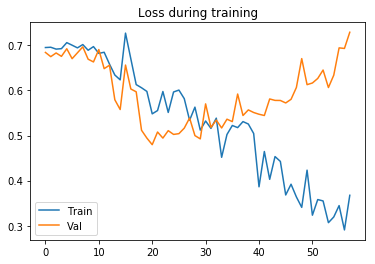

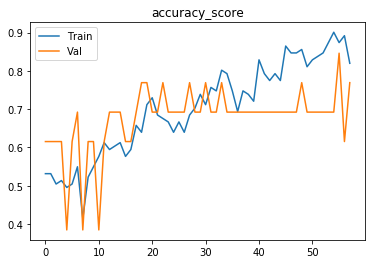

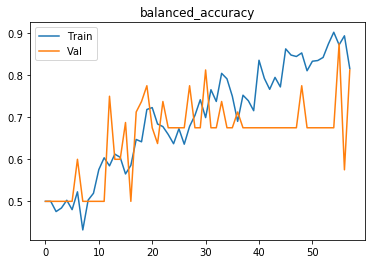

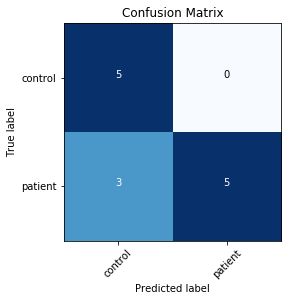

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 621961
[0,     5] loss: 0.69334
Time elapsed: 0h:0m:2s
train accuracy_score: 50.45 %
train balanced_accuracy: 47.57 %
val accuracy_score: 61.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.681771
[1,     5] loss: 0.69249
Time elapsed: 0h:0m:5s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.68 %
val accuracy_score: 61.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.683785
[2,     5] loss: 0.69424
Time elapsed: 0h:0m:8s
train accuracy_score: 46.85 %
train balanced_accuracy: 44.30 %
val accuracy_score: 61.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.681782
[3,     5] loss: 0.69418
Time elapsed: 0h:0m:11s
train accuracy_score: 54.05 %
train balanced_accuracy: 51.08 %
val accuracy_score: 61.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.679430
[4,     5] loss: 0.69357
Time elapsed: 0h:0m:14s
train accuracy_score: 51.35 %
train balanced_accuracy: 49.22 %


val accuracy_score: 76.92 %
val balanced_accuracy: 73.75 %
Val loss: 0.450332
[43,     5] loss: 0.55770
Time elapsed: 0h:2m:6s
train accuracy_score: 65.77 %
train balanced_accuracy: 66.54 %
val accuracy_score: 84.62 %
val balanced_accuracy: 87.50 %
Val loss: 0.515767
[44,     5] loss: 0.53739
Time elapsed: 0h:2m:9s
train accuracy_score: 72.97 %
train balanced_accuracy: 72.98 %
val accuracy_score: 76.92 %
val balanced_accuracy: 73.75 %
Val loss: 0.480692
[45,     5] loss: 0.57950
Time elapsed: 0h:2m:12s
train accuracy_score: 72.97 %
train balanced_accuracy: 71.95 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.50 %
Val loss: 0.473285
[46,     5] loss: 0.48095
Time elapsed: 0h:2m:15s
train accuracy_score: 70.27 %
train balanced_accuracy: 70.32 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.50 %
Val loss: 0.483405
[47,     5] loss: 0.54128
Time elapsed: 0h:2m:18s
train accuracy_score: 70.27 %
train balanced_accuracy: 70.21 %
val accuracy_score: 69.23 %
val balanced_accura

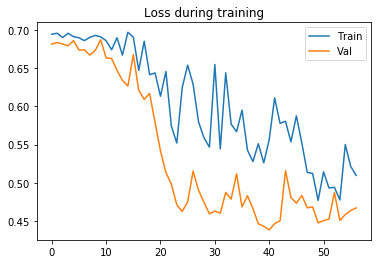

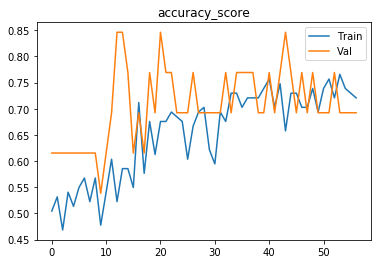

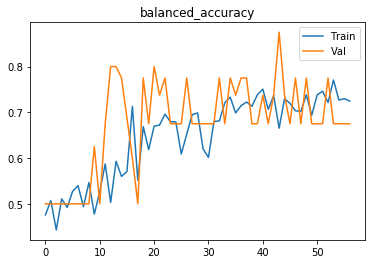

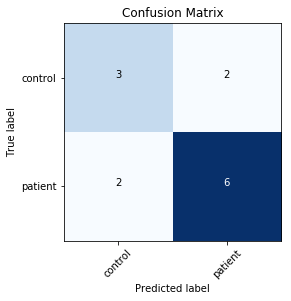

###### Starting inner fold 4
{'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 621961
[0,     5] loss: 0.69125
[0,    10] loss: 0.73590
[0,    15] loss: 0.68438
Time elapsed: 0h:0m:2s
train accuracy_score: 58.56 %
train balanced_accuracy: 60.22 %
val accuracy_score: 61.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.664427
[1,     5] loss: 0.69963
[1,    10] loss: 0.79698
[1,    15] loss: 0.68993
Time elapsed: 0h:0m:6s
train accuracy_score: 49.55 %
train balanced_accuracy: 47.07 %
val accuracy_score: 38.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.696085
[2,     5] loss: 0.69716
[2,    10] loss: 0.70824
[2,    15] loss: 0.70377
Time elapsed: 0h:0m:9s
train accuracy_score: 45.95 %
train balanced_accuracy: 47.56 %
val accuracy_score: 61.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.682679
[3,     5] loss: 0.70398
[3,    10] loss: 0.64413
[3,    15] loss: 0.78427
Time elapsed: 0h:0m:12s
train accuracy_score: 52.25 %
train balanced_accuracy

val accuracy_score: 69.23 %
val balanced_accuracy: 67.50 %
Val loss: 0.542944
[34,     5] loss: 0.48286
[34,    10] loss: 0.53934
[34,    15] loss: 0.52437
Time elapsed: 0h:1m:53s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.22 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.50 %
Val loss: 0.570075
[35,     5] loss: 0.42022
[35,    10] loss: 0.42788
[35,    15] loss: 0.42482
Time elapsed: 0h:1m:56s
train accuracy_score: 75.68 %
train balanced_accuracy: 75.41 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.50 %
Val loss: 0.549870
[36,     5] loss: 0.52137
[36,    10] loss: 0.45112
[36,    15] loss: 0.55035
Time elapsed: 0h:1m:59s
train accuracy_score: 76.58 %
train balanced_accuracy: 76.60 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.50 %
Val loss: 0.562658
[37,     5] loss: 0.46965
[37,    10] loss: 0.47551
[37,    15] loss: 0.26230
Time elapsed: 0h:2m:2s
train accuracy_score: 79.28 %
train balanced_accuracy: 78.91 %
val accuracy_score: 76.92 %
v

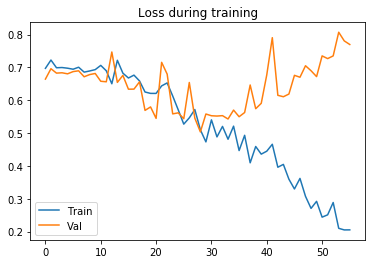

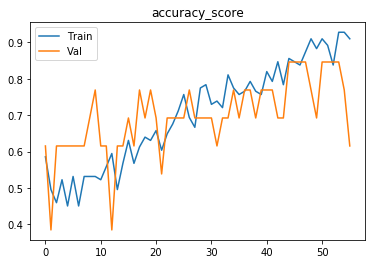

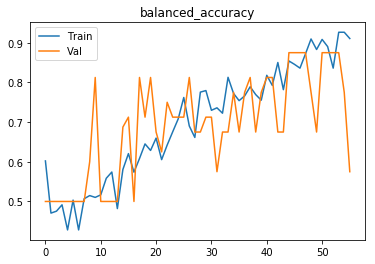

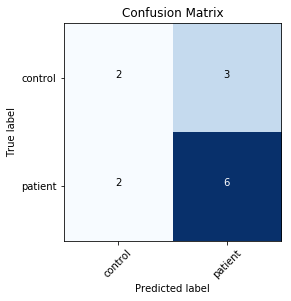

Finished outer fold.
{'final_acc': 0.8125, 'best_acc': 0.875, 'final_iter': 58, 'best_iter': 56, 'params': {'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 2}
###### Starting outer fold 2
111
13
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 468521
[0,     5] loss: 0.69757
Time elapsed: 0h:0m:2s
train accuracy_score: 47.75 %
train balanced_accuracy: 48.17 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.692891
[1,     5] loss: 0.70212
Time elapsed: 0h:0m:4s
train accuracy_score: 51.35 %
train balanced_accuracy: 51.14 %
val accuracy_score: 61.54 %
val balanced_accuracy: 58.33 %
Val loss: 0.687966
[2,     5] loss: 0.68514
Time elapsed: 0h:0m:6s
train accuracy_score: 54.95 %
train balanced_accuracy: 55.23 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.687550
[3,     5] loss: 0.69255
Time elapsed: 0h:0m:9s


[41,     5] loss: 0.61106
Time elapsed: 0h:1m:47s
train accuracy_score: 64.86 %
train balanced_accuracy: 64.81 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.489285
[42,     5] loss: 0.59168
Time elapsed: 0h:1m:49s
train accuracy_score: 65.77 %
train balanced_accuracy: 65.83 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.494229
[43,     5] loss: 0.55386
Time elapsed: 0h:1m:52s
train accuracy_score: 65.77 %
train balanced_accuracy: 65.84 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.449779
[44,     5] loss: 0.60485
Time elapsed: 0h:1m:55s
train accuracy_score: 63.96 %
train balanced_accuracy: 63.75 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.470509
[45,     5] loss: 0.60812
Time elapsed: 0h:1m:57s
train accuracy_score: 70.27 %
train balanced_accuracy: 70.23 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.518277
[46,     5] loss: 0.56365
Time elapsed: 0h:2m

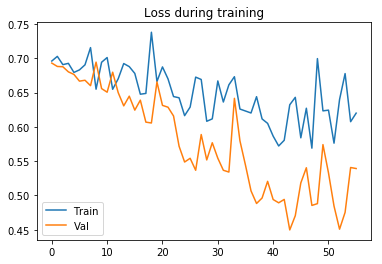

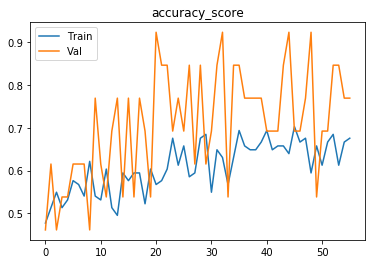

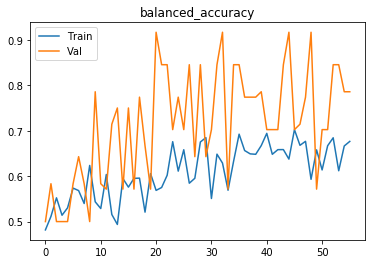

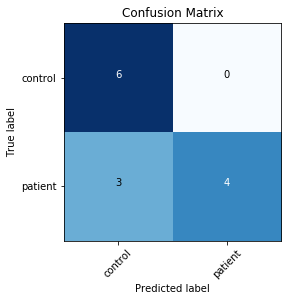

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 468521
[0,     5] loss: 0.69599
[0,    10] loss: 0.68847
[0,    15] loss: 0.70921
[0,    20] loss: 0.71022
[0,    25] loss: 0.69505
Time elapsed: 0h:0m:2s
train accuracy_score: 44.14 %
train balanced_accuracy: 44.29 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.693100
[1,     5] loss: 0.69797
[1,    10] loss: 0.69712
[1,    15] loss: 0.69459
[1,    20] loss: 0.67500
[1,    25] loss: 0.69911
Time elapsed: 0h:0m:5s
train accuracy_score: 51.35 %
train balanced_accuracy: 51.23 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690327
[2,     5] loss: 0.68770
[2,    10] loss: 0.70993
[2,    15] loss: 0.67803
[2,    20] loss: 0.69347
[2,    25] loss: 0.70635
Time elapsed: 0h:0m:8s
train accuracy_score: 53.15 %
train balanced_accuracy: 53.04 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.692672
[3,

val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.457774
[28,     5] loss: 0.53685
[28,    10] loss: 0.56808
[28,    15] loss: 0.58341
[28,    20] loss: 0.63979
[28,    25] loss: 0.63655
Time elapsed: 0h:1m:25s
train accuracy_score: 66.67 %
train balanced_accuracy: 66.66 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.455313
[29,     5] loss: 0.58177
[29,    10] loss: 0.50563
[29,    15] loss: 0.51648
[29,    20] loss: 0.68572
[29,    25] loss: 0.54849
Time elapsed: 0h:1m:27s
train accuracy_score: 72.07 %
train balanced_accuracy: 72.08 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.439140
[30,     5] loss: 0.54221
[30,    10] loss: 0.63443
[30,    15] loss: 0.53155
[30,    20] loss: 0.50915
[30,    25] loss: 0.68289
Time elapsed: 0h:1m:30s
train accuracy_score: 62.16 %
train balanced_accuracy: 62.11 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.437975
[31,     5] loss: 0.79565
[31,    10]

val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.413842
[56,     5] loss: 0.54746
[56,    10] loss: 0.45413
[56,    15] loss: 0.53991
[56,    20] loss: 0.49026
[56,    25] loss: 0.47746
Time elapsed: 0h:2m:47s
train accuracy_score: 71.17 %
train balanced_accuracy: 71.09 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.382265
[57,     5] loss: 0.41696
[57,    10] loss: 0.65919
[57,    15] loss: 0.67565
[57,    20] loss: 0.57648
[57,    25] loss: 0.56052
Time elapsed: 0h:2m:50s
train accuracy_score: 69.37 %
train balanced_accuracy: 69.33 %
val accuracy_score: 76.92 %
val balanced_accuracy: 78.57 %
Val loss: 0.433958
[58,     5] loss: 0.69151
[58,    10] loss: 0.50453
[58,    15] loss: 0.47323
[58,    20] loss: 0.56516
[58,    25] loss: 0.68462
Time elapsed: 0h:2m:53s
train accuracy_score: 69.37 %
train balanced_accuracy: 69.46 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.390271
[59,     5] loss: 0.44293
[59,    10]

val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.293186
[84,     5] loss: 0.53072
[84,    10] loss: 0.58547
[84,    15] loss: 0.39993
[84,    20] loss: 0.48493
[84,    25] loss: 0.48937
Time elapsed: 0h:4m:11s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.44 %
val accuracy_score: 84.62 %
val balanced_accuracy: 85.71 %
Val loss: 0.368062
[85,     5] loss: 0.56623
[85,    10] loss: 0.66947
[85,    15] loss: 0.51622
[85,    20] loss: 0.55873
[85,    25] loss: 0.52380
Time elapsed: 0h:4m:14s
train accuracy_score: 72.97 %
train balanced_accuracy: 72.95 %
val accuracy_score: 76.92 %
val balanced_accuracy: 78.57 %
Val loss: 0.415108
[86,     5] loss: 0.66207
[86,    10] loss: 0.62204
[86,    15] loss: 0.41143
[86,    20] loss: 0.40440
[86,    25] loss: 0.42655
Time elapsed: 0h:4m:17s
train accuracy_score: 73.87 %
train balanced_accuracy: 73.91 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.306437
[87,     5] loss: 0.35976
[87,   

[111,    25] loss: 0.15071
Time elapsed: 0h:5m:30s
train accuracy_score: 89.19 %
train balanced_accuracy: 89.17 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.252443
[112,     5] loss: 0.25655
[112,    10] loss: 0.22871
[112,    15] loss: 0.25684
[112,    20] loss: 0.29734
[112,    25] loss: 0.22434
Time elapsed: 0h:5m:34s
train accuracy_score: 91.89 %
train balanced_accuracy: 91.90 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.233180
[113,     5] loss: 0.28957
[113,    10] loss: 0.23190
[113,    15] loss: 0.25211
[113,    20] loss: 0.38972
[113,    25] loss: 0.14546
Time elapsed: 0h:5m:37s
train accuracy_score: 90.99 %
train balanced_accuracy: 90.99 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.193564
[114,     5] loss: 0.31755
[114,    10] loss: 0.23689
[114,    15] loss: 0.19680
[114,    20] loss: 0.17985
[114,    25] loss: 0.28046
Time elapsed: 0h:5m:40s
train accuracy_score: 90.99 %
train balanced_accu

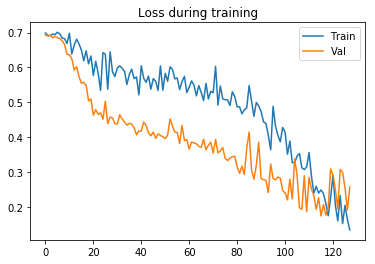

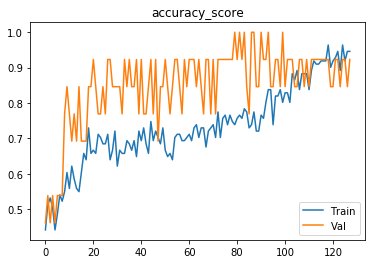

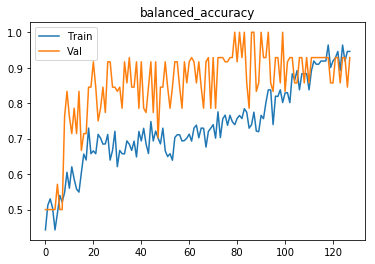

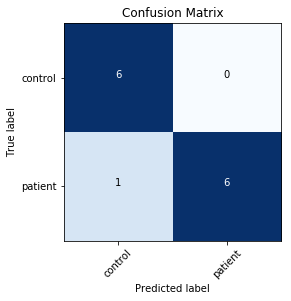

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 621961
[0,     5] loss: 0.69363
Time elapsed: 0h:0m:2s
train accuracy_score: 45.05 %
train balanced_accuracy: 44.69 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.693725
[1,     5] loss: 0.69341
Time elapsed: 0h:0m:5s
train accuracy_score: 48.65 %
train balanced_accuracy: 49.04 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.698789
[2,     5] loss: 0.71787
Time elapsed: 0h:0m:9s
train accuracy_score: 46.85 %
train balanced_accuracy: 46.54 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.688748
[3,     5] loss: 0.69135
Time elapsed: 0h:0m:12s
train accuracy_score: 48.65 %
train balanced_accuracy: 48.59 %
val accuracy_score: 69.23 %
val balanced_accuracy: 66.67 %
Val loss: 0.690071
[4,     5] loss: 0.69564
Time elapsed: 0h:0m:15s
train accuracy_score: 54.05 %
train balanced_accuracy: 53.90 %

val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.337657
[43,     5] loss: 0.50063
Time elapsed: 0h:2m:20s
train accuracy_score: 71.17 %
train balanced_accuracy: 71.19 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.336147
[44,     5] loss: 0.57156
Time elapsed: 0h:2m:24s
train accuracy_score: 80.18 %
train balanced_accuracy: 80.03 %
val accuracy_score: 84.62 %
val balanced_accuracy: 85.71 %
Val loss: 0.368098
[45,     5] loss: 0.65513
Time elapsed: 0h:2m:27s
train accuracy_score: 65.77 %
train balanced_accuracy: 65.94 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.394888
[46,     5] loss: 0.56907
Time elapsed: 0h:2m:30s
train accuracy_score: 67.57 %
train balanced_accuracy: 67.48 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.404690
[47,     5] loss: 0.57076
Time elapsed: 0h:2m:33s
train accuracy_score: 74.77 %
train balanced_accuracy: 74.76 %
val accuracy_score: 92.31 %
val balanced_accu

val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.137257
[86,     5] loss: 0.28034
Time elapsed: 0h:4m:40s
train accuracy_score: 86.49 %
train balanced_accuracy: 86.54 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.108239
[87,     5] loss: 0.20111
Time elapsed: 0h:4m:43s
train accuracy_score: 90.99 %
train balanced_accuracy: 91.01 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.103247
[88,     5] loss: 0.23475
Time elapsed: 0h:4m:47s
train accuracy_score: 89.19 %
train balanced_accuracy: 89.16 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.207119
[89,     5] loss: 0.18626
Time elapsed: 0h:4m:50s
train accuracy_score: 91.89 %
train balanced_accuracy: 91.88 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.271364
[90,     5] loss: 0.22671
Time elapsed: 0h:4m:53s
train accuracy_score: 90.09 %
train balanced_accuracy: 90.06 %
val accuracy_score: 92.31 %
val balanced_ac

val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.145391
[129,     5] loss: 0.01378
Time elapsed: 0h:6m:59s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.086419
[130,     5] loss: 0.01131
Time elapsed: 0h:7m:2s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.180773
[131,     5] loss: 0.02006
Time elapsed: 0h:7m:6s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.082071
Early stopping in epoch 132
Total time elapsed: 0h:7m:6s
Writing model to disk...
Best result during training: 1.00. Saving model..
Finished inner fold.


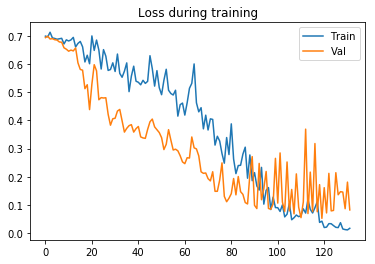

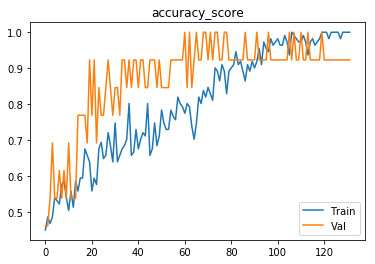

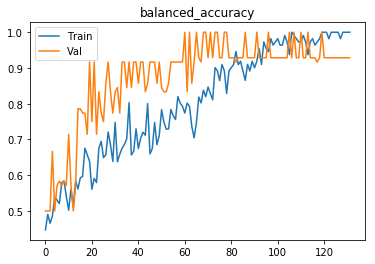

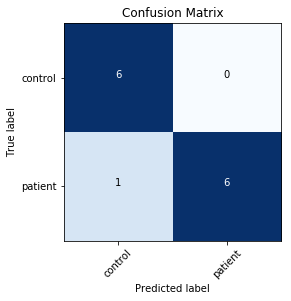

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 621961
[0,     5] loss: 0.70770
[0,    10] loss: 0.70500
[0,    15] loss: 0.69870
Time elapsed: 0h:0m:2s
train accuracy_score: 40.54 %
train balanced_accuracy: 40.44 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.700323
[1,     5] loss: 0.69364
[1,    10] loss: 0.70123
[1,    15] loss: 0.69715
Time elapsed: 0h:0m:6s
train accuracy_score: 45.05 %
train balanced_accuracy: 45.42 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.692167
[2,     5] loss: 0.67962
[2,    10] loss: 0.67275
[2,    15] loss: 0.71879
Time elapsed: 0h:0m:10s
train accuracy_score: 54.05 %
train balanced_accuracy: 53.70 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.708781
[3,     5] loss: 0.75534
[3,    10] loss: 0.70367
[3,    15] loss: 0.70472
Time elapsed: 0h:0m:13s
train accuracy_score: 45.95 %
train balanced_accurac

Time elapsed: 0h:2m:0s
train accuracy_score: 67.57 %
train balanced_accuracy: 67.52 %
val accuracy_score: 61.54 %
val balanced_accuracy: 64.29 %
Val loss: 0.559028
[34,     5] loss: 0.60583
[34,    10] loss: 0.57427
[34,    15] loss: 0.63049
Time elapsed: 0h:2m:4s
train accuracy_score: 67.57 %
train balanced_accuracy: 67.52 %
val accuracy_score: 84.62 %
val balanced_accuracy: 85.71 %
Val loss: 0.452140
[35,     5] loss: 0.57381
[35,    10] loss: 0.57776
[35,    15] loss: 0.65420
Time elapsed: 0h:2m:7s
train accuracy_score: 65.77 %
train balanced_accuracy: 65.78 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.416539
[36,     5] loss: 0.54020
[36,    10] loss: 0.58399
[36,    15] loss: 0.59810
Time elapsed: 0h:2m:11s
train accuracy_score: 68.47 %
train balanced_accuracy: 68.41 %
val accuracy_score: 84.62 %
val balanced_accuracy: 85.71 %
Val loss: 0.427572
[37,     5] loss: 0.61467
[37,    10] loss: 0.54462
[37,    15] loss: 0.49988
Time elapsed: 0h:2m:14s
train a

[67,    10] loss: 0.13742
[67,    15] loss: 0.34767
Time elapsed: 0h:4m:2s
train accuracy_score: 93.69 %
train balanced_accuracy: 93.70 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.190583
[68,     5] loss: 0.14757
[68,    10] loss: 0.28192
[68,    15] loss: 0.23648
Time elapsed: 0h:4m:5s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.40 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.247772
[69,     5] loss: 0.25764
[69,    10] loss: 0.24099
[69,    15] loss: 0.19769
Time elapsed: 0h:4m:9s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.40 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.259673
[70,     5] loss: 0.12549
[70,    10] loss: 0.25331
[70,    15] loss: 0.31003
Time elapsed: 0h:4m:12s
train accuracy_score: 90.09 %
train balanced_accuracy: 90.10 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.239699
[71,     5] loss: 0.12957
[71,    10] loss: 0.16705
[71, 

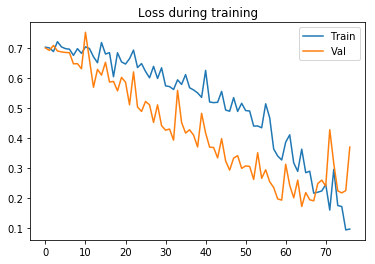

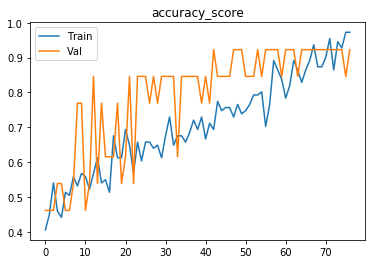

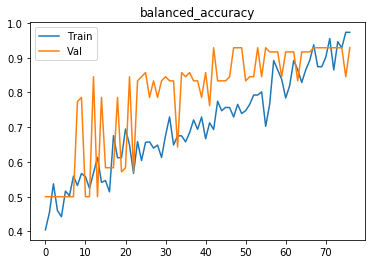

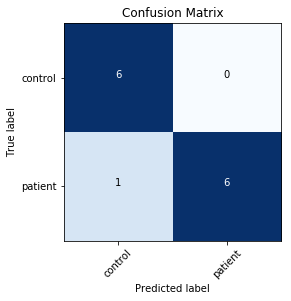

###### Starting inner fold 4
{'model': 'ModelA', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 468521
[0,     5] loss: 0.69969
Time elapsed: 0h:0m:2s
train accuracy_score: 49.55 %
train balanced_accuracy: 50.00 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.697372
[1,     5] loss: 0.68821
Time elapsed: 0h:0m:4s
train accuracy_score: 50.45 %
train balanced_accuracy: 50.86 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.695010
[2,     5] loss: 0.70277
Time elapsed: 0h:0m:7s
train accuracy_score: 42.34 %
train balanced_accuracy: 42.29 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.689188
[3,     5] loss: 0.69494
Time elapsed: 0h:0m:9s
train accuracy_score: 50.45 %
train balanced_accuracy: 50.05 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.687700
[4,     5] loss: 0.69694
Time elapsed: 0h:0m:11s
train accuracy_score: 51.35 %
train balanced_accuracy: 50.94 %
v

val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.576639
[43,     5] loss: 0.67229
Time elapsed: 0h:1m:49s
train accuracy_score: 63.96 %
train balanced_accuracy: 63.93 %
val accuracy_score: 76.92 %
val balanced_accuracy: 78.57 %
Val loss: 0.589942
[44,     5] loss: 0.62552
Time elapsed: 0h:1m:52s
train accuracy_score: 57.66 %
train balanced_accuracy: 57.69 %
val accuracy_score: 69.23 %
val balanced_accuracy: 71.43 %
Val loss: 0.602844
[45,     5] loss: 0.67125
Time elapsed: 0h:1m:54s
train accuracy_score: 61.26 %
train balanced_accuracy: 61.41 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.580746
[46,     5] loss: 0.63933
Time elapsed: 0h:1m:57s
train accuracy_score: 64.86 %
train balanced_accuracy: 64.76 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.573594
[47,     5] loss: 0.64426
Time elapsed: 0h:1m:59s
train accuracy_score: 62.16 %
train balanced_accuracy: 62.08 %
val accuracy_score: 84.62 %
val balanced_accu

val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.386631
[86,     5] loss: 0.49265
Time elapsed: 0h:3m:37s
train accuracy_score: 74.77 %
train balanced_accuracy: 74.69 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.376061
[87,     5] loss: 0.52739
Time elapsed: 0h:3m:39s
train accuracy_score: 71.17 %
train balanced_accuracy: 71.15 %
val accuracy_score: 84.62 %
val balanced_accuracy: 85.71 %
Val loss: 0.389939
[88,     5] loss: 0.52196
Time elapsed: 0h:3m:42s
train accuracy_score: 72.97 %
train balanced_accuracy: 73.04 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.378820
[89,     5] loss: 0.54496
Time elapsed: 0h:3m:44s
train accuracy_score: 70.27 %
train balanced_accuracy: 70.19 %
val accuracy_score: 84.62 %
val balanced_accuracy: 85.71 %
Val loss: 0.388870
[90,     5] loss: 0.55273
Time elapsed: 0h:3m:47s
train accuracy_score: 67.57 %
train balanced_accuracy: 67.63 %
val accuracy_score: 76.92 %
val balanced_accu

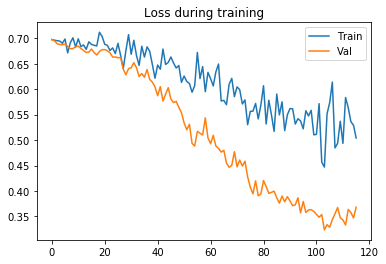

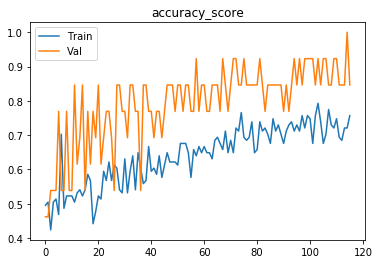

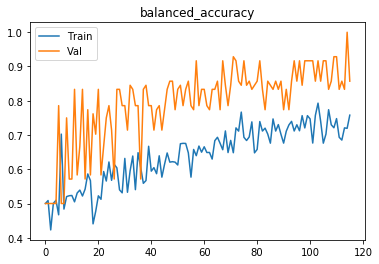

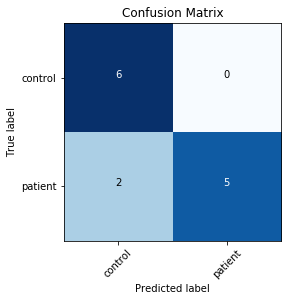

Finished outer fold.
{'final_acc': 0.9285714285714286, 'best_acc': 1.0, 'final_iter': 128, 'best_iter': 100, 'params': {'model': 'ModelA', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 1}
###### Starting outer fold 3
111
13
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 468521
[0,     5] loss: 0.69843
Time elapsed: 0h:0m:1s
train accuracy_score: 51.35 %
train balanced_accuracy: 51.30 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691797
[1,     5] loss: 0.69851
Time elapsed: 0h:0m:4s
train accuracy_score: 45.95 %
train balanced_accuracy: 46.07 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.689501
[2,     5] loss: 0.69919
Time elapsed: 0h:0m:6s
train accuracy_score: 47.75 %
train balanced_accuracy: 47.99 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.688315
[3,     5] loss: 0.69566
Time elapsed:

[41,     5] loss: 0.56790
Time elapsed: 0h:1m:42s
train accuracy_score: 66.67 %
train balanced_accuracy: 66.54 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.496165
[42,     5] loss: 0.58782
Time elapsed: 0h:1m:45s
train accuracy_score: 67.57 %
train balanced_accuracy: 67.61 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.524226
[43,     5] loss: 0.61402
Time elapsed: 0h:1m:47s
train accuracy_score: 68.47 %
train balanced_accuracy: 68.46 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.493047
[44,     5] loss: 0.60415
Time elapsed: 0h:1m:50s
train accuracy_score: 70.27 %
train balanced_accuracy: 70.15 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.477438
[45,     5] loss: 0.61493
Time elapsed: 0h:1m:52s
train accuracy_score: 61.26 %
train balanced_accuracy: 61.27 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.488335
[46,     5] loss: 0.57476
Time elapsed: 0h:1m

[84,     5] loss: 0.56185
Time elapsed: 0h:3m:26s
train accuracy_score: 71.17 %
train balanced_accuracy: 71.30 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.403242
[85,     5] loss: 0.49072
Time elapsed: 0h:3m:28s
train accuracy_score: 79.28 %
train balanced_accuracy: 79.22 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.359243
[86,     5] loss: 0.53775
Time elapsed: 0h:3m:31s
train accuracy_score: 71.17 %
train balanced_accuracy: 71.25 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.325124
[87,     5] loss: 0.42585
Time elapsed: 0h:3m:33s
train accuracy_score: 81.08 %
train balanced_accuracy: 81.09 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.332722
[88,     5] loss: 0.46627
Time elapsed: 0h:3m:35s
train accuracy_score: 79.28 %
train balanced_accuracy: 79.19 %
val accuracy_score: 76.92 %
val balanced_accuracy: 75.00 %
Val loss: 0.397955
[89,     5] loss: 0.48128
Time elapsed: 0h:3m

[127,     5] loss: 0.17609
Time elapsed: 0h:5m:10s
train accuracy_score: 93.69 %
train balanced_accuracy: 93.69 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.094997
[128,     5] loss: 0.17068
Time elapsed: 0h:5m:12s
train accuracy_score: 94.59 %
train balanced_accuracy: 94.64 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.083336
[129,     5] loss: 0.11377
Time elapsed: 0h:5m:14s
train accuracy_score: 94.59 %
train balanced_accuracy: 94.59 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.082293
[130,     5] loss: 0.23095
Time elapsed: 0h:5m:17s
train accuracy_score: 93.69 %
train balanced_accuracy: 93.73 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.069119
[131,     5] loss: 0.19190
Time elapsed: 0h:5m:19s
train accuracy_score: 92.79 %
train balanced_accuracy: 92.81 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.068589
[132,     5] loss: 0.12526
Tim

val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.018710
[170,     5] loss: 0.04800
Time elapsed: 0h:6m:53s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.09 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.027041
[171,     5] loss: 0.03604
Time elapsed: 0h:6m:55s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.11 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.020020
[172,     5] loss: 0.06268
Time elapsed: 0h:6m:58s
train accuracy_score: 98.20 %
train balanced_accuracy: 98.18 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.117016
[173,     5] loss: 0.01716
Time elapsed: 0h:7m:0s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.038521
[174,     5] loss: 0.02023
Time elapsed: 0h:7m:3s
train accuracy_score: 98.20 %
train balanced_accuracy: 98.18 %
val accuracy_score: 100.00 %
val

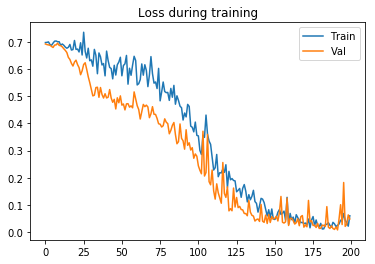

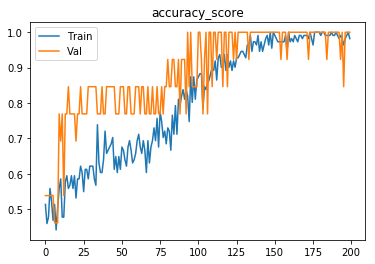

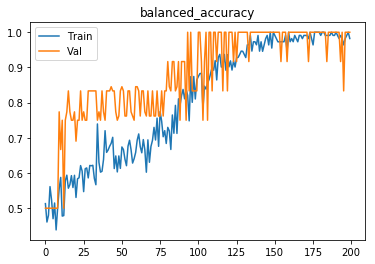

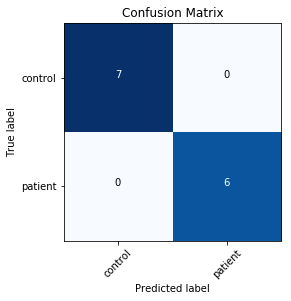

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 468521
[0,     5] loss: 0.69693
Time elapsed: 0h:0m:1s
train accuracy_score: 45.95 %
train balanced_accuracy: 45.84 %
val accuracy_score: 46.15 %
val balanced_accuracy: 48.81 %
Val loss: 0.693819
[1,     5] loss: 0.68917
Time elapsed: 0h:0m:4s
train accuracy_score: 51.35 %
train balanced_accuracy: 51.28 %
val accuracy_score: 46.15 %
val balanced_accuracy: 48.81 %
Val loss: 0.693213
[2,     5] loss: 0.69430
Time elapsed: 0h:0m:6s
train accuracy_score: 54.95 %
train balanced_accuracy: 55.00 %
val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.692133
[3,     5] loss: 0.69615
Time elapsed: 0h:0m:8s
train accuracy_score: 49.55 %
train balanced_accuracy: 49.53 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.693306
[4,     5] loss: 0.69683
Time elapsed: 0h:0m:11s
train accuracy_score: 41.44 %
train balanced_accuracy: 41.43 %
v

val accuracy_score: 76.92 %
val balanced_accuracy: 75.00 %
Val loss: 0.596124
[43,     5] loss: 0.66314
Time elapsed: 0h:1m:43s
train accuracy_score: 54.95 %
train balanced_accuracy: 55.03 %
val accuracy_score: 69.23 %
val balanced_accuracy: 66.67 %
Val loss: 0.601993
[44,     5] loss: 0.68883
Time elapsed: 0h:1m:46s
train accuracy_score: 51.35 %
train balanced_accuracy: 51.40 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.588466
[45,     5] loss: 0.67932
Time elapsed: 0h:1m:48s
train accuracy_score: 60.36 %
train balanced_accuracy: 60.29 %
val accuracy_score: 76.92 %
val balanced_accuracy: 75.00 %
Val loss: 0.595102
[46,     5] loss: 0.67162
Time elapsed: 0h:1m:51s
train accuracy_score: 63.96 %
train balanced_accuracy: 64.01 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.604145
[47,     5] loss: 0.63746
Time elapsed: 0h:1m:53s
train accuracy_score: 70.27 %
train balanced_accuracy: 70.34 %
val accuracy_score: 76.92 %
val balanced_accu

val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.465904
[86,     5] loss: 0.65293
Time elapsed: 0h:3m:26s
train accuracy_score: 60.36 %
train balanced_accuracy: 60.18 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.477496
[87,     5] loss: 0.59930
Time elapsed: 0h:3m:28s
train accuracy_score: 64.86 %
train balanced_accuracy: 64.98 %
val accuracy_score: 76.92 %
val balanced_accuracy: 75.00 %
Val loss: 0.537246
[88,     5] loss: 0.56832
Time elapsed: 0h:3m:31s
train accuracy_score: 68.47 %
train balanced_accuracy: 68.54 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.493831
[89,     5] loss: 0.55068
Time elapsed: 0h:3m:33s
train accuracy_score: 72.97 %
train balanced_accuracy: 72.87 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.488275
[90,     5] loss: 0.59114
Time elapsed: 0h:3m:35s
train accuracy_score: 70.27 %
train balanced_accuracy: 70.16 %
val accuracy_score: 84.62 %
val balanced_accu

val accuracy_score: 76.92 %
val balanced_accuracy: 75.00 %
Val loss: 0.382589
[129,     5] loss: 0.47158
Time elapsed: 0h:5m:8s
train accuracy_score: 74.77 %
train balanced_accuracy: 74.87 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.345453
[130,     5] loss: 0.41723
Time elapsed: 0h:5m:10s
train accuracy_score: 79.28 %
train balanced_accuracy: 79.25 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.361363
[131,     5] loss: 0.45561
Time elapsed: 0h:5m:12s
train accuracy_score: 79.28 %
train balanced_accuracy: 79.32 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.336850
[132,     5] loss: 0.42796
Time elapsed: 0h:5m:15s
train accuracy_score: 82.88 %
train balanced_accuracy: 82.87 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.335914
[133,     5] loss: 0.47624
Time elapsed: 0h:5m:17s
train accuracy_score: 82.88 %
train balanced_accuracy: 83.00 %
val accuracy_score: 84.62 %
val balanced_

val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.169594
[172,     5] loss: 0.27779
Time elapsed: 0h:6m:51s
train accuracy_score: 90.09 %
train balanced_accuracy: 90.08 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.225575
[173,     5] loss: 0.31823
Time elapsed: 0h:6m:53s
train accuracy_score: 86.49 %
train balanced_accuracy: 86.48 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.173249
[174,     5] loss: 0.28950
Time elapsed: 0h:6m:55s
train accuracy_score: 90.09 %
train balanced_accuracy: 90.10 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.290747
[175,     5] loss: 0.19743
Time elapsed: 0h:6m:58s
train accuracy_score: 93.69 %
train balanced_accuracy: 93.72 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.201612
[176,     5] loss: 0.28999
Time elapsed: 0h:7m:0s
train accuracy_score: 85.59 %
train balanced_accuracy: 85.52 %
val accuracy_score: 100.00 %
val ba

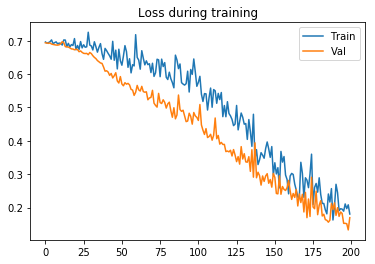

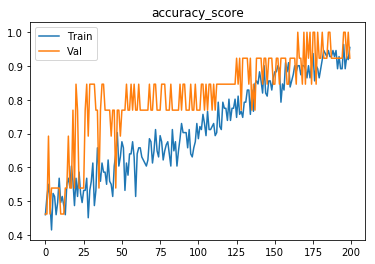

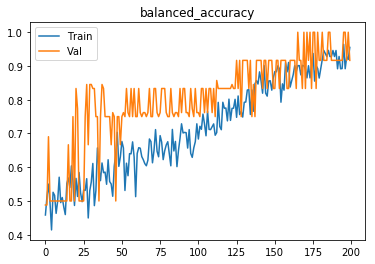

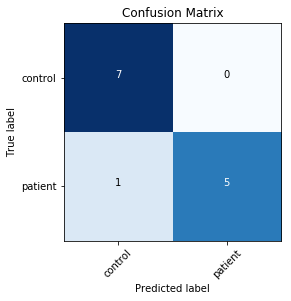

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 621961
[0,     5] loss: 0.69162
[0,    10] loss: 0.70243
[0,    15] loss: 0.69551
Time elapsed: 0h:0m:2s
train accuracy_score: 43.24 %
train balanced_accuracy: 43.44 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.691073
[1,     5] loss: 0.69079
[1,    10] loss: 0.69741
[1,    15] loss: 0.69785
Time elapsed: 0h:0m:6s
train accuracy_score: 45.05 %
train balanced_accuracy: 45.37 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.687519
[2,     5] loss: 0.70025
[2,    10] loss: 0.69387
[2,    15] loss: 0.69417
Time elapsed: 0h:0m:9s
train accuracy_score: 45.05 %
train balanced_accuracy: 44.94 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.690645
[3,     5] loss: 0.69201
[3,    10] loss: 0.68484
[3,    15] loss: 0.70076
Time elapsed: 0h:0m:13s
train accuracy_score: 56.76 %
train balanced_accuracy:

val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.481859
[34,     5] loss: 0.61933
[34,    10] loss: 0.58108
[34,    15] loss: 0.56952
Time elapsed: 0h:1m:59s
train accuracy_score: 69.37 %
train balanced_accuracy: 69.32 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.448451
[35,     5] loss: 0.50147
[35,    10] loss: 0.55308
[35,    15] loss: 0.63153
Time elapsed: 0h:2m:3s
train accuracy_score: 66.67 %
train balanced_accuracy: 66.69 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.439366
[36,     5] loss: 0.61922
[36,    10] loss: 0.56949
[36,    15] loss: 0.49848
Time elapsed: 0h:2m:6s
train accuracy_score: 67.57 %
train balanced_accuracy: 67.48 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.478275
[37,     5] loss: 0.53149
[37,    10] loss: 0.53600
[37,    15] loss: 0.62226
Time elapsed: 0h:2m:10s
train accuracy_score: 71.17 %
train balanced_accuracy: 71.14 %
val accuracy_score: 84.62 %
va

val accuracy_score: 84.62 %
val balanced_accuracy: 85.71 %
Val loss: 0.239044
[68,     5] loss: 0.33125
[68,    10] loss: 0.33202
[68,    15] loss: 0.25507
Time elapsed: 0h:3m:57s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.35 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.243529
[69,     5] loss: 0.26839
[69,    10] loss: 0.19228
[69,    15] loss: 0.32673
Time elapsed: 0h:4m:0s
train accuracy_score: 91.89 %
train balanced_accuracy: 91.92 %
val accuracy_score: 84.62 %
val balanced_accuracy: 85.71 %
Val loss: 0.249518
[70,     5] loss: 0.22091
[70,    10] loss: 0.25706
[70,    15] loss: 0.16542
Time elapsed: 0h:4m:4s
train accuracy_score: 91.89 %
train balanced_accuracy: 91.88 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.247783
[71,     5] loss: 0.38425
[71,    10] loss: 0.18083
[71,    15] loss: 0.25122
Time elapsed: 0h:4m:7s
train accuracy_score: 86.49 %
train balanced_accuracy: 86.48 %
val accuracy_score: 100.00 %
va

Time elapsed: 0h:5m:51s
train accuracy_score: 93.69 %
train balanced_accuracy: 93.70 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.110733
[102,     5] loss: 0.08469
[102,    10] loss: 0.06544
[102,    15] loss: 0.07378
Time elapsed: 0h:5m:55s
train accuracy_score: 97.30 %
train balanced_accuracy: 97.31 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.055124
[103,     5] loss: 0.12313
[103,    10] loss: 0.10006
[103,    15] loss: 0.07401
Time elapsed: 0h:5m:58s
train accuracy_score: 97.30 %
train balanced_accuracy: 97.29 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.110358
[104,     5] loss: 0.06943
[104,    10] loss: 0.08926
[104,    15] loss: 0.05683
Time elapsed: 0h:6m:1s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.09 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.057408
[105,     5] loss: 0.11662
[105,    10] loss: 0.05892
[105,    15] loss: 0.10875
Time elapse

Best result during training: 1.00. Saving model..
Finished inner fold.


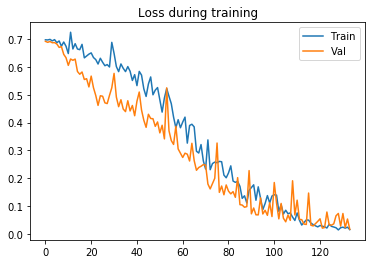

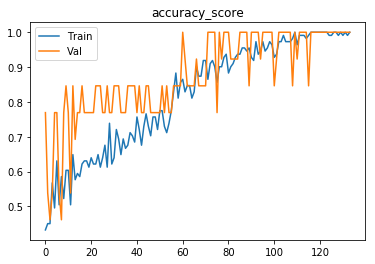

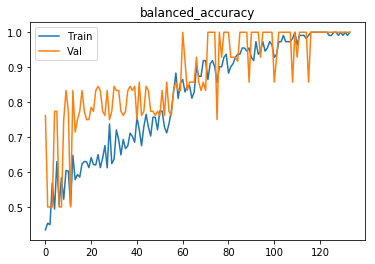

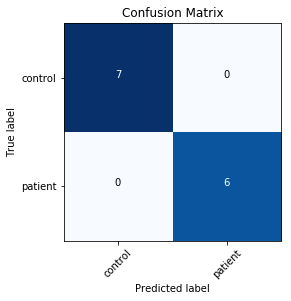

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 621961
[0,     5] loss: 0.69394
Time elapsed: 0h:0m:2s
train accuracy_score: 49.55 %
train balanced_accuracy: 49.74 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.687970
[1,     5] loss: 0.68623
Time elapsed: 0h:0m:5s
train accuracy_score: 53.15 %
train balanced_accuracy: 52.91 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.689191
[2,     5] loss: 0.68342
Time elapsed: 0h:0m:8s
train accuracy_score: 54.05 %
train balanced_accuracy: 54.12 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.679532
[3,     5] loss: 0.69831
Time elapsed: 0h:0m:11s
train accuracy_score: 49.55 %
train balanced_accuracy: 49.25 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694777
[4,     5] loss: 0.68794
Time elapsed: 0h:0m:15s
train accuracy_score: 48.65 %
train balanced_accuracy: 48.83 %

val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.484299
[43,     5] loss: 0.60685
Time elapsed: 0h:2m:16s
train accuracy_score: 69.37 %
train balanced_accuracy: 69.22 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.433668
[44,     5] loss: 0.49709
Time elapsed: 0h:2m:19s
train accuracy_score: 74.77 %
train balanced_accuracy: 74.74 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.416298
[45,     5] loss: 0.53651
Time elapsed: 0h:2m:22s
train accuracy_score: 71.17 %
train balanced_accuracy: 71.12 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.414127
[46,     5] loss: 0.53490
Time elapsed: 0h:2m:25s
train accuracy_score: 72.97 %
train balanced_accuracy: 72.97 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.432697
[47,     5] loss: 0.44614
Time elapsed: 0h:2m:28s
train accuracy_score: 78.38 %
train balanced_accuracy: 78.36 %
val accuracy_score: 76.92 %
val balanced_accu

val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.253900
[86,     5] loss: 0.16874
Time elapsed: 0h:4m:30s
train accuracy_score: 91.89 %
train balanced_accuracy: 91.93 %
val accuracy_score: 76.92 %
val balanced_accuracy: 78.57 %
Val loss: 0.481459
[87,     5] loss: 0.17016
Time elapsed: 0h:4m:33s
train accuracy_score: 94.59 %
train balanced_accuracy: 94.58 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.252848
[88,     5] loss: 0.20002
Time elapsed: 0h:4m:36s
train accuracy_score: 89.19 %
train balanced_accuracy: 89.19 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.206218
[89,     5] loss: 0.08906
Time elapsed: 0h:4m:39s
train accuracy_score: 98.20 %
train balanced_accuracy: 98.21 %
val accuracy_score: 84.62 %
val balanced_accuracy: 85.71 %
Val loss: 0.213046
[90,     5] loss: 0.11191
Time elapsed: 0h:4m:42s
train accuracy_score: 98.20 %
train balanced_accuracy: 98.20 %
val accuracy_score: 92.31 %
val balanced_accu

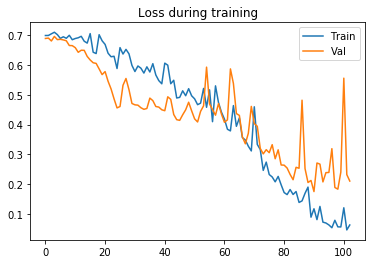

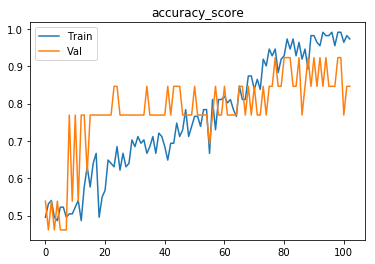

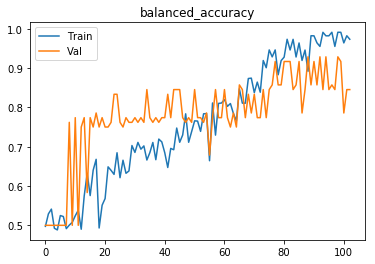

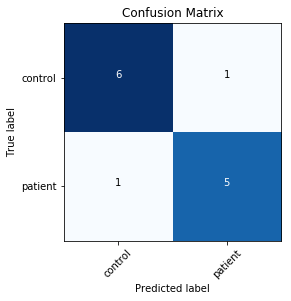

###### Starting inner fold 4
{'model': 'ModelA', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 468521
[0,     5] loss: 0.70018
Time elapsed: 0h:0m:1s
train accuracy_score: 45.95 %
train balanced_accuracy: 45.70 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.698541
[1,     5] loss: 0.68962
Time elapsed: 0h:0m:4s
train accuracy_score: 57.66 %
train balanced_accuracy: 57.50 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694871
[2,     5] loss: 0.69793
Time elapsed: 0h:0m:6s
train accuracy_score: 45.95 %
train balanced_accuracy: 45.83 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694391
[3,     5] loss: 0.69040
Time elapsed: 0h:0m:9s
train accuracy_score: 49.55 %
train balanced_accuracy: 49.59 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.692510
[4,     5] loss: 0.70369
Time elapsed: 0h:0m:11s
train accuracy_score: 47.75 %
train balanced_accuracy: 47.87 %


val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.478559
[43,     5] loss: 0.51425
Time elapsed: 0h:1m:44s
train accuracy_score: 73.87 %
train balanced_accuracy: 73.80 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.447133
[44,     5] loss: 0.61808
Time elapsed: 0h:1m:46s
train accuracy_score: 67.57 %
train balanced_accuracy: 67.34 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.464565
[45,     5] loss: 0.55443
Time elapsed: 0h:1m:49s
train accuracy_score: 72.07 %
train balanced_accuracy: 72.24 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.452583
[46,     5] loss: 0.60171
Time elapsed: 0h:1m:51s
train accuracy_score: 71.17 %
train balanced_accuracy: 71.22 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.419602
[47,     5] loss: 0.59214
Time elapsed: 0h:1m:54s
train accuracy_score: 70.27 %
train balanced_accuracy: 70.15 %
val accuracy_score: 76.92 %
val balanced_accu

val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.305656
[86,     5] loss: 0.36430
Time elapsed: 0h:3m:27s
train accuracy_score: 85.59 %
train balanced_accuracy: 85.68 %
val accuracy_score: 84.62 %
val balanced_accuracy: 85.71 %
Val loss: 0.290460
[87,     5] loss: 0.38760
Time elapsed: 0h:3m:30s
train accuracy_score: 84.68 %
train balanced_accuracy: 84.59 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.360377
[88,     5] loss: 0.37899
Time elapsed: 0h:3m:32s
train accuracy_score: 88.29 %
train balanced_accuracy: 88.36 %
val accuracy_score: 84.62 %
val balanced_accuracy: 85.71 %
Val loss: 0.275851
[89,     5] loss: 0.32229
Time elapsed: 0h:3m:34s
train accuracy_score: 88.29 %
train balanced_accuracy: 88.20 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.392935
[90,     5] loss: 0.32317
Time elapsed: 0h:3m:37s
train accuracy_score: 85.59 %
train balanced_accuracy: 85.67 %
val accuracy_score: 84.62 %
val balanced_accu

Time elapsed: 0h:5m:7s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.11 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.083730
[129,     5] loss: 0.07986
Time elapsed: 0h:5m:10s
train accuracy_score: 98.20 %
train balanced_accuracy: 98.20 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.073373
[130,     5] loss: 0.07881
Time elapsed: 0h:5m:12s
train accuracy_score: 98.20 %
train balanced_accuracy: 98.20 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.066973
[131,     5] loss: 0.06230
Time elapsed: 0h:5m:14s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.11 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.059157
[132,     5] loss: 0.08191
Time elapsed: 0h:5m:17s
train accuracy_score: 97.30 %
train balanced_accuracy: 97.29 %
val accuracy_score: 100.00 %
val balanced_accuracy: 100.00 %
Val loss: 0.076724
[133,     5] loss: 0.05021
Time elapsed: 0h:5m:19s
train a

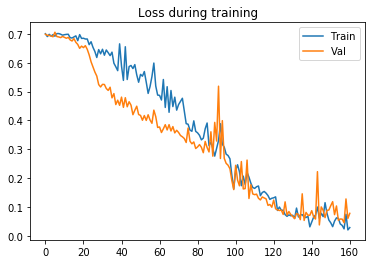

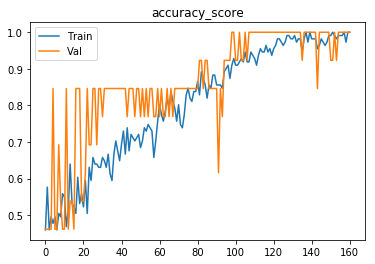

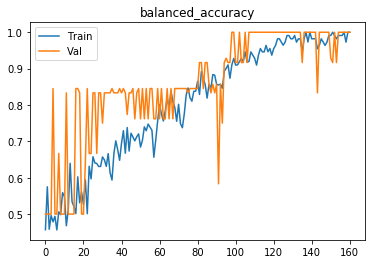

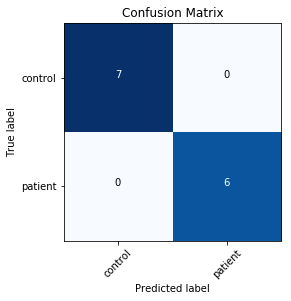

Finished outer fold.
{'final_acc': 1.0, 'best_acc': 1.0, 'final_iter': 200, 'best_iter': 200, 'params': {'model': 'ModelA', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 0}
###### Starting outer fold 4
111
13
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 468521
[0,     5] loss: 0.69937
[0,    10] loss: 0.68448
[0,    15] loss: 0.69956
[0,    20] loss: 0.69458
[0,    25] loss: 0.73099
Time elapsed: 0h:0m:2s
train accuracy_score: 50.45 %
train balanced_accuracy: 48.14 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690039
[1,     5] loss: 0.68511
[1,    10] loss: 0.69240
[1,    15] loss: 0.69353
[1,    20] loss: 0.68860
[1,    25] loss: 0.69241
Time elapsed: 0h:0m:5s
train accuracy_score: 54.05 %
train balanced_accuracy: 52.35 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.689781
[2,     5] loss: 0.68688
[2,    10] loss: 

val accuracy_score: 53.85 %
val balanced_accuracy: 54.76 %
Val loss: 0.657664
[27,     5] loss: 0.57969
[27,    10] loss: 0.66121
[27,    15] loss: 0.69278
[27,    20] loss: 0.60906
[27,    25] loss: 0.62401
Time elapsed: 0h:1m:25s
train accuracy_score: 64.86 %
train balanced_accuracy: 64.12 %
val accuracy_score: 53.85 %
val balanced_accuracy: 52.38 %
Val loss: 0.637080
[28,     5] loss: 0.54834
[28,    10] loss: 0.67037
[28,    15] loss: 0.63433
[28,    20] loss: 0.68198
[28,    25] loss: 0.54828
Time elapsed: 0h:1m:28s
train accuracy_score: 62.16 %
train balanced_accuracy: 61.62 %
val accuracy_score: 61.54 %
val balanced_accuracy: 59.52 %
Val loss: 0.636939
[29,     5] loss: 0.56003
[29,    10] loss: 0.65530
[29,    15] loss: 0.53233
[29,    20] loss: 0.58607
[29,    25] loss: 0.57992
Time elapsed: 0h:1m:31s
train accuracy_score: 64.86 %
train balanced_accuracy: 63.53 %
val accuracy_score: 61.54 %
val balanced_accuracy: 64.29 %
Val loss: 0.694367
[30,     5] loss: 0.54225
[30,    10]

val accuracy_score: 61.54 %
val balanced_accuracy: 63.10 %
Val loss: 0.648787
[55,     5] loss: 0.49978
[55,    10] loss: 0.39840
[55,    15] loss: 0.68426
[55,    20] loss: 0.54778
[55,    25] loss: 0.38619
Time elapsed: 0h:2m:51s
train accuracy_score: 74.77 %
train balanced_accuracy: 75.49 %
val accuracy_score: 61.54 %
val balanced_accuracy: 59.52 %
Val loss: 0.628650
[56,     5] loss: 0.68824
[56,    10] loss: 0.56538
[56,    15] loss: 0.51970
[56,    20] loss: 0.45843
[56,    25] loss: 0.48968
Time elapsed: 0h:2m:54s
train accuracy_score: 75.68 %
train balanced_accuracy: 75.15 %
val accuracy_score: 53.85 %
val balanced_accuracy: 54.76 %
Val loss: 0.630194
[57,     5] loss: 0.40822
[57,    10] loss: 0.72216
[57,    15] loss: 0.40944
[57,    20] loss: 0.48700
[57,    25] loss: 0.73133
Time elapsed: 0h:2m:57s
train accuracy_score: 72.97 %
train balanced_accuracy: 72.79 %
val accuracy_score: 53.85 %
val balanced_accuracy: 54.76 %
Val loss: 0.617504
[58,     5] loss: 0.42642
[58,    10]

val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.542439
[83,     5] loss: 0.34507
[83,    10] loss: 0.25798
[83,    15] loss: 0.40555
[83,    20] loss: 0.25205
[83,    25] loss: 0.39123
Time elapsed: 0h:4m:18s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.30 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.565514
[84,     5] loss: 0.43435
[84,    10] loss: 0.54403
[84,    15] loss: 0.34612
[84,    20] loss: 0.43303
[84,    25] loss: 0.24048
Time elapsed: 0h:4m:21s
train accuracy_score: 81.08 %
train balanced_accuracy: 80.88 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.552591
[85,     5] loss: 0.36544
[85,    10] loss: 0.23938
[85,    15] loss: 0.28814
[85,    20] loss: 0.50258
[85,    25] loss: 0.31043
Time elapsed: 0h:4m:24s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.45 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.86 %
Val loss: 0.544881
[86,     5] loss: 0.41522
[86,    10]

[110,    25] loss: 0.10046
Time elapsed: 0h:5m:39s
train accuracy_score: 92.79 %
train balanced_accuracy: 92.75 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.612276
[111,     5] loss: 0.15531
[111,    10] loss: 0.27926
[111,    15] loss: 0.13808
[111,    20] loss: 0.19659
[111,    25] loss: 0.55699
Time elapsed: 0h:5m:42s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.45 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.518125
[112,     5] loss: 0.20097
[112,    10] loss: 0.11267
[112,    15] loss: 0.15661
[112,    20] loss: 0.31665
[112,    25] loss: 0.33844
Time elapsed: 0h:5m:45s
train accuracy_score: 90.09 %
train balanced_accuracy: 90.25 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.86 %
Val loss: 0.671528
[113,     5] loss: 0.37083
[113,    10] loss: 0.21563
[113,    15] loss: 0.33922
[113,    20] loss: 0.19583
[113,    25] loss: 0.23107
Time elapsed: 0h:5m:48s
train accuracy_score: 87.39 %
train balanced_accu

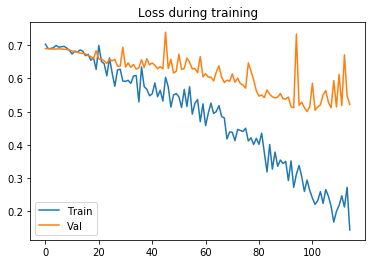

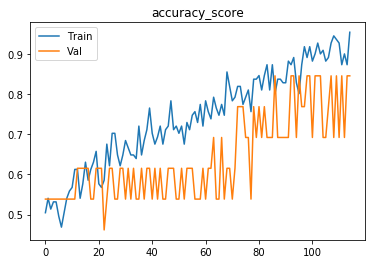

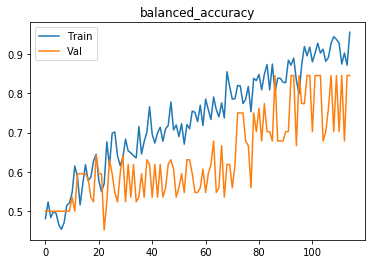

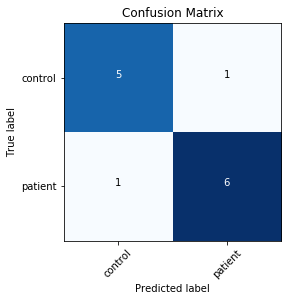

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 468521
[0,     5] loss: 0.69721
Time elapsed: 0h:0m:2s
train accuracy_score: 50.45 %
train balanced_accuracy: 51.96 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691629
[1,     5] loss: 0.69119
Time elapsed: 0h:0m:4s
train accuracy_score: 54.95 %
train balanced_accuracy: 51.13 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690862
[2,     5] loss: 0.69691
Time elapsed: 0h:0m:7s
train accuracy_score: 53.15 %
train balanced_accuracy: 49.31 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691368
[3,     5] loss: 0.68719
Time elapsed: 0h:0m:9s
train accuracy_score: 54.95 %
train balanced_accuracy: 51.72 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691753
[4,     5] loss: 0.69228
Time elapsed: 0h:0m:12s
train accuracy_score: 53.15 %
train balanced_accuracy: 50.05 %
v

val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.658874
[43,     5] loss: 0.63975
Time elapsed: 0h:1m:52s
train accuracy_score: 69.37 %
train balanced_accuracy: 68.43 %
val accuracy_score: 61.54 %
val balanced_accuracy: 59.52 %
Val loss: 0.646841
[44,     5] loss: 0.64811
Time elapsed: 0h:1m:55s
train accuracy_score: 62.16 %
train balanced_accuracy: 61.32 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.658145
[45,     5] loss: 0.63290
Time elapsed: 0h:1m:57s
train accuracy_score: 56.76 %
train balanced_accuracy: 56.32 %
val accuracy_score: 46.15 %
val balanced_accuracy: 45.24 %
Val loss: 0.648945
[46,     5] loss: 0.59058
Time elapsed: 0h:2m:0s
train accuracy_score: 60.36 %
train balanced_accuracy: 60.54 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.655612
[47,     5] loss: 0.60862
Time elapsed: 0h:2m:2s
train accuracy_score: 65.77 %
train balanced_accuracy: 64.51 %
val accuracy_score: 61.54 %
val balanced_accura

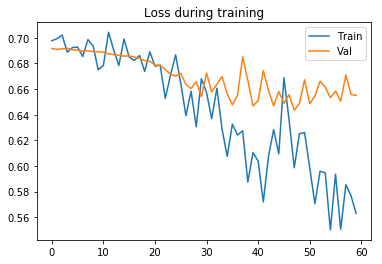

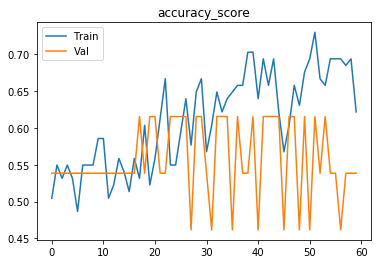

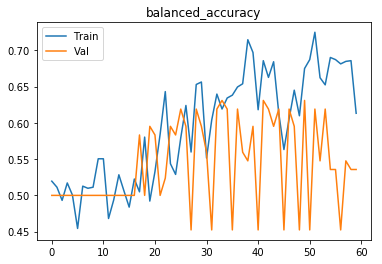

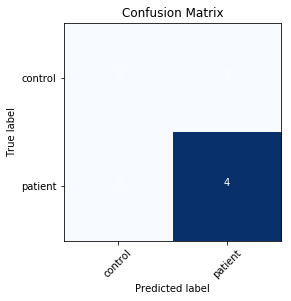

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 621961
[0,     5] loss: 0.70030
[0,    10] loss: 0.67086
[0,    15] loss: 0.76054
[0,    20] loss: 0.67322
[0,    25] loss: 0.70540
Time elapsed: 0h:0m:3s
train accuracy_score: 54.05 %
train balanced_accuracy: 50.59 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.693487
[1,     5] loss: 0.67914
[1,    10] loss: 0.68654
[1,    15] loss: 0.75038
[1,    20] loss: 0.71033
[1,    25] loss: 0.67601
Time elapsed: 0h:0m:7s
train accuracy_score: 55.86 %
train balanced_accuracy: 54.46 %
val accuracy_score: 61.54 %
val balanced_accuracy: 63.10 %
Val loss: 0.690681
[2,     5] loss: 0.71588
[2,    10] loss: 0.67944
[2,    15] loss: 0.70141
[2,    20] loss: 0.68863
[2,    25] loss: 0.69300
Time elapsed: 0h:0m:11s
train accuracy_score: 46.85 %
train balanced_accuracy: 46.86 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.703386
[

val accuracy_score: 61.54 %
val balanced_accuracy: 63.10 %
Val loss: 0.687354
[28,     5] loss: 0.41220
[28,    10] loss: 0.47970
[28,    15] loss: 0.68762
[28,    20] loss: 0.58151
[28,    25] loss: 0.55879
Time elapsed: 0h:1m:54s
train accuracy_score: 74.77 %
train balanced_accuracy: 74.90 %
val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.566887
[29,     5] loss: 0.50390
[29,    10] loss: 0.48218
[29,    15] loss: 0.49391
[29,    20] loss: 0.47840
[29,    25] loss: 0.55621
Time elapsed: 0h:1m:58s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.55 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.86 %
Val loss: 0.577119
[30,     5] loss: 0.47168
[30,    10] loss: 0.48863
[30,    15] loss: 0.52794
[30,    20] loss: 0.59386
[30,    25] loss: 0.59936
Time elapsed: 0h:2m:2s
train accuracy_score: 71.17 %
train balanced_accuracy: 70.98 %
val accuracy_score: 53.85 %
val balanced_accuracy: 55.95 %
Val loss: 0.674174
[31,     5] loss: 0.31604
[31,    10] 

val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.525147
[56,     5] loss: 0.03982
[56,    10] loss: 0.10330
[56,    15] loss: 0.13586
[56,    20] loss: 0.16573
[56,    25] loss: 0.08960
Time elapsed: 0h:3m:46s
train accuracy_score: 96.40 %
train balanced_accuracy: 96.52 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.500460
[57,     5] loss: 0.10890
[57,    10] loss: 0.04988
[57,    15] loss: 0.03352
[57,    20] loss: 0.07690
[57,    25] loss: 0.04803
Time elapsed: 0h:3m:50s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.515078
[58,     5] loss: 0.06501
[58,    10] loss: 0.07815
[58,    15] loss: 0.09315
[58,    20] loss: 0.03279
[58,    25] loss: 0.06451
Time elapsed: 0h:3m:54s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.17 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.590221
[59,     5] loss: 0.02309
[59,    1

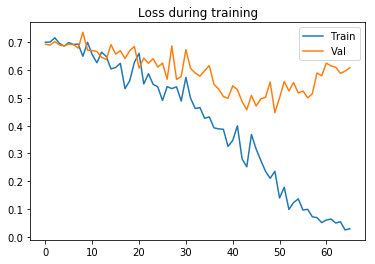

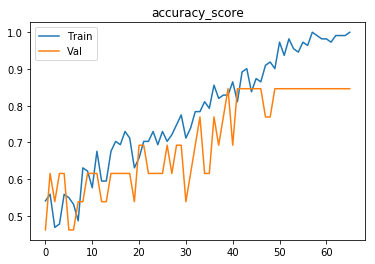

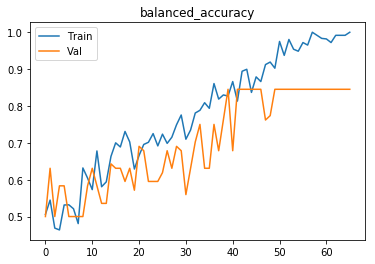

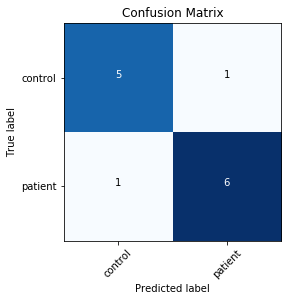

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 621961
[0,     5] loss: 0.69361
Time elapsed: 0h:0m:2s
train accuracy_score: 49.55 %
train balanced_accuracy: 46.42 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690007
[1,     5] loss: 0.68975
Time elapsed: 0h:0m:6s
train accuracy_score: 52.25 %
train balanced_accuracy: 52.60 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691372
[2,     5] loss: 0.70375
Time elapsed: 0h:0m:9s
train accuracy_score: 45.95 %
train balanced_accuracy: 45.44 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691571
[3,     5] loss: 0.70365
Time elapsed: 0h:0m:12s
train accuracy_score: 51.35 %
train balanced_accuracy: 48.09 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.689862
[4,     5] loss: 0.69006
Time elapsed: 0h:0m:15s
train accuracy_score: 52.25 %
train balanced_accuracy: 51.57 %

val accuracy_score: 61.54 %
val balanced_accuracy: 59.52 %
Val loss: 0.584641
[43,     5] loss: 0.57551
Time elapsed: 0h:2m:24s
train accuracy_score: 68.47 %
train balanced_accuracy: 67.60 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.86 %
Val loss: 0.586648
[44,     5] loss: 0.51296
Time elapsed: 0h:2m:27s
train accuracy_score: 74.77 %
train balanced_accuracy: 74.31 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.595693
[45,     5] loss: 0.55945
Time elapsed: 0h:2m:31s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.25 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.582019
[46,     5] loss: 0.54136
Time elapsed: 0h:2m:34s
train accuracy_score: 72.07 %
train balanced_accuracy: 72.25 %
val accuracy_score: 69.23 %
val balanced_accuracy: 66.67 %
Val loss: 0.611480
[47,     5] loss: 0.49390
Time elapsed: 0h:2m:37s
train accuracy_score: 69.37 %
train balanced_accuracy: 68.28 %
val accuracy_score: 53.85 %
val balanced_accu

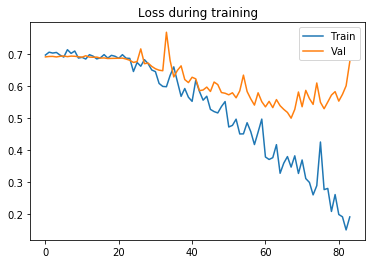

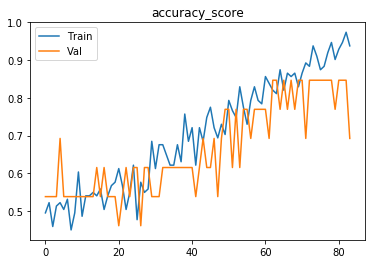

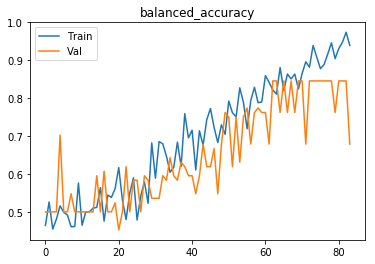

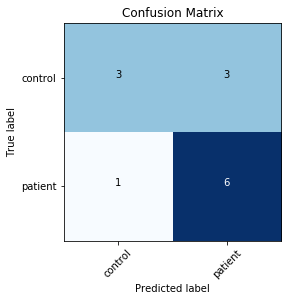

###### Starting inner fold 4
{'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 621961
[0,     5] loss: 0.70575
[0,    10] loss: 0.69461
[0,    15] loss: 0.69609
Time elapsed: 0h:0m:2s
train accuracy_score: 52.25 %
train balanced_accuracy: 51.42 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691198
[1,     5] loss: 0.71587
[1,    10] loss: 0.69412
[1,    15] loss: 0.67065
Time elapsed: 0h:0m:6s
train accuracy_score: 54.05 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690814
[2,     5] loss: 0.69979
[2,    10] loss: 0.69922
[2,    15] loss: 0.69159
Time elapsed: 0h:0m:10s
train accuracy_score: 46.85 %
train balanced_accuracy: 45.10 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.692878
[3,     5] loss: 0.69384
[3,    10] loss: 0.69308
[3,    15] loss: 0.68427
Time elapsed: 0h:0m:13s
train accuracy_score: 57.66 %
train balanced_accurac

Time elapsed: 0h:2m:2s
train accuracy_score: 69.37 %
train balanced_accuracy: 69.17 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.86 %
Val loss: 0.607494
[34,     5] loss: 0.54951
[34,    10] loss: 0.44598
[34,    15] loss: 0.59958
Time elapsed: 0h:2m:6s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.11 %
val accuracy_score: 61.54 %
val balanced_accuracy: 59.52 %
Val loss: 0.634925
[35,     5] loss: 0.58607
[35,    10] loss: 0.44265
[35,    15] loss: 0.42762
Time elapsed: 0h:2m:9s
train accuracy_score: 73.87 %
train balanced_accuracy: 73.77 %
val accuracy_score: 61.54 %
val balanced_accuracy: 59.52 %
Val loss: 0.639779
[36,     5] loss: 0.48403
[36,    10] loss: 0.49017
[36,    15] loss: 0.51445
Time elapsed: 0h:2m:13s
train accuracy_score: 75.68 %
train balanced_accuracy: 75.59 %
val accuracy_score: 61.54 %
val balanced_accuracy: 63.10 %
Val loss: 0.660667
[37,     5] loss: 0.51095
[37,    10] loss: 0.45516
[37,    15] loss: 0.51624
Time elapsed: 0h:2m:17s
train a

Best result during training: 0.85. Saving model..
Finished inner fold.


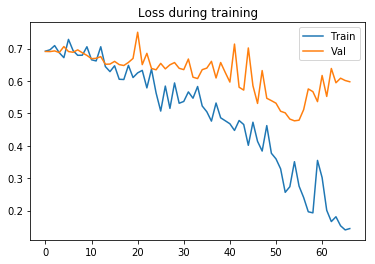

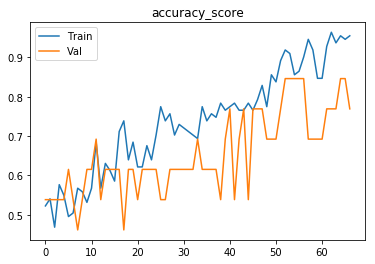

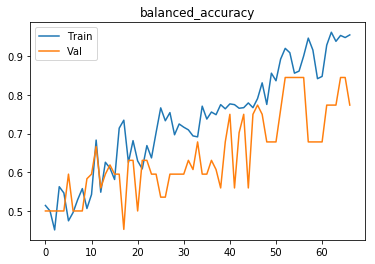

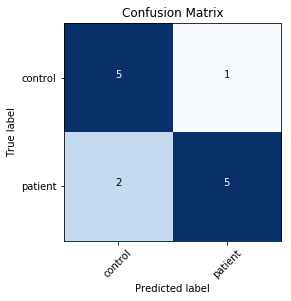

Finished outer fold.
{'final_acc': 0.8452380952380951, 'best_acc': 0.8452380952380951, 'final_iter': 115, 'best_iter': 115, 'params': {'model': 'ModelA', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 0}
###### Starting outer fold 5
111
13
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 468521
[0,     5] loss: 0.71072
[0,    10] loss: 0.69683
[0,    15] loss: 0.69769
[0,    20] loss: 0.69639
[0,    25] loss: 0.68824
Time elapsed: 0h:0m:2s
train accuracy_score: 43.24 %
train balanced_accuracy: 41.62 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691873
[1,     5] loss: 0.71279
[1,    10] loss: 0.67476
[1,    15] loss: 0.69200
[1,    20] loss: 0.71374
[1,    25] loss: 0.65927
Time elapsed: 0h:0m:5s
train accuracy_score: 54.95 %
train balanced_accuracy: 51.42 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690891
[2,     5] lo

val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.687467
[27,     5] loss: 0.63711
[27,    10] loss: 0.52759
[27,    15] loss: 0.45610
[27,    20] loss: 0.58193
[27,    25] loss: 0.65084
Time elapsed: 0h:1m:21s
train accuracy_score: 69.37 %
train balanced_accuracy: 69.46 %
val accuracy_score: 53.85 %
val balanced_accuracy: 55.95 %
Val loss: 0.761348
[28,     5] loss: 0.64416
[28,    10] loss: 0.43831
[28,    15] loss: 0.63195
[28,    20] loss: 0.72498
[28,    25] loss: 0.52789
Time elapsed: 0h:1m:24s
train accuracy_score: 70.27 %
train balanced_accuracy: 70.00 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.708414
[29,     5] loss: 0.68560
[29,    10] loss: 0.53086
[29,    15] loss: 0.51726
[29,    20] loss: 0.65503
[29,    25] loss: 0.61918
Time elapsed: 0h:1m:27s
train accuracy_score: 69.37 %
train balanced_accuracy: 69.61 %
val accuracy_score: 53.85 %
val balanced_accuracy: 53.57 %
Val loss: 0.696852
[30,     5] loss: 0.47501
[30,    10]

val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 1.234981
[55,     5] loss: 0.27083
[55,    10] loss: 0.26234
[55,    15] loss: 0.22398
[55,    20] loss: 0.33153
[55,    25] loss: 0.20785
Time elapsed: 0h:2m:44s
train accuracy_score: 90.09 %
train balanced_accuracy: 90.10 %
val accuracy_score: 53.85 %
val balanced_accuracy: 53.57 %
Val loss: 1.138291
[56,     5] loss: 0.20497
[56,    10] loss: 0.25962
[56,    15] loss: 0.26035
[56,    20] loss: 0.13794
[56,    25] loss: 0.34930
Time elapsed: 0h:2m:47s
train accuracy_score: 90.09 %
train balanced_accuracy: 90.10 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 1.183285
[57,     5] loss: 0.16931
[57,    10] loss: 0.23200
[57,    15] loss: 0.28353
[57,    20] loss: 0.27368
[57,    25] loss: 0.16370
Time elapsed: 0h:2m:50s
train accuracy_score: 93.69 %
train balanced_accuracy: 93.73 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 1.204068
[58,     5] loss: 0.18494
[58,    10]

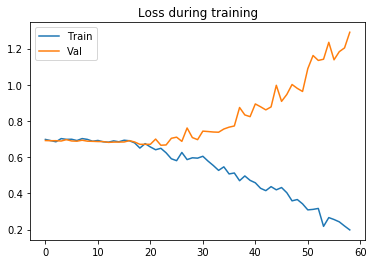

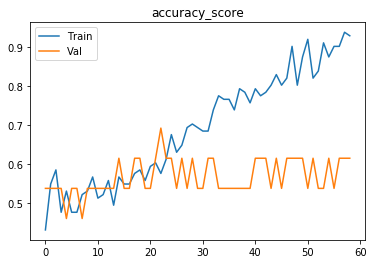

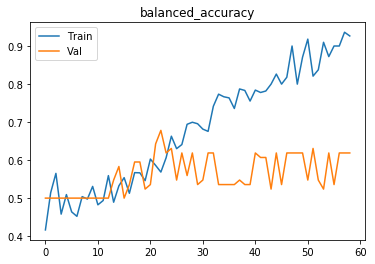

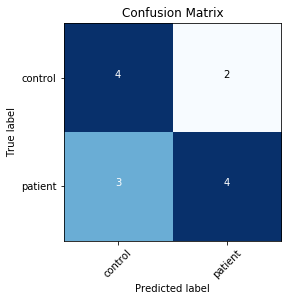

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 468521
[0,     5] loss: 0.69522
[0,    10] loss: 0.66594
[0,    15] loss: 0.65824
[0,    20] loss: 0.70591
[0,    25] loss: 0.67295
Time elapsed: 0h:0m:2s
train accuracy_score: 53.15 %
train balanced_accuracy: 51.37 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.701802
[1,     5] loss: 0.75915
[1,    10] loss: 0.67286
[1,    15] loss: 0.72210
[1,    20] loss: 0.69867
[1,    25] loss: 0.73601
Time elapsed: 0h:0m:5s
train accuracy_score: 50.45 %
train balanced_accuracy: 47.25 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691742
[2,     5] loss: 0.71750
[2,    10] loss: 0.69276
[2,    15] loss: 0.72565
[2,    20] loss: 0.68167
[2,    25] loss: 0.71552
Time elapsed: 0h:0m:8s
train accuracy_score: 45.05 %
train balanced_accuracy: 43.73 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691318
[3

val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.674515
[28,     5] loss: 0.67503
[28,    10] loss: 0.65870
[28,    15] loss: 0.70016
[28,    20] loss: 0.65690
[28,    25] loss: 0.63664
Time elapsed: 0h:1m:25s
train accuracy_score: 55.86 %
train balanced_accuracy: 53.14 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.676139
[29,     5] loss: 0.66551
[29,    10] loss: 0.69946
[29,    15] loss: 0.64021
[29,    20] loss: 0.70967
[29,    25] loss: 0.58434
Time elapsed: 0h:1m:28s
train accuracy_score: 64.86 %
train balanced_accuracy: 64.41 %
val accuracy_score: 53.85 %
val balanced_accuracy: 53.57 %
Val loss: 0.670904
[30,     5] loss: 0.65207
[30,    10] loss: 0.65285
[30,    15] loss: 0.64193
[30,    20] loss: 0.64482
[30,    25] loss: 0.63352
Time elapsed: 0h:1m:31s
train accuracy_score: 67.57 %
train balanced_accuracy: 66.18 %
val accuracy_score: 46.15 %
val balanced_accuracy: 44.05 %
Val loss: 0.670670
[31,     5] loss: 0.65248
[31,    10]

val accuracy_score: 69.23 %
val balanced_accuracy: 71.43 %
Val loss: 0.775988
[56,     5] loss: 0.40145
[56,    10] loss: 0.45445
[56,    15] loss: 0.43868
[56,    20] loss: 0.49674
[56,    25] loss: 0.30315
Time elapsed: 0h:2m:48s
train accuracy_score: 83.78 %
train balanced_accuracy: 83.97 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.647412
[57,     5] loss: 0.47061
[57,    10] loss: 0.27541
[57,    15] loss: 0.32765
[57,    20] loss: 0.27643
[57,    25] loss: 0.32021
Time elapsed: 0h:2m:51s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.60 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.638373
[58,     5] loss: 0.22343
[58,    10] loss: 0.24419
[58,    15] loss: 0.42081
[58,    20] loss: 0.40023
[58,    25] loss: 0.25738
Time elapsed: 0h:2m:54s
train accuracy_score: 88.29 %
train balanced_accuracy: 88.14 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.637183
[59,     5] loss: 0.27224
[59,    10]

val accuracy_score: 61.54 %
val balanced_accuracy: 60.71 %
Val loss: 0.622132
[84,     5] loss: 0.07242
[84,    10] loss: 0.07743
[84,    15] loss: 0.03222
[84,    20] loss: 0.11949
[84,    25] loss: 0.01345
Time elapsed: 0h:4m:11s
train accuracy_score: 96.40 %
train balanced_accuracy: 96.37 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.86 %
Val loss: 0.669156
[85,     5] loss: 0.03591
[85,    10] loss: 0.06553
[85,    15] loss: 0.03246
[85,    20] loss: 0.07395
[85,    25] loss: 0.03755
Time elapsed: 0h:4m:14s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.17 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.651878
[86,     5] loss: 0.04833
[86,    10] loss: 0.04009
[86,    15] loss: 0.10533
[86,    20] loss: 0.08054
[86,    25] loss: 0.07793
Time elapsed: 0h:4m:17s
train accuracy_score: 96.40 %
train balanced_accuracy: 96.52 %
val accuracy_score: 61.54 %
val balanced_accuracy: 60.71 %
Val loss: 0.671011
[87,     5] loss: 0.02183
[87,    10]

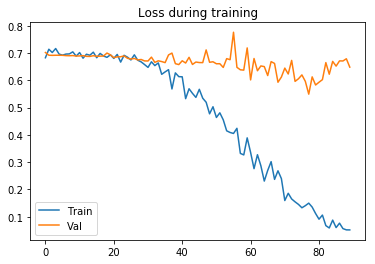

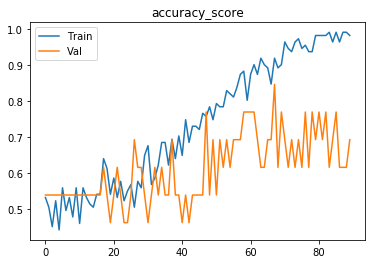

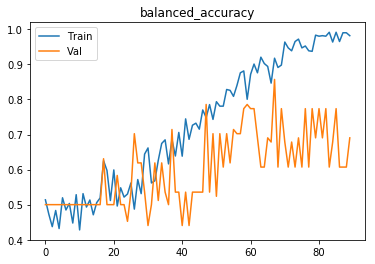

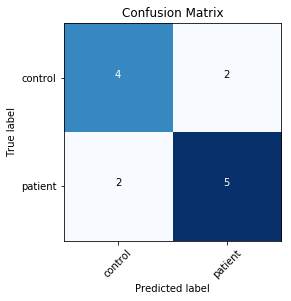

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 621961
[0,     5] loss: 0.69056
Time elapsed: 0h:0m:2s
train accuracy_score: 54.95 %
train balanced_accuracy: 50.98 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691150
[1,     5] loss: 0.69102
Time elapsed: 0h:0m:5s
train accuracy_score: 53.15 %
train balanced_accuracy: 49.17 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691318
[2,     5] loss: 0.69255
Time elapsed: 0h:0m:9s
train accuracy_score: 55.86 %
train balanced_accuracy: 52.40 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691047
[3,     5] loss: 0.69950
Time elapsed: 0h:0m:12s
train accuracy_score: 49.55 %
train balanced_accuracy: 47.30 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691407
[4,     5] loss: 0.68698
Time elapsed: 0h:0m:15s
train accuracy_score: 54.95 %
train balanced_accuracy: 50.98 %


val accuracy_score: 53.85 %
val balanced_accuracy: 53.57 %
Val loss: 0.641868
[43,     5] loss: 0.59656
Time elapsed: 0h:2m:20s
train accuracy_score: 71.17 %
train balanced_accuracy: 70.54 %
val accuracy_score: 53.85 %
val balanced_accuracy: 53.57 %
Val loss: 0.641363
[44,     5] loss: 0.64275
Time elapsed: 0h:2m:24s
train accuracy_score: 59.46 %
train balanced_accuracy: 59.85 %
val accuracy_score: 53.85 %
val balanced_accuracy: 53.57 %
Val loss: 0.641028
[45,     5] loss: 0.66321
Time elapsed: 0h:2m:27s
train accuracy_score: 63.06 %
train balanced_accuracy: 60.83 %
val accuracy_score: 53.85 %
val balanced_accuracy: 53.57 %
Val loss: 0.638464
[46,     5] loss: 0.56673
Time elapsed: 0h:2m:30s
train accuracy_score: 65.77 %
train balanced_accuracy: 65.98 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.650919
[47,     5] loss: 0.58855
Time elapsed: 0h:2m:33s
train accuracy_score: 67.57 %
train balanced_accuracy: 68.68 %
val accuracy_score: 61.54 %
val balanced_accu

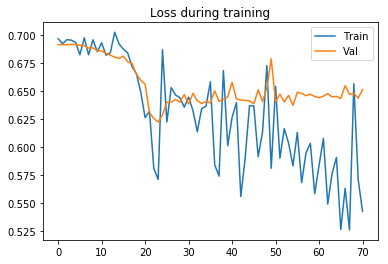

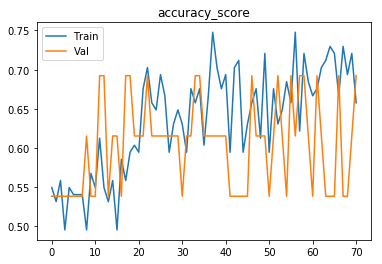

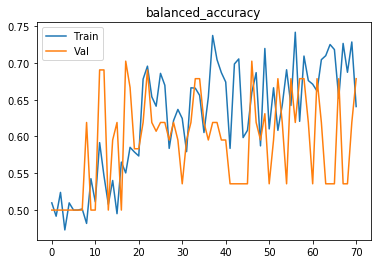

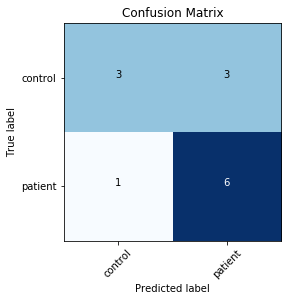

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 621961
[0,     5] loss: 0.69780
[0,    10] loss: 0.69557
[0,    15] loss: 0.67409
[0,    20] loss: 0.71254
[0,    25] loss: 0.67443
Time elapsed: 0h:0m:3s
train accuracy_score: 54.05 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690011
[1,     5] loss: 0.66246
[1,    10] loss: 0.73280
[1,    15] loss: 0.69678
[1,    20] loss: 0.67041
[1,    25] loss: 0.70448
Time elapsed: 0h:0m:7s
train accuracy_score: 54.05 %
train balanced_accuracy: 50.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.689213
[2,     5] loss: 0.70413
[2,    10] loss: 0.70055
[2,    15] loss: 0.70620
[2,    20] loss: 0.70108
[2,    25] loss: 0.67982
Time elapsed: 0h:0m:11s
train accuracy_score: 44.14 %
train balanced_accuracy: 43.63 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691090
[3

val accuracy_score: 61.54 %
val balanced_accuracy: 59.52 %
Val loss: 0.653931
[28,     5] loss: 0.50235
[28,    10] loss: 0.60162
[28,    15] loss: 0.47620
[28,    20] loss: 0.50088
[28,    25] loss: 0.56418
Time elapsed: 0h:1m:52s
train accuracy_score: 71.17 %
train balanced_accuracy: 71.57 %
val accuracy_score: 61.54 %
val balanced_accuracy: 59.52 %
Val loss: 0.688536
[29,     5] loss: 0.72944
[29,    10] loss: 0.67956
[29,    15] loss: 0.54207
[29,    20] loss: 0.59090
[29,    25] loss: 0.47844
Time elapsed: 0h:1m:56s
train accuracy_score: 67.57 %
train balanced_accuracy: 65.88 %
val accuracy_score: 53.85 %
val balanced_accuracy: 53.57 %
Val loss: 0.647341
[30,     5] loss: 0.55538
[30,    10] loss: 0.62894
[30,    15] loss: 0.59371
[30,    20] loss: 0.49017
[30,    25] loss: 0.63864
Time elapsed: 0h:2m:0s
train accuracy_score: 64.86 %
train balanced_accuracy: 64.26 %
val accuracy_score: 61.54 %
val balanced_accuracy: 59.52 %
Val loss: 0.657147
[31,     5] loss: 0.63899
[31,    10] 

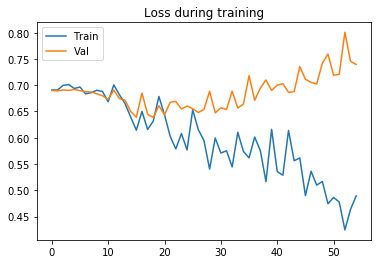

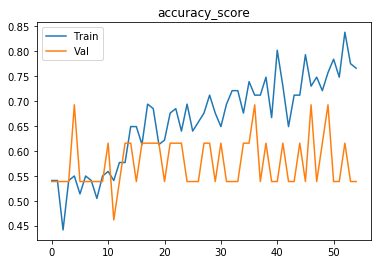

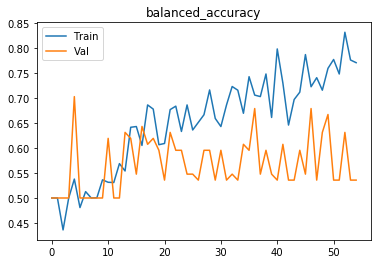

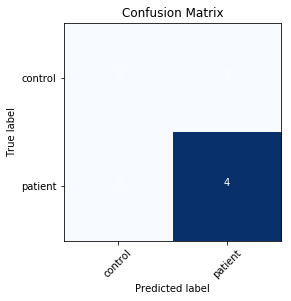

###### Starting inner fold 4
{'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 621961
[0,     5] loss: 0.68228
[0,    10] loss: 0.74136
[0,    15] loss: 0.70346
[0,    20] loss: 0.71985
[0,    25] loss: 0.69354
Time elapsed: 0h:0m:3s
train accuracy_score: 43.24 %
train balanced_accuracy: 42.06 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.695182
[1,     5] loss: 0.69439
[1,    10] loss: 0.68182
[1,    15] loss: 0.75267
[1,    20] loss: 0.69801
[1,    25] loss: 0.69513
Time elapsed: 0h:0m:7s
train accuracy_score: 47.75 %
train balanced_accuracy: 45.64 %
val accuracy_score: 38.46 %
val balanced_accuracy: 36.90 %
Val loss: 0.693277
[2,     5] loss: 0.68510
[2,    10] loss: 0.68127
[2,    15] loss: 0.70170
[2,    20] loss: 0.69776
[2,    25] loss: 0.67512
Time elapsed: 0h:0m:11s
train accuracy_score: 54.95 %
train balanced_accuracy: 54.36 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.701298
[

val accuracy_score: 53.85 %
val balanced_accuracy: 53.57 %
Val loss: 0.675472
[28,     5] loss: 0.51991
[28,    10] loss: 0.54451
[28,    15] loss: 0.45316
[28,    20] loss: 0.62646
[28,    25] loss: 0.48557
Time elapsed: 0h:1m:54s
train accuracy_score: 74.77 %
train balanced_accuracy: 74.17 %
val accuracy_score: 53.85 %
val balanced_accuracy: 53.57 %
Val loss: 0.711197
[29,     5] loss: 0.49080
[29,    10] loss: 0.58858
[29,    15] loss: 0.62104
[29,    20] loss: 0.59485
[29,    25] loss: 0.62527
Time elapsed: 0h:1m:58s
train accuracy_score: 72.97 %
train balanced_accuracy: 73.09 %
val accuracy_score: 53.85 %
val balanced_accuracy: 53.57 %
Val loss: 0.677889
[30,     5] loss: 0.64105
[30,    10] loss: 0.47752
[30,    15] loss: 0.46080
[30,    20] loss: 0.63008
[30,    25] loss: 0.50685
Time elapsed: 0h:2m:2s
train accuracy_score: 71.17 %
train balanced_accuracy: 69.95 %
val accuracy_score: 53.85 %
val balanced_accuracy: 53.57 %
Val loss: 0.695153
[31,     5] loss: 0.48423
[31,    10] 

val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 1.131820
[56,     5] loss: 0.06630
[56,    10] loss: 0.20341
[56,    15] loss: 0.03774
[56,    20] loss: 0.06375
[56,    25] loss: 0.07715
Time elapsed: 0h:3m:43s
train accuracy_score: 96.40 %
train balanced_accuracy: 96.52 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 1.085606
Early stopping in epoch 57
Total time elapsed: 0h:3m:44s
Writing model to disk...
Best result during training: 0.77. Saving model..
Finished inner fold.


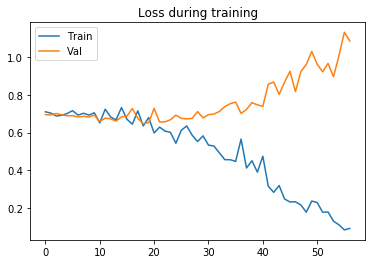

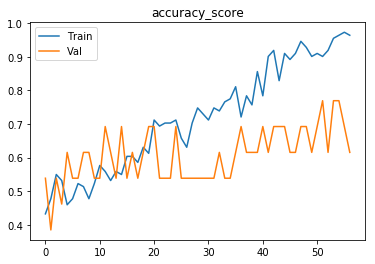

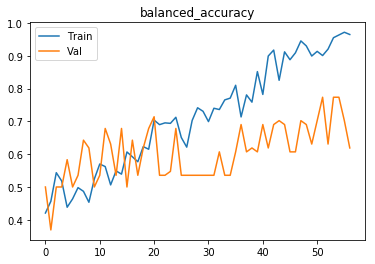

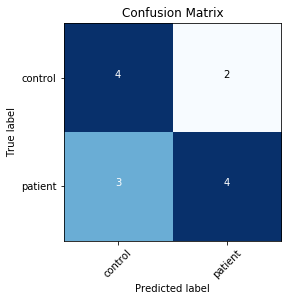

Finished outer fold.
{'final_acc': 0.6190476190476191, 'best_acc': 0.7738095238095238, 'final_iter': 57, 'best_iter': 55, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 4}
###### Starting outer fold 6
111
13
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 468521
[0,     5] loss: 0.70138
[0,    10] loss: 0.70523
[0,    15] loss: 0.70189
[0,    20] loss: 0.69189
[0,    25] loss: 0.70509
Time elapsed: 0h:0m:2s
train accuracy_score: 38.74 %
train balanced_accuracy: 40.00 %
val accuracy_score: 84.62 %
val balanced_accuracy: 50.00 %
Val loss: 0.685695
[1,     5] loss: 0.69753
[1,    10] loss: 0.69977
[1,    15] loss: 0.69285
[1,    20] loss: 0.68986
[1,    25] loss: 0.68425
Time elapsed: 0h:0m:4s
train accuracy_score: 47.75 %
train balanced_accuracy: 48.29 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 0.702688
[2,     5] loss

val accuracy_score: 53.85 %
val balanced_accuracy: 31.82 %
Val loss: 0.667762
[27,     5] loss: 0.69908
[27,    10] loss: 0.59016
[27,    15] loss: 0.64450
[27,    20] loss: 0.66508
[27,    25] loss: 0.67332
Time elapsed: 0h:1m:14s
train accuracy_score: 57.66 %
train balanced_accuracy: 58.10 %
val accuracy_score: 23.08 %
val balanced_accuracy: 54.55 %
Val loss: 0.797492
[28,     5] loss: 0.63782
[28,    10] loss: 0.58726
[28,    15] loss: 0.75357
[28,    20] loss: 0.69443
[28,    25] loss: 0.70109
Time elapsed: 0h:1m:16s
train accuracy_score: 58.56 %
train balanced_accuracy: 57.66 %
val accuracy_score: 38.46 %
val balanced_accuracy: 43.18 %
Val loss: 0.702769
[29,     5] loss: 0.61252
[29,    10] loss: 0.66988
[29,    15] loss: 0.66422
[29,    20] loss: 0.61503
[29,    25] loss: 0.69778
Time elapsed: 0h:1m:19s
train accuracy_score: 56.76 %
train balanced_accuracy: 56.59 %
val accuracy_score: 23.08 %
val balanced_accuracy: 54.55 %
Val loss: 0.845802
[30,     5] loss: 0.66048
[30,    10]

val accuracy_score: 61.54 %
val balanced_accuracy: 77.27 %
Val loss: 0.701196
[55,     5] loss: 0.43045
[55,    10] loss: 0.52934
[55,    15] loss: 0.50761
[55,    20] loss: 0.49579
[55,    25] loss: 0.55943
Time elapsed: 0h:2m:28s
train accuracy_score: 74.77 %
train balanced_accuracy: 74.40 %
val accuracy_score: 53.85 %
val balanced_accuracy: 31.82 %
Val loss: 0.578653
[56,     5] loss: 0.54456
[56,    10] loss: 0.56790
[56,    15] loss: 0.66856
[56,    20] loss: 0.43830
[56,    25] loss: 0.55136
Time elapsed: 0h:2m:30s
train accuracy_score: 72.07 %
train balanced_accuracy: 72.06 %
val accuracy_score: 30.77 %
val balanced_accuracy: 59.09 %
Val loss: 0.925277
[57,     5] loss: 0.65515
[57,    10] loss: 0.47767
[57,    15] loss: 0.69631
[57,    20] loss: 0.51473
[57,    25] loss: 0.41904
Time elapsed: 0h:2m:33s
train accuracy_score: 72.97 %
train balanced_accuracy: 72.76 %
val accuracy_score: 76.92 %
val balanced_accuracy: 45.45 %
Val loss: 0.492170
[58,     5] loss: 0.76259
[58,    10]

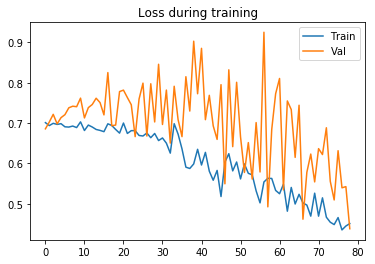

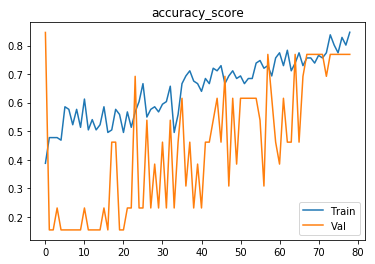

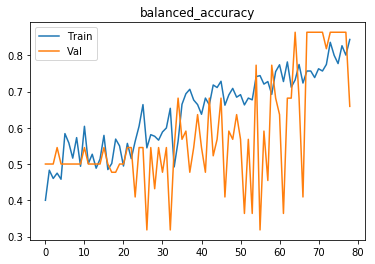

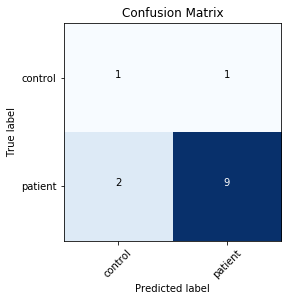

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 468521
[0,     5] loss: 0.71016
[0,    10] loss: 0.71615
[0,    15] loss: 0.69026
[0,    20] loss: 0.70531
[0,    25] loss: 0.70000
Time elapsed: 0h:0m:2s
train accuracy_score: 43.24 %
train balanced_accuracy: 42.36 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 0.699067
[1,     5] loss: 0.69439
[1,    10] loss: 0.70810
[1,    15] loss: 0.68889
[1,    20] loss: 0.70295
[1,    25] loss: 0.74935
Time elapsed: 0h:0m:4s
train accuracy_score: 50.45 %
train balanced_accuracy: 49.82 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 0.722987
[2,     5] loss: 0.69226
[2,    10] loss: 0.68668
[2,    15] loss: 0.68910
[2,    20] loss: 0.70445
[2,    25] loss: 0.70626
Time elapsed: 0h:0m:7s
train accuracy_score: 51.35 %
train balanced_accuracy: 51.25 %
val accuracy_score: 30.77 %
val balanced_accuracy: 59.09 %
Val loss: 0.697306
[3

val accuracy_score: 23.08 %
val balanced_accuracy: 54.55 %
Val loss: 0.859656
[28,     5] loss: 0.56500
[28,    10] loss: 0.52601
[28,    15] loss: 0.61052
[28,    20] loss: 0.63170
[28,    25] loss: 0.38070
Time elapsed: 0h:1m:16s
train accuracy_score: 72.97 %
train balanced_accuracy: 72.84 %
val accuracy_score: 46.15 %
val balanced_accuracy: 68.18 %
Val loss: 0.786402
[29,     5] loss: 0.59638
[29,    10] loss: 0.73372
[29,    15] loss: 0.51466
[29,    20] loss: 0.50184
[29,    25] loss: 0.57490
Time elapsed: 0h:1m:19s
train accuracy_score: 68.47 %
train balanced_accuracy: 67.96 %
val accuracy_score: 69.23 %
val balanced_accuracy: 40.91 %
Val loss: 0.545931
[30,     5] loss: 0.62265
[30,    10] loss: 0.54055
[30,    15] loss: 0.48876
[30,    20] loss: 0.69756
[30,    25] loss: 0.59052
Time elapsed: 0h:1m:22s
train accuracy_score: 68.47 %
train balanced_accuracy: 68.45 %
val accuracy_score: 61.54 %
val balanced_accuracy: 36.36 %
Val loss: 0.563887
[31,     5] loss: 0.52275
[31,    10]

val accuracy_score: 76.92 %
val balanced_accuracy: 86.36 %
Val loss: 0.332074
[56,     5] loss: 0.23920
[56,    10] loss: 0.21375
[56,    15] loss: 0.26223
[56,    20] loss: 0.42876
[56,    25] loss: 0.18151
Time elapsed: 0h:2m:30s
train accuracy_score: 82.88 %
train balanced_accuracy: 82.81 %
val accuracy_score: 84.62 %
val balanced_accuracy: 90.91 %
Val loss: 0.326414
[57,     5] loss: 0.13441
[57,    10] loss: 0.14217
[57,    15] loss: 0.08656
[57,    20] loss: 0.13375
[57,    25] loss: 0.10118
Time elapsed: 0h:2m:33s
train accuracy_score: 97.30 %
train balanced_accuracy: 97.25 %
val accuracy_score: 92.31 %
val balanced_accuracy: 95.45 %
Val loss: 0.201106
[58,     5] loss: 0.17928
[58,    10] loss: 0.16996
[58,    15] loss: 0.26331
[58,    20] loss: 0.27221
[58,    25] loss: 0.13787
Time elapsed: 0h:2m:36s
train accuracy_score: 90.09 %
train balanced_accuracy: 89.95 %
val accuracy_score: 92.31 %
val balanced_accuracy: 95.45 %
Val loss: 0.123378
[59,     5] loss: 0.09430
[59,    10]

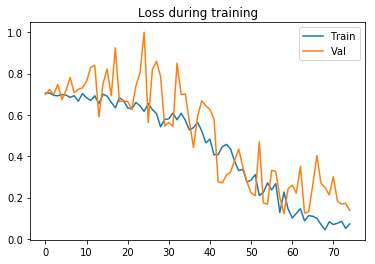

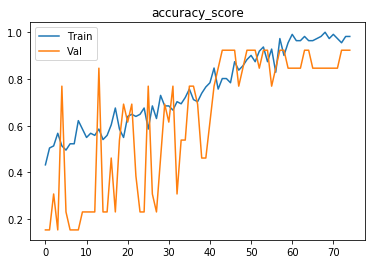

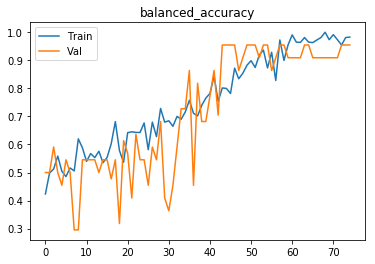

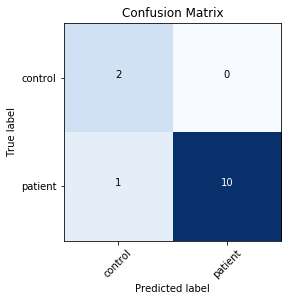

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 621961
[0,     5] loss: 0.69450
[0,    10] loss: 0.69993
[0,    15] loss: 0.67786
[0,    20] loss: 0.72049
[0,    25] loss: 0.69513
Time elapsed: 0h:0m:3s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.24 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 0.718686
[1,     5] loss: 0.68495
[1,    10] loss: 0.71136
[1,    15] loss: 0.69737
[1,    20] loss: 0.68729
[1,    25] loss: 0.70885
Time elapsed: 0h:0m:6s
train accuracy_score: 51.35 %
train balanced_accuracy: 50.03 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 0.760719
[2,     5] loss: 0.71165
[2,    10] loss: 0.63613
[2,    15] loss: 0.77619
[2,    20] loss: 0.66993
[2,    25] loss: 0.71924
Time elapsed: 0h:0m:10s
train accuracy_score: 50.45 %
train balanced_accuracy: 48.28 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 0.716123
[3

val accuracy_score: 53.85 %
val balanced_accuracy: 31.82 %
Val loss: 0.641015
[28,     5] loss: 0.62163
[28,    10] loss: 0.70393
[28,    15] loss: 0.60181
[28,    20] loss: 0.58615
[28,    25] loss: 0.47554
Time elapsed: 0h:1m:45s
train accuracy_score: 72.07 %
train balanced_accuracy: 72.06 %
val accuracy_score: 23.08 %
val balanced_accuracy: 54.55 %
Val loss: 1.092546
[29,     5] loss: 0.61683
[29,    10] loss: 0.67294
[29,    15] loss: 0.48640
[29,    20] loss: 0.66069
[29,    25] loss: 0.56273
Time elapsed: 0h:1m:49s
train accuracy_score: 63.96 %
train balanced_accuracy: 63.57 %
val accuracy_score: 38.46 %
val balanced_accuracy: 43.18 %
Val loss: 0.755417
[30,     5] loss: 0.55482
[30,    10] loss: 0.65470
[30,    15] loss: 0.72557
[30,    20] loss: 0.54798
[30,    25] loss: 0.63844
Time elapsed: 0h:1m:52s
train accuracy_score: 64.86 %
train balanced_accuracy: 64.75 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 1.231630
[31,     5] loss: 0.51572
[31,    10]

val accuracy_score: 61.54 %
val balanced_accuracy: 77.27 %
Val loss: 0.763002
[56,     5] loss: 0.46975
[56,    10] loss: 0.52851
[56,    15] loss: 0.52490
[56,    20] loss: 0.41730
[56,    25] loss: 0.63077
Time elapsed: 0h:3m:27s
train accuracy_score: 74.77 %
train balanced_accuracy: 74.40 %
val accuracy_score: 69.23 %
val balanced_accuracy: 40.91 %
Val loss: 0.513275
[57,     5] loss: 0.37332
[57,    10] loss: 0.51700
[57,    15] loss: 0.75834
[57,    20] loss: 0.44004
[57,    25] loss: 0.56878
Time elapsed: 0h:3m:31s
train accuracy_score: 73.87 %
train balanced_accuracy: 73.62 %
val accuracy_score: 76.92 %
val balanced_accuracy: 65.91 %
Val loss: 0.552778
[58,     5] loss: 0.52775
[58,    10] loss: 0.54790
[58,    15] loss: 0.39914
[58,    20] loss: 0.38675
[58,    25] loss: 0.65240
Time elapsed: 0h:3m:35s
train accuracy_score: 72.07 %
train balanced_accuracy: 71.49 %
val accuracy_score: 76.92 %
val balanced_accuracy: 86.36 %
Val loss: 0.607772
[59,     5] loss: 0.44902
[59,    10]

val accuracy_score: 84.62 %
val balanced_accuracy: 90.91 %
Val loss: 0.311239
[84,     5] loss: 0.23401
[84,    10] loss: 0.12340
[84,    15] loss: 0.26635
[84,    20] loss: 0.06660
[84,    25] loss: 0.16266
Time elapsed: 0h:5m:10s
train accuracy_score: 94.59 %
train balanced_accuracy: 94.50 %
val accuracy_score: 76.92 %
val balanced_accuracy: 86.36 %
Val loss: 0.582126
[85,     5] loss: 0.22643
[85,    10] loss: 0.20735
[85,    15] loss: 0.20307
[85,    20] loss: 0.20838
[85,    25] loss: 0.09975
Time elapsed: 0h:5m:14s
train accuracy_score: 93.69 %
train balanced_accuracy: 93.64 %
val accuracy_score: 76.92 %
val balanced_accuracy: 86.36 %
Val loss: 0.521073
[86,     5] loss: 0.27223
[86,    10] loss: 0.28191
[86,    15] loss: 0.25206
[86,    20] loss: 0.08166
[86,    25] loss: 0.13355
Time elapsed: 0h:5m:17s
train accuracy_score: 90.99 %
train balanced_accuracy: 90.81 %
val accuracy_score: 84.62 %
val balanced_accuracy: 90.91 %
Val loss: 0.324904
[87,     5] loss: 0.10424
[87,    10]

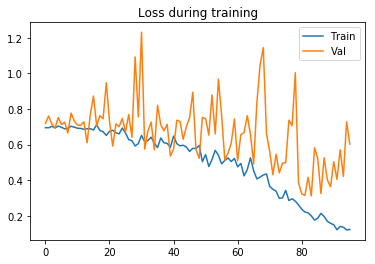

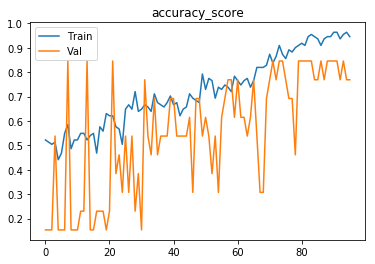

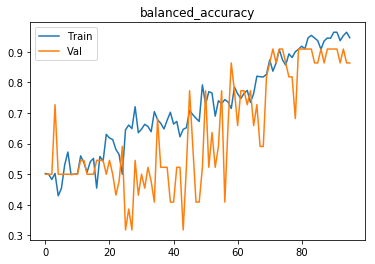

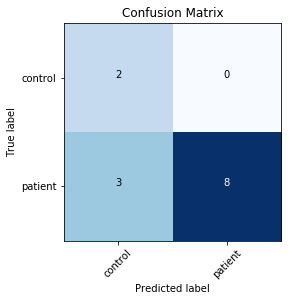

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 621961
[0,     5] loss: 0.69463
[0,    10] loss: 0.67806
[0,    15] loss: 0.70970
[0,    20] loss: 0.69016
[0,    25] loss: 0.71474
Time elapsed: 0h:0m:3s
train accuracy_score: 51.35 %
train balanced_accuracy: 49.14 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 0.730867
[1,     5] loss: 0.69630
[1,    10] loss: 0.70120
[1,    15] loss: 0.68838
[1,    20] loss: 0.70334
[1,    25] loss: 0.68705
Time elapsed: 0h:0m:6s
train accuracy_score: 49.55 %
train balanced_accuracy: 47.74 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 0.712261
[2,     5] loss: 0.68548
[2,    10] loss: 0.70143
[2,    15] loss: 0.70973
[2,    20] loss: 0.66634
[2,    25] loss: 0.71998
Time elapsed: 0h:0m:10s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.08 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 0.730125
[3

val accuracy_score: 38.46 %
val balanced_accuracy: 43.18 %
Val loss: 0.761055
[28,     5] loss: 0.58971
[28,    10] loss: 0.62817
[28,    15] loss: 0.55026
[28,    20] loss: 0.51412
[28,    25] loss: 0.65660
Time elapsed: 0h:1m:45s
train accuracy_score: 67.57 %
train balanced_accuracy: 67.26 %
val accuracy_score: 53.85 %
val balanced_accuracy: 31.82 %
Val loss: 0.646448
[29,     5] loss: 0.69627
[29,    10] loss: 0.48878
[29,    15] loss: 0.55646
[29,    20] loss: 0.56415
[29,    25] loss: 0.49779
Time elapsed: 0h:1m:49s
train accuracy_score: 70.27 %
train balanced_accuracy: 69.93 %
val accuracy_score: 61.54 %
val balanced_accuracy: 56.82 %
Val loss: 0.699708
[30,     5] loss: 0.57455
[30,    10] loss: 0.61360
[30,    15] loss: 0.47671
[30,    20] loss: 0.65697
[30,    25] loss: 0.62490
Time elapsed: 0h:1m:53s
train accuracy_score: 69.37 %
train balanced_accuracy: 69.39 %
val accuracy_score: 53.85 %
val balanced_accuracy: 31.82 %
Val loss: 0.639067
[31,     5] loss: 0.56289
[31,    10]

val accuracy_score: 76.92 %
val balanced_accuracy: 86.36 %
Val loss: 0.548110
[56,     5] loss: 0.41419
[56,    10] loss: 0.46530
[56,    15] loss: 0.53758
[56,    20] loss: 0.51048
[56,    25] loss: 0.56808
Time elapsed: 0h:3m:28s
train accuracy_score: 73.87 %
train balanced_accuracy: 73.86 %
val accuracy_score: 69.23 %
val balanced_accuracy: 81.82 %
Val loss: 0.659228
[57,     5] loss: 0.63105
[57,    10] loss: 0.45122
[57,    15] loss: 0.47797
[57,    20] loss: 0.40384
[57,    25] loss: 0.42124
Time elapsed: 0h:3m:32s
train accuracy_score: 78.38 %
train balanced_accuracy: 78.33 %
val accuracy_score: 76.92 %
val balanced_accuracy: 86.36 %
Val loss: 0.516905
[58,     5] loss: 0.50417
[58,    10] loss: 0.48654
[58,    15] loss: 0.39321
[58,    20] loss: 0.38752
[58,    25] loss: 0.46778
Time elapsed: 0h:3m:35s
train accuracy_score: 79.28 %
train balanced_accuracy: 78.95 %
val accuracy_score: 69.23 %
val balanced_accuracy: 81.82 %
Val loss: 0.638486
[59,     5] loss: 0.33731
[59,    10]

val accuracy_score: 69.23 %
val balanced_accuracy: 81.82 %
Val loss: 0.770932
[84,     5] loss: 0.35648
[84,    10] loss: 0.09420
[84,    15] loss: 0.30856
[84,    20] loss: 0.12925
[84,    25] loss: 0.21246
Time elapsed: 0h:5m:11s
train accuracy_score: 90.09 %
train balanced_accuracy: 89.87 %
val accuracy_score: 84.62 %
val balanced_accuracy: 90.91 %
Val loss: 0.279812
[85,     5] loss: 0.15492
[85,    10] loss: 0.11929
[85,    15] loss: 0.07832
[85,    20] loss: 0.09062
[85,    25] loss: 0.13174
Time elapsed: 0h:5m:14s
train accuracy_score: 99.10 %
train balanced_accuracy: 99.06 %
val accuracy_score: 76.92 %
val balanced_accuracy: 86.36 %
Val loss: 0.440232
[86,     5] loss: 0.13116
[86,    10] loss: 0.15780
[86,    15] loss: 0.07475
[86,    20] loss: 0.08937
[86,    25] loss: 0.21501
Time elapsed: 0h:5m:18s
train accuracy_score: 95.50 %
train balanced_accuracy: 95.28 %
val accuracy_score: 92.31 %
val balanced_accuracy: 95.45 %
Val loss: 0.128197
[87,     5] loss: 0.12162
[87,    10]

[111,    25] loss: 0.00128
Time elapsed: 0h:6m:50s
train accuracy_score: 97.30 %
train balanced_accuracy: 97.25 %
val accuracy_score: 92.31 %
val balanced_accuracy: 95.45 %
Val loss: 0.085017
[112,     5] loss: 0.04295
[112,    10] loss: 0.02840
[112,    15] loss: 0.01109
[112,    20] loss: 0.00555
[112,    25] loss: 0.04296
Time elapsed: 0h:6m:54s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 84.62 %
val balanced_accuracy: 90.91 %
Val loss: 0.330254
[113,     5] loss: 0.00660
[113,    10] loss: 0.01452
[113,    15] loss: 0.01882
[113,    20] loss: 0.03776
[113,    25] loss: 0.01961
Time elapsed: 0h:6m:57s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
val accuracy_score: 84.62 %
val balanced_accuracy: 90.91 %
Val loss: 0.296065
[114,     5] loss: 0.02212
[114,    10] loss: 0.01507
[114,    15] loss: 0.00638
[114,    20] loss: 0.03547
[114,    25] loss: 0.08115
Time elapsed: 0h:7m:1s
train accuracy_score: 99.10 %
train balanced_a

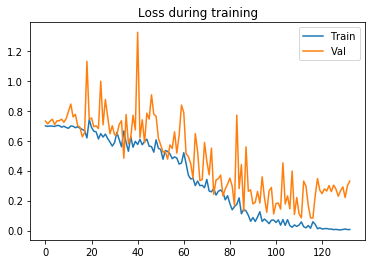

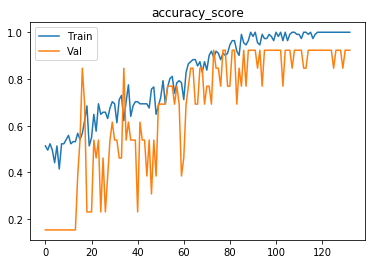

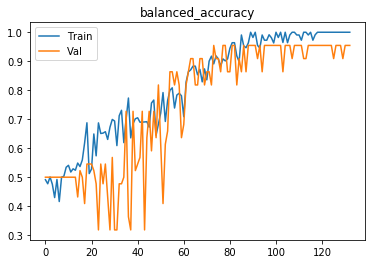

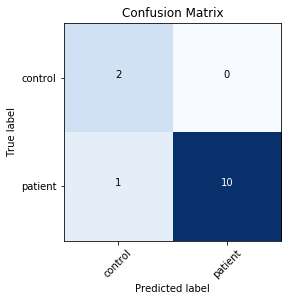

###### Starting inner fold 4
{'model': 'ModelA', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 468521
[0,     5] loss: 0.69666
[0,    10] loss: 0.69653
[0,    15] loss: 0.68537
Time elapsed: 0h:0m:1s
train accuracy_score: 45.95 %
train balanced_accuracy: 44.37 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 0.710364
[1,     5] loss: 0.68736
[1,    10] loss: 0.68777
[1,    15] loss: 0.70837
Time elapsed: 0h:0m:4s
train accuracy_score: 51.35 %
train balanced_accuracy: 49.14 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 0.748496
[2,     5] loss: 0.68610
[2,    10] loss: 0.67692
[2,    15] loss: 0.71128
Time elapsed: 0h:0m:6s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.00 %
val accuracy_score: 15.38 %
val balanced_accuracy: 50.00 %
Val loss: 0.721937
[3,     5] loss: 0.69032
[3,    10] loss: 0.68394
[3,    15] loss: 0.68342
Time elapsed: 0h:0m:9s
train accuracy_score: 53.15 %
train balanced_accuracy: 

val accuracy_score: 23.08 %
val balanced_accuracy: 54.55 %
Val loss: 0.868677
[34,     5] loss: 0.62674
[34,    10] loss: 0.48643
[34,    15] loss: 0.75843
Time elapsed: 0h:1m:22s
train accuracy_score: 64.86 %
train balanced_accuracy: 65.00 %
val accuracy_score: 53.85 %
val balanced_accuracy: 31.82 %
Val loss: 0.657843
[35,     5] loss: 0.64968
[35,    10] loss: 0.57075
[35,    15] loss: 0.55895
Time elapsed: 0h:1m:24s
train accuracy_score: 64.86 %
train balanced_accuracy: 64.51 %
val accuracy_score: 30.77 %
val balanced_accuracy: 59.09 %
Val loss: 0.855496
[36,     5] loss: 0.58638
[36,    10] loss: 0.55096
[36,    15] loss: 0.67439
Time elapsed: 0h:1m:27s
train accuracy_score: 62.16 %
train balanced_accuracy: 61.76 %
val accuracy_score: 53.85 %
val balanced_accuracy: 31.82 %
Val loss: 0.695480
[37,     5] loss: 0.67323
[37,    10] loss: 0.52917
[37,    15] loss: 0.57769
Time elapsed: 0h:1m:29s
train accuracy_score: 67.57 %
train balanced_accuracy: 67.75 %
val accuracy_score: 30.77 %


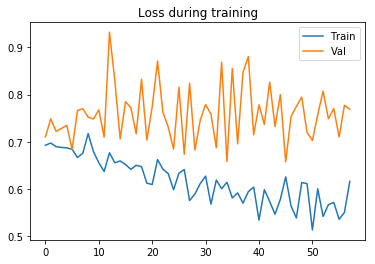

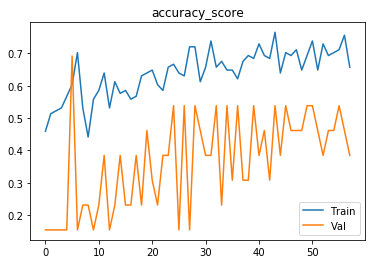

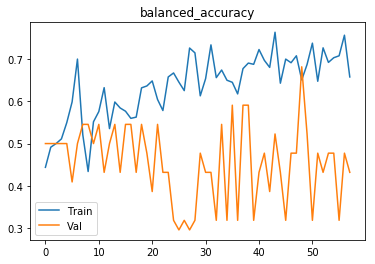

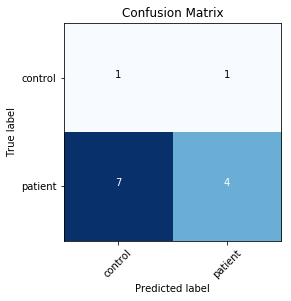

Finished outer fold.
{'final_acc': 0.9545454545454546, 'best_acc': 0.9545454545454546, 'final_iter': 75, 'best_iter': 75, 'params': {'model': 'ModelA', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 1}
###### Starting outer fold 7
111
13
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 468521
[0,     5] loss: 0.69476
[0,    10] loss: 0.71140
[0,    15] loss: 0.69689
[0,    20] loss: 0.69070
[0,    25] loss: 0.69281
Time elapsed: 0h:0m:2s
train accuracy_score: 47.75 %
train balanced_accuracy: 49.19 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.695219
[1,     5] loss: 0.68729
[1,    10] loss: 0.68672
[1,    15] loss: 0.69464
[1,    20] loss: 0.66779
[1,    25] loss: 0.73112
Time elapsed: 0h:0m:5s
train accuracy_score: 53.15 %
train balanced_accuracy: 51.27 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.700823
[2,     5] los

val accuracy_score: 53.85 %
val balanced_accuracy: 55.95 %
Val loss: 0.626741
[27,     5] loss: 0.62103
[27,    10] loss: 0.83821
[27,    15] loss: 0.64074
[27,    20] loss: 0.61732
[27,    25] loss: 0.62575
Time elapsed: 0h:1m:24s
train accuracy_score: 64.86 %
train balanced_accuracy: 65.32 %
val accuracy_score: 61.54 %
val balanced_accuracy: 63.10 %
Val loss: 0.624659
[28,     5] loss: 0.64713
[28,    10] loss: 0.65039
[28,    15] loss: 0.62690
[28,    20] loss: 0.49614
[28,    25] loss: 0.55338
Time elapsed: 0h:1m:27s
train accuracy_score: 67.57 %
train balanced_accuracy: 67.26 %
val accuracy_score: 61.54 %
val balanced_accuracy: 60.71 %
Val loss: 0.605481
[29,     5] loss: 0.63451
[29,    10] loss: 0.48445
[29,    15] loss: 0.49750
[29,    20] loss: 0.55976
[29,    25] loss: 0.84585
Time elapsed: 0h:1m:30s
train accuracy_score: 69.37 %
train balanced_accuracy: 69.14 %
val accuracy_score: 61.54 %
val balanced_accuracy: 60.71 %
Val loss: 0.593974
[30,     5] loss: 0.44445
[30,    10]

val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.620583
[55,     5] loss: 0.39368
[55,    10] loss: 0.64238
[55,    15] loss: 0.30095
[55,    20] loss: 0.39411
[55,    25] loss: 0.42288
Time elapsed: 0h:2m:49s
train accuracy_score: 76.58 %
train balanced_accuracy: 76.37 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.578446
[56,     5] loss: 0.52980
[56,    10] loss: 0.30667
[56,    15] loss: 0.48879
[56,    20] loss: 0.23607
[56,    25] loss: 0.54419
Time elapsed: 0h:2m:52s
train accuracy_score: 78.38 %
train balanced_accuracy: 78.09 %
val accuracy_score: 69.23 %
val balanced_accuracy: 66.67 %
Val loss: 0.610291
[57,     5] loss: 0.35480
[57,    10] loss: 0.28989
[57,    15] loss: 0.37266
[57,    20] loss: 0.44620
[57,    25] loss: 0.40411
Time elapsed: 0h:2m:55s
train accuracy_score: 80.18 %
train balanced_accuracy: 80.06 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.560014
[58,     5] loss: 0.28648
[58,    10]

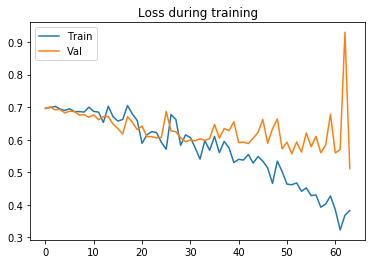

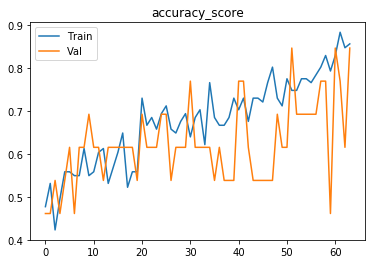

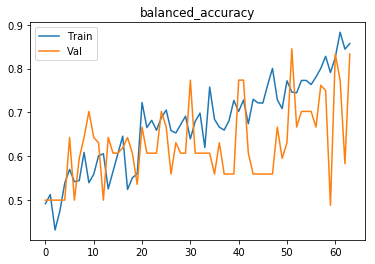

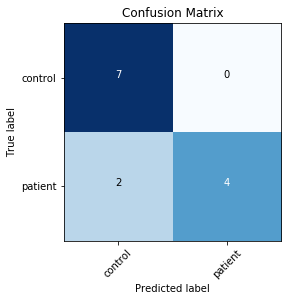

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 468521
[0,     5] loss: 0.70293
Time elapsed: 0h:0m:2s
train accuracy_score: 43.24 %
train balanced_accuracy: 43.66 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.695233
[1,     5] loss: 0.70742
Time elapsed: 0h:0m:4s
train accuracy_score: 51.35 %
train balanced_accuracy: 49.46 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691921
[2,     5] loss: 0.69790
Time elapsed: 0h:0m:7s
train accuracy_score: 49.55 %
train balanced_accuracy: 50.34 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690368
[3,     5] loss: 0.69942
Time elapsed: 0h:0m:9s
train accuracy_score: 50.45 %
train balanced_accuracy: 51.85 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691378
[4,     5] loss: 0.70557
Time elapsed: 0h:0m:12s
train accuracy_score: 51.35 %
train balanced_accuracy: 50.52 %


val accuracy_score: 53.85 %
val balanced_accuracy: 52.38 %
Val loss: 0.666388
[43,     5] loss: 0.66591
Time elapsed: 0h:1m:52s
train accuracy_score: 52.25 %
train balanced_accuracy: 53.09 %
val accuracy_score: 53.85 %
val balanced_accuracy: 52.38 %
Val loss: 0.663838
[44,     5] loss: 0.62752
Time elapsed: 0h:1m:55s
train accuracy_score: 66.67 %
train balanced_accuracy: 66.23 %
val accuracy_score: 61.54 %
val balanced_accuracy: 64.29 %
Val loss: 0.679748
[45,     5] loss: 0.67906
Time elapsed: 0h:1m:58s
train accuracy_score: 62.16 %
train balanced_accuracy: 62.09 %
val accuracy_score: 53.85 %
val balanced_accuracy: 52.38 %
Val loss: 0.666423
[46,     5] loss: 0.63239
Time elapsed: 0h:2m:0s
train accuracy_score: 62.16 %
train balanced_accuracy: 62.00 %
val accuracy_score: 46.15 %
val balanced_accuracy: 47.62 %
Val loss: 0.659714
[47,     5] loss: 0.69308
Time elapsed: 0h:2m:3s
train accuracy_score: 58.56 %
train balanced_accuracy: 57.74 %
val accuracy_score: 46.15 %
val balanced_accura

val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.596428
[86,     5] loss: 0.50367
Time elapsed: 0h:3m:44s
train accuracy_score: 76.58 %
train balanced_accuracy: 76.37 %
val accuracy_score: 61.54 %
val balanced_accuracy: 60.71 %
Val loss: 0.599487
[87,     5] loss: 0.50439
Time elapsed: 0h:3m:47s
train accuracy_score: 73.87 %
train balanced_accuracy: 73.86 %
val accuracy_score: 61.54 %
val balanced_accuracy: 60.71 %
Val loss: 0.589016
[88,     5] loss: 0.52908
Time elapsed: 0h:3m:49s
train accuracy_score: 71.17 %
train balanced_accuracy: 70.62 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.584084
[89,     5] loss: 0.49586
Time elapsed: 0h:3m:52s
train accuracy_score: 72.07 %
train balanced_accuracy: 72.30 %
val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.579384
[90,     5] loss: 0.50604
Time elapsed: 0h:3m:55s
train accuracy_score: 75.68 %
train balanced_accuracy: 75.10 %
val accuracy_score: 69.23 %
val balanced_accu

val accuracy_score: 69.23 %
val balanced_accuracy: 66.67 %
Val loss: 0.738683
[129,     5] loss: 0.31047
Time elapsed: 0h:5m:35s
train accuracy_score: 89.19 %
train balanced_accuracy: 89.33 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.523800
Early stopping in epoch 130
Total time elapsed: 0h:5m:36s
Writing model to disk...
Best result during training: 0.83. Saving model..
Finished inner fold.


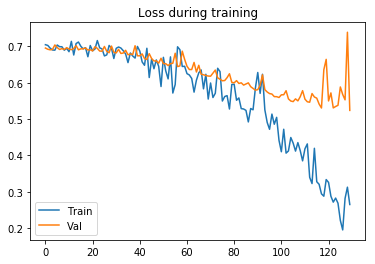

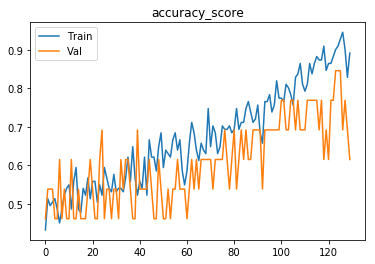

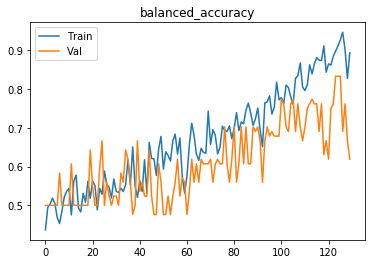

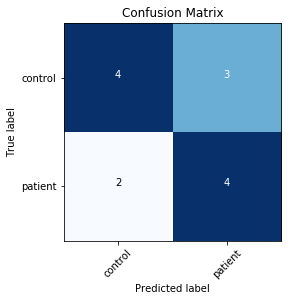

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 621961
[0,     5] loss: 0.70188
[0,    10] loss: 0.69410
[0,    15] loss: 0.69897
Time elapsed: 0h:0m:2s
train accuracy_score: 46.85 %
train balanced_accuracy: 46.29 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.693847
[1,     5] loss: 0.68783
[1,    10] loss: 0.67722
[1,    15] loss: 0.68725
Time elapsed: 0h:0m:6s
train accuracy_score: 54.05 %
train balanced_accuracy: 52.37 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.698918
[2,     5] loss: 0.67285
[2,    10] loss: 0.70113
[2,    15] loss: 0.72519
Time elapsed: 0h:0m:10s
train accuracy_score: 48.65 %
train balanced_accuracy: 46.63 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.696208
[3,     5] loss: 0.69098
[3,    10] loss: 0.72080
[3,    15] loss: 0.72600
Time elapsed: 0h:0m:13s
train accuracy_score: 42.34 %
train balanced_accuracy

val accuracy_score: 53.85 %
val balanced_accuracy: 54.76 %
Val loss: 0.655376
[34,     5] loss: 0.59709
[34,    10] loss: 0.60535
[34,    15] loss: 0.62587
Time elapsed: 0h:2m:6s
train accuracy_score: 66.67 %
train balanced_accuracy: 66.88 %
val accuracy_score: 61.54 %
val balanced_accuracy: 64.29 %
Val loss: 0.721927
[35,     5] loss: 0.60316
[35,    10] loss: 0.64237
[35,    15] loss: 0.60197
Time elapsed: 0h:2m:9s
train accuracy_score: 63.96 %
train balanced_accuracy: 63.73 %
val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.640581
[36,     5] loss: 0.58292
[36,    10] loss: 0.62226
[36,    15] loss: 0.63172
Time elapsed: 0h:2m:13s
train accuracy_score: 68.47 %
train balanced_accuracy: 67.79 %
val accuracy_score: 61.54 %
val balanced_accuracy: 60.71 %
Val loss: 0.640256
[37,     5] loss: 0.62242
[37,    10] loss: 0.58928
[37,    15] loss: 0.54634
Time elapsed: 0h:2m:16s
train accuracy_score: 67.57 %
train balanced_accuracy: 67.42 %
val accuracy_score: 61.54 %
va

Finished inner fold.


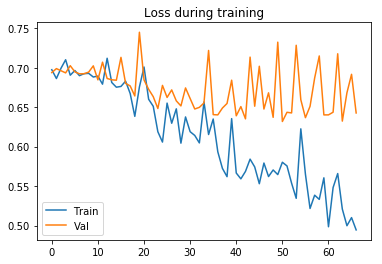

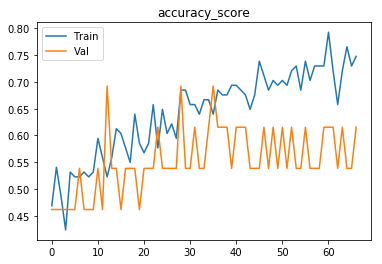

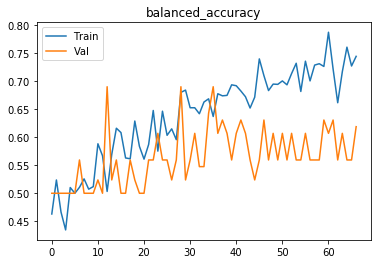

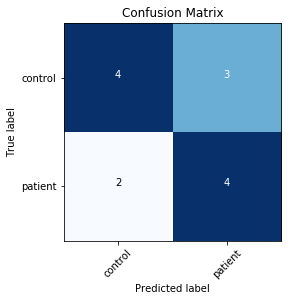

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 621961
[0,     5] loss: 0.69918
Time elapsed: 0h:0m:2s
train accuracy_score: 48.65 %
train balanced_accuracy: 46.55 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690978
[1,     5] loss: 0.70333
Time elapsed: 0h:0m:5s
train accuracy_score: 46.85 %
train balanced_accuracy: 47.92 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.693835
[2,     5] loss: 0.69163
Time elapsed: 0h:0m:9s
train accuracy_score: 51.35 %
train balanced_accuracy: 49.22 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.705332
[3,     5] loss: 0.69204
Time elapsed: 0h:0m:12s
train accuracy_score: 51.35 %
train balanced_accuracy: 49.46 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694499
[4,     5] loss: 0.69411
Time elapsed: 0h:0m:15s
train accuracy_score: 45.05 %
train balanced_accuracy: 46.03 %

val accuracy_score: 61.54 %
val balanced_accuracy: 60.71 %
Val loss: 0.614328
[43,     5] loss: 0.52814
Time elapsed: 0h:2m:23s
train accuracy_score: 69.37 %
train balanced_accuracy: 69.96 %
val accuracy_score: 61.54 %
val balanced_accuracy: 63.10 %
Val loss: 0.619276
[44,     5] loss: 0.60247
Time elapsed: 0h:2m:26s
train accuracy_score: 64.86 %
train balanced_accuracy: 64.35 %
val accuracy_score: 61.54 %
val balanced_accuracy: 63.10 %
Val loss: 0.624286
[45,     5] loss: 0.54321
Time elapsed: 0h:2m:29s
train accuracy_score: 76.58 %
train balanced_accuracy: 76.28 %
val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.611557
[46,     5] loss: 0.55922
Time elapsed: 0h:2m:32s
train accuracy_score: 72.07 %
train balanced_accuracy: 71.89 %
val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.615363
[47,     5] loss: 0.55925
Time elapsed: 0h:2m:36s
train accuracy_score: 64.86 %
train balanced_accuracy: 64.83 %
val accuracy_score: 61.54 %
val balanced_accu

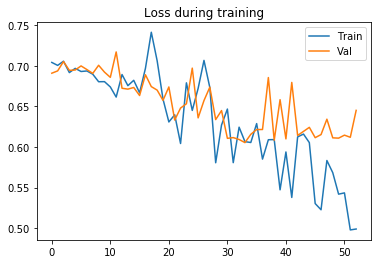

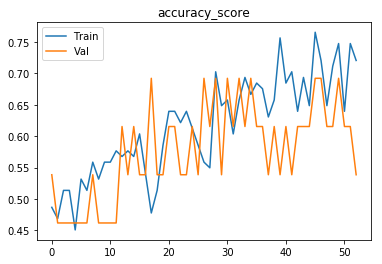

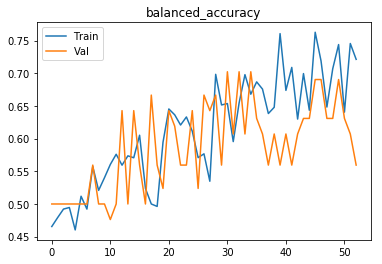

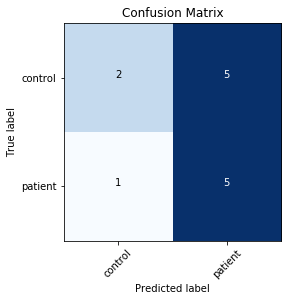

###### Starting inner fold 4
{'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 621961
[0,     5] loss: 0.69614
[0,    10] loss: 0.68678
[0,    15] loss: 0.71183
Time elapsed: 0h:0m:3s
train accuracy_score: 47.75 %
train balanced_accuracy: 45.93 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.693522
[1,     5] loss: 0.69084
[1,    10] loss: 0.69854
[1,    15] loss: 0.70389
Time elapsed: 0h:0m:6s
train accuracy_score: 43.24 %
train balanced_accuracy: 43.74 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691677
[2,     5] loss: 0.69525
[2,    10] loss: 0.68556
[2,    15] loss: 0.69568
Time elapsed: 0h:0m:10s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.98 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.699392
[3,     5] loss: 0.69678
[3,    10] loss: 0.70001
[3,    15] loss: 0.68590
Time elapsed: 0h:0m:13s
train accuracy_score: 52.25 %
train balanced_accuracy

val accuracy_score: 53.85 %
val balanced_accuracy: 55.95 %
Val loss: 0.634347
[34,     5] loss: 0.56303
[34,    10] loss: 0.69921
[34,    15] loss: 0.59541
Time elapsed: 0h:2m:4s
train accuracy_score: 67.57 %
train balanced_accuracy: 67.42 %
val accuracy_score: 69.23 %
val balanced_accuracy: 66.67 %
Val loss: 0.625441
[35,     5] loss: 0.61479
[35,    10] loss: 0.67450
[35,    15] loss: 0.58942
Time elapsed: 0h:2m:8s
train accuracy_score: 62.16 %
train balanced_accuracy: 62.00 %
val accuracy_score: 61.54 %
val balanced_accuracy: 60.71 %
Val loss: 0.611442
[36,     5] loss: 0.52215
[36,    10] loss: 0.70813
[36,    15] loss: 0.62330
Time elapsed: 0h:2m:11s
train accuracy_score: 63.96 %
train balanced_accuracy: 63.40 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.615265
[37,     5] loss: 0.60805
[37,    10] loss: 0.61637
[37,    15] loss: 0.67107
Time elapsed: 0h:2m:15s
train accuracy_score: 61.26 %
train balanced_accuracy: 62.04 %
val accuracy_score: 61.54 %
va

val accuracy_score: 61.54 %
val balanced_accuracy: 59.52 %
Val loss: 0.585416
[68,     5] loss: 0.48257
[68,    10] loss: 0.40700
[68,    15] loss: 0.45354
Time elapsed: 0h:4m:6s
train accuracy_score: 76.58 %
train balanced_accuracy: 76.45 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.571309
[69,     5] loss: 0.47423
[69,    10] loss: 0.35069
[69,    15] loss: 0.48665
Time elapsed: 0h:4m:10s
train accuracy_score: 85.59 %
train balanced_accuracy: 85.39 %
val accuracy_score: 69.23 %
val balanced_accuracy: 66.67 %
Val loss: 0.589012
[70,     5] loss: 0.48734
[70,    10] loss: 0.38438
[70,    15] loss: 0.47394
Time elapsed: 0h:4m:13s
train accuracy_score: 78.38 %
train balanced_accuracy: 78.09 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.551403
[71,     5] loss: 0.37785
[71,    10] loss: 0.22865
[71,    15] loss: 0.39246
Time elapsed: 0h:4m:17s
train accuracy_score: 88.29 %
train balanced_accuracy: 88.22 %
val accuracy_score: 76.92 %
v

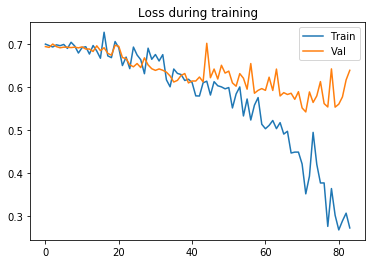

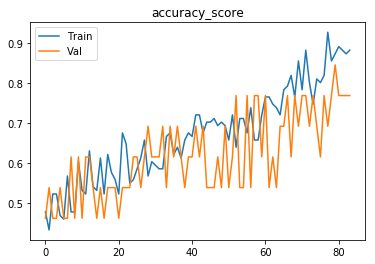

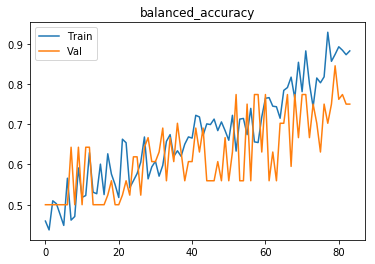

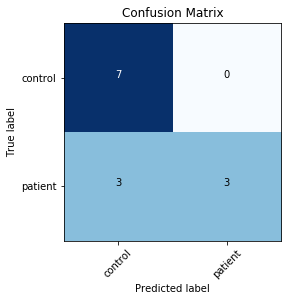

Finished outer fold.
{'final_acc': 0.8333333333333333, 'best_acc': 0.8452380952380951, 'final_iter': 64, 'best_iter': 52, 'params': {'model': 'ModelA', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 0}
###### Starting outer fold 8
111
13
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 468521
[0,     5] loss: 0.69526
Time elapsed: 0h:0m:1s
train accuracy_score: 45.95 %
train balanced_accuracy: 46.30 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.692680
[1,     5] loss: 0.68963
Time elapsed: 0h:0m:4s
train accuracy_score: 47.75 %
train balanced_accuracy: 47.82 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.693132
[2,     5] loss: 0.69966
Time elapsed: 0h:0m:6s
train accuracy_score: 48.65 %
train balanced_accuracy: 48.75 %
val accuracy_score: 46.15 %
val balanced_accuracy: 42.86 %
Val loss: 0.693102
[3,     5] loss: 0.70499

[41,     5] loss: 0.62999
Time elapsed: 0h:1m:43s
train accuracy_score: 66.67 %
train balanced_accuracy: 66.59 %
val accuracy_score: 61.54 %
val balanced_accuracy: 63.10 %
Val loss: 0.657830
[42,     5] loss: 0.63833
Time elapsed: 0h:1m:46s
train accuracy_score: 67.57 %
train balanced_accuracy: 67.40 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.86 %
Val loss: 0.628332
[43,     5] loss: 0.58597
Time elapsed: 0h:1m:48s
train accuracy_score: 70.27 %
train balanced_accuracy: 70.29 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.86 %
Val loss: 0.600589
[44,     5] loss: 0.58185
Time elapsed: 0h:1m:51s
train accuracy_score: 71.17 %
train balanced_accuracy: 71.07 %
val accuracy_score: 76.92 %
val balanced_accuracy: 75.00 %
Val loss: 0.598287
[45,     5] loss: 0.60532
Time elapsed: 0h:1m:53s
train accuracy_score: 68.47 %
train balanced_accuracy: 68.62 %
val accuracy_score: 61.54 %
val balanced_accuracy: 61.90 %
Val loss: 0.579870
[46,     5] loss: 0.54931
Time elapsed: 0h:1m

[84,     5] loss: 0.38116
Time elapsed: 0h:3m:31s
train accuracy_score: 78.38 %
train balanced_accuracy: 78.36 %
val accuracy_score: 76.92 %
val balanced_accuracy: 75.00 %
Val loss: 0.444294
[85,     5] loss: 0.40907
Time elapsed: 0h:3m:33s
train accuracy_score: 82.88 %
train balanced_accuracy: 83.02 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.439463
[86,     5] loss: 0.40616
Time elapsed: 0h:3m:36s
train accuracy_score: 82.88 %
train balanced_accuracy: 82.82 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.433718
[87,     5] loss: 0.35624
Time elapsed: 0h:3m:38s
train accuracy_score: 84.68 %
train balanced_accuracy: 84.69 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.404710
[88,     5] loss: 0.28126
Time elapsed: 0h:3m:41s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.39 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.400821
[89,     5] loss: 0.37446
Time elapsed: 0h:3m

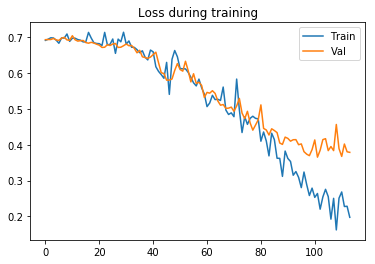

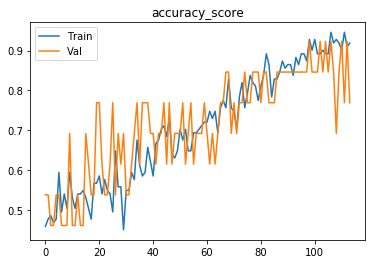

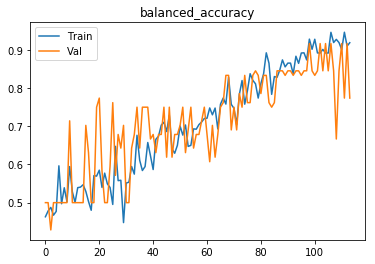

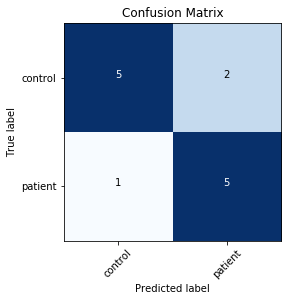

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 468521
[0,     5] loss: 0.69918
[0,    10] loss: 0.69257
[0,    15] loss: 0.69586
Time elapsed: 0h:0m:2s
train accuracy_score: 45.95 %
train balanced_accuracy: 46.09 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.692563
[1,     5] loss: 0.69242
[1,    10] loss: 0.69383
[1,    15] loss: 0.67977
Time elapsed: 0h:0m:4s
train accuracy_score: 49.55 %
train balanced_accuracy: 49.94 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691075
[2,     5] loss: 0.68552
[2,    10] loss: 0.67963
[2,    15] loss: 0.69839
Time elapsed: 0h:0m:7s
train accuracy_score: 53.15 %
train balanced_accuracy: 53.41 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690291
[3,     5] loss: 0.68384
[3,    10] loss: 0.70876
[3,    15] loss: 0.71487
Time elapsed: 0h:0m:10s
train accuracy_score: 45.05 %
train balanced_accuracy:

val accuracy_score: 61.54 %
val balanced_accuracy: 59.52 %
Val loss: 0.572321
[34,     5] loss: 0.48389
[34,    10] loss: 0.66809
[34,    15] loss: 0.66596
Time elapsed: 0h:1m:33s
train accuracy_score: 66.67 %
train balanced_accuracy: 66.69 %
val accuracy_score: 61.54 %
val balanced_accuracy: 59.52 %
Val loss: 0.568289
[35,     5] loss: 0.64091
[35,    10] loss: 0.65299
[35,    15] loss: 0.54621
Time elapsed: 0h:1m:36s
train accuracy_score: 67.57 %
train balanced_accuracy: 67.55 %
val accuracy_score: 61.54 %
val balanced_accuracy: 59.52 %
Val loss: 0.567089
[36,     5] loss: 0.49580
[36,    10] loss: 0.58840
[36,    15] loss: 0.59159
Time elapsed: 0h:1m:39s
train accuracy_score: 74.77 %
train balanced_accuracy: 74.76 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.552827
[37,     5] loss: 0.59228
[37,    10] loss: 0.67560
[37,    15] loss: 0.49276
Time elapsed: 0h:1m:42s
train accuracy_score: 63.96 %
train balanced_accuracy: 63.98 %
val accuracy_score: 61.54 %


val accuracy_score: 69.23 %
val balanced_accuracy: 67.86 %
Val loss: 0.507061
[68,     5] loss: 0.51346
[68,    10] loss: 0.58465
[68,    15] loss: 0.56474
Time elapsed: 0h:3m:5s
train accuracy_score: 73.87 %
train balanced_accuracy: 73.83 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.496130
[69,     5] loss: 0.50417
[69,    10] loss: 0.62241
[69,    15] loss: 0.48214
Time elapsed: 0h:3m:8s
train accuracy_score: 71.17 %
train balanced_accuracy: 71.09 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.86 %
Val loss: 0.494484
[70,     5] loss: 0.45950
[70,    10] loss: 0.48120
[70,    15] loss: 0.62231
Time elapsed: 0h:3m:10s
train accuracy_score: 75.68 %
train balanced_accuracy: 75.70 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.488762
[71,     5] loss: 0.47449
[71,    10] loss: 0.28664
[71,    15] loss: 0.55752
Time elapsed: 0h:3m:13s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.48 %
val accuracy_score: 76.92 %
va

val accuracy_score: 69.23 %
val balanced_accuracy: 66.67 %
Val loss: 0.552063
[102,     5] loss: 0.32380
[102,    10] loss: 0.38845
[102,    15] loss: 0.31732
Time elapsed: 0h:4m:37s
train accuracy_score: 82.88 %
train balanced_accuracy: 82.89 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.428046
Early stopping in epoch 103
Total time elapsed: 0h:4m:38s
Writing model to disk...
Best result during training: 0.85. Saving model..
Finished inner fold.


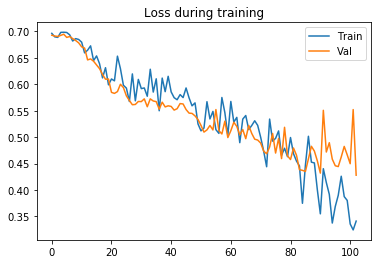

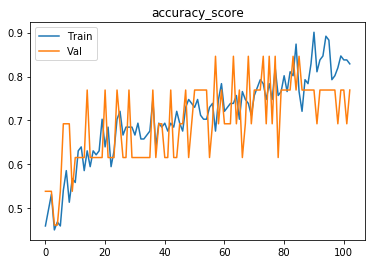

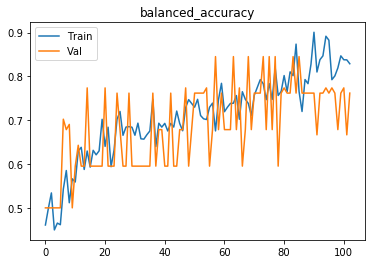

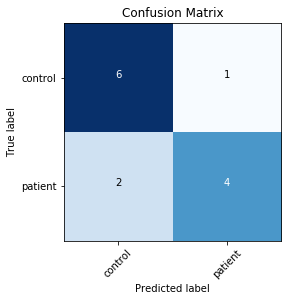

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 621961
[0,     5] loss: 0.69039
[0,    10] loss: 0.69319
[0,    15] loss: 0.70241
Time elapsed: 0h:0m:3s
train accuracy_score: 45.95 %
train balanced_accuracy: 46.14 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694713
[1,     5] loss: 0.70400
[1,    10] loss: 0.69073
[1,    15] loss: 0.69576
Time elapsed: 0h:0m:6s
train accuracy_score: 46.85 %
train balanced_accuracy: 47.01 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.692467
[2,     5] loss: 0.69581
[2,    10] loss: 0.68981
[2,    15] loss: 0.69362
Time elapsed: 0h:0m:10s
train accuracy_score: 53.15 %
train balanced_accuracy: 53.00 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.692623
[3,     5] loss: 0.69162
[3,    10] loss: 0.70991
[3,    15] loss: 0.69858
Time elapsed: 0h:0m:13s
train accuracy_score: 41.44 %
train balanced_accuracy

val accuracy_score: 76.92 %
val balanced_accuracy: 75.00 %
Val loss: 0.534410
[34,     5] loss: 0.56872
[34,    10] loss: 0.52673
[34,    15] loss: 0.64659
Time elapsed: 0h:2m:2s
train accuracy_score: 72.97 %
train balanced_accuracy: 72.97 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.520507
[35,     5] loss: 0.61784
[35,    10] loss: 0.61138
[35,    15] loss: 0.49820
Time elapsed: 0h:2m:6s
train accuracy_score: 74.77 %
train balanced_accuracy: 74.84 %
val accuracy_score: 84.62 %
val balanced_accuracy: 85.71 %
Val loss: 0.536583
[36,     5] loss: 0.51894
[36,    10] loss: 0.54982
[36,    15] loss: 0.67177
Time elapsed: 0h:2m:9s
train accuracy_score: 74.77 %
train balanced_accuracy: 74.74 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.503277
[37,     5] loss: 0.49766
[37,    10] loss: 0.68199
[37,    15] loss: 0.45944
Time elapsed: 0h:2m:13s
train accuracy_score: 73.87 %
train balanced_accuracy: 73.88 %
val accuracy_score: 84.62 %
val

val accuracy_score: 69.23 %
val balanced_accuracy: 66.67 %
Val loss: 0.513603
[68,     5] loss: 0.40028
[68,    10] loss: 0.59290
[68,    15] loss: 0.31824
Time elapsed: 0h:4m:2s
train accuracy_score: 83.78 %
train balanced_accuracy: 83.81 %
val accuracy_score: 69.23 %
val balanced_accuracy: 71.43 %
Val loss: 0.478098
[69,     5] loss: 0.42954
[69,    10] loss: 0.39625
[69,    15] loss: 0.35550
Time elapsed: 0h:4m:6s
train accuracy_score: 89.19 %
train balanced_accuracy: 89.20 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.451146
[70,     5] loss: 0.34542
[70,    10] loss: 0.38372
[70,    15] loss: 0.27729
Time elapsed: 0h:4m:9s
train accuracy_score: 83.78 %
train balanced_accuracy: 83.77 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.388121
[71,     5] loss: 0.35053
[71,    10] loss: 0.35604
[71,    15] loss: 0.37506
Time elapsed: 0h:4m:13s
train accuracy_score: 79.28 %
train balanced_accuracy: 79.25 %
val accuracy_score: 84.62 %
val

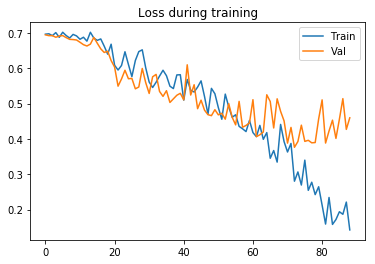

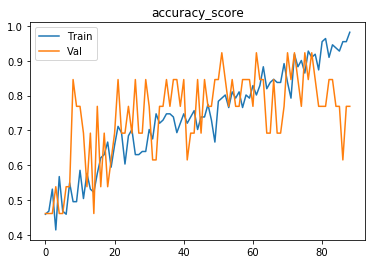

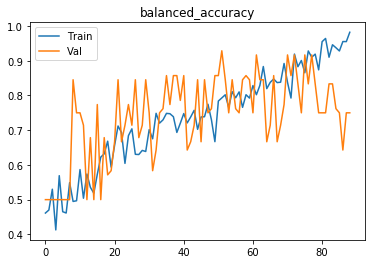

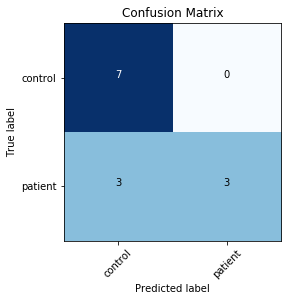

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 621961
[0,     5] loss: 0.69472
[0,    10] loss: 0.69075
[0,    15] loss: 0.69118
[0,    20] loss: 0.70358
[0,    25] loss: 0.70029
Time elapsed: 0h:0m:3s
train accuracy_score: 49.55 %
train balanced_accuracy: 49.87 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.693972
[1,     5] loss: 0.69710
[1,    10] loss: 0.71084
[1,    15] loss: 0.69525
[1,    20] loss: 0.69191
[1,    25] loss: 0.69109
Time elapsed: 0h:0m:7s
train accuracy_score: 50.45 %
train balanced_accuracy: 50.18 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.690686
[2,     5] loss: 0.69115
[2,    10] loss: 0.69311
[2,    15] loss: 0.68727
[2,    20] loss: 0.70718
[2,    25] loss: 0.71000
Time elapsed: 0h:0m:11s
train accuracy_score: 44.14 %
train balanced_accuracy: 44.27 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.691871
[3

val accuracy_score: 69.23 %
val balanced_accuracy: 66.67 %
Val loss: 0.581528
[28,     5] loss: 0.55501
[28,    10] loss: 0.52311
[28,    15] loss: 0.55466
[28,    20] loss: 0.51080
[28,    25] loss: 0.69837
Time elapsed: 0h:1m:53s
train accuracy_score: 73.87 %
train balanced_accuracy: 73.91 %
val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.519123
[29,     5] loss: 0.46544
[29,    10] loss: 0.55667
[29,    15] loss: 0.78409
[29,    20] loss: 0.42839
[29,    25] loss: 0.63217
Time elapsed: 0h:1m:57s
train accuracy_score: 69.37 %
train balanced_accuracy: 69.35 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.509488
[30,     5] loss: 0.54406
[30,    10] loss: 0.68915
[30,    15] loss: 0.51211
[30,    20] loss: 0.38619
[30,    25] loss: 0.41428
Time elapsed: 0h:2m:1s
train accuracy_score: 73.87 %
train balanced_accuracy: 73.91 %
val accuracy_score: 84.62 %
val balanced_accuracy: 85.71 %
Val loss: 0.489356
[31,     5] loss: 0.78883
[31,    10] 

val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.430328
[56,     5] loss: 0.36124
[56,    10] loss: 0.32177
[56,    15] loss: 0.34835
[56,    20] loss: 0.28190
[56,    25] loss: 0.31811
Time elapsed: 0h:3m:43s
train accuracy_score: 90.09 %
train balanced_accuracy: 90.11 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.394500
[57,     5] loss: 0.28105
[57,    10] loss: 0.39701
[57,    15] loss: 0.32203
[57,    20] loss: 0.23533
[57,    25] loss: 0.33229
Time elapsed: 0h:3m:47s
train accuracy_score: 88.29 %
train balanced_accuracy: 88.31 %
val accuracy_score: 92.31 %
val balanced_accuracy: 91.67 %
Val loss: 0.366981
[58,     5] loss: 0.32372
[58,    10] loss: 0.35538
[58,    15] loss: 0.13772
[58,    20] loss: 0.44622
[58,    25] loss: 0.19679
Time elapsed: 0h:3m:51s
train accuracy_score: 88.29 %
train balanced_accuracy: 88.28 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.399450
[59,     5] loss: 0.25704
[59,    10]

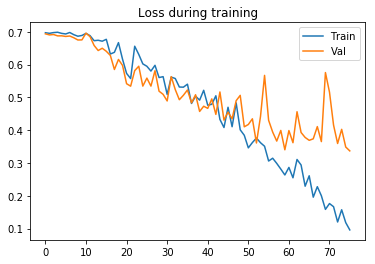

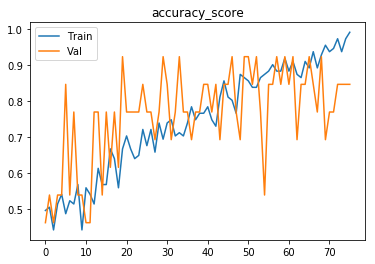

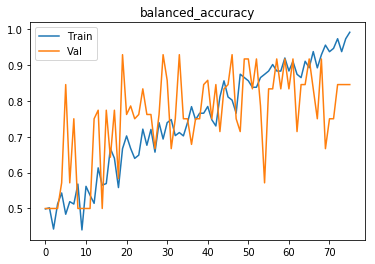

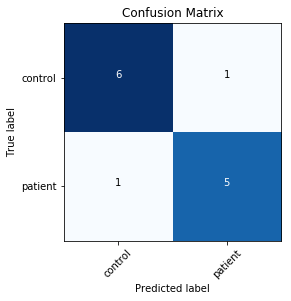

###### Starting inner fold 4
{'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 621961
[0,     5] loss: 0.69511
Time elapsed: 0h:0m:2s
train accuracy_score: 47.75 %
train balanced_accuracy: 48.04 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.692173
[1,     5] loss: 0.69368
Time elapsed: 0h:0m:5s
train accuracy_score: 48.65 %
train balanced_accuracy: 48.94 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.693094
[2,     5] loss: 0.69087
Time elapsed: 0h:0m:8s
train accuracy_score: 48.65 %
train balanced_accuracy: 48.90 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.691595
[3,     5] loss: 0.69172
Time elapsed: 0h:0m:12s
train accuracy_score: 51.35 %
train balanced_accuracy: 51.66 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.689604
[4,     5] loss: 0.70302
Time elapsed: 0h:0m:15s
train accuracy_score: 45.05 %
train balanced_accuracy: 45.26 %


val accuracy_score: 76.92 %
val balanced_accuracy: 76.19 %
Val loss: 0.520269
[43,     5] loss: 0.57136
Time elapsed: 0h:2m:19s
train accuracy_score: 72.07 %
train balanced_accuracy: 71.93 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.523433
[44,     5] loss: 0.53162
Time elapsed: 0h:2m:22s
train accuracy_score: 70.27 %
train balanced_accuracy: 70.36 %
val accuracy_score: 76.92 %
val balanced_accuracy: 75.00 %
Val loss: 0.533923
[45,     5] loss: 0.59821
Time elapsed: 0h:2m:25s
train accuracy_score: 70.27 %
train balanced_accuracy: 70.24 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.491780
[46,     5] loss: 0.61410
Time elapsed: 0h:2m:28s
train accuracy_score: 73.87 %
train balanced_accuracy: 73.88 %
val accuracy_score: 84.62 %
val balanced_accuracy: 84.52 %
Val loss: 0.492454
[47,     5] loss: 0.52170
Time elapsed: 0h:2m:31s
train accuracy_score: 71.17 %
train balanced_accuracy: 71.12 %
val accuracy_score: 76.92 %
val balanced_accu

val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.431956
[86,     5] loss: 0.40443
Time elapsed: 0h:4m:36s
train accuracy_score: 82.88 %
train balanced_accuracy: 82.82 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.33 %
Val loss: 0.417189
[87,     5] loss: 0.43723
Time elapsed: 0h:4m:39s
train accuracy_score: 81.98 %
train balanced_accuracy: 82.06 %
val accuracy_score: 92.31 %
val balanced_accuracy: 92.86 %
Val loss: 0.410674
[88,     5] loss: 0.39206
Time elapsed: 0h:4m:42s
train accuracy_score: 83.78 %
train balanced_accuracy: 83.72 %
val accuracy_score: 76.92 %
val balanced_accuracy: 75.00 %
Val loss: 0.442277
[89,     5] loss: 0.43040
Time elapsed: 0h:4m:45s
train accuracy_score: 84.68 %
train balanced_accuracy: 84.77 %
val accuracy_score: 76.92 %
val balanced_accuracy: 78.57 %
Val loss: 0.417975
[90,     5] loss: 0.43627
Time elapsed: 0h:4m:49s
train accuracy_score: 81.08 %
train balanced_accuracy: 81.04 %
val accuracy_score: 92.31 %
val balanced_accu

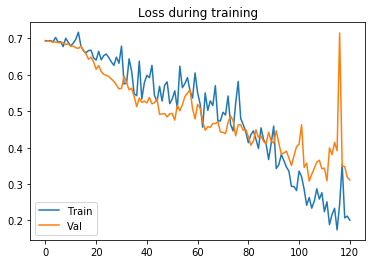

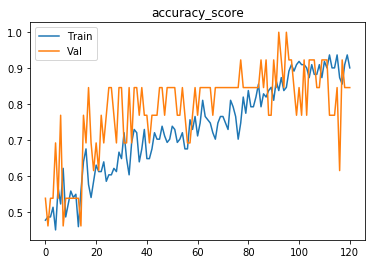

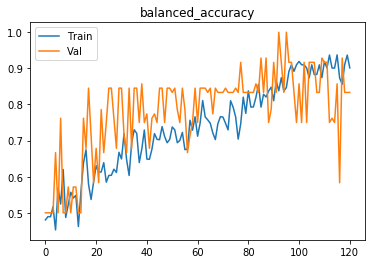

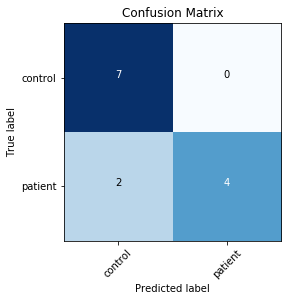

Finished outer fold.
{'final_acc': 0.8452380952380951, 'best_acc': 0.9285714285714286, 'final_iter': 76, 'best_iter': 47, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 3}
###### Starting outer fold 9
111
13
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelA', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 468521
[0,     5] loss: 0.69532
[0,    10] loss: 0.68959
[0,    15] loss: 0.70822
Time elapsed: 0h:0m:2s
train accuracy_score: 43.24 %
train balanced_accuracy: 41.95 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.689506
[1,     5] loss: 0.69721
[1,    10] loss: 0.66511
[1,    15] loss: 0.75283
Time elapsed: 0h:0m:4s
train accuracy_score: 50.45 %
train balanced_accuracy: 49.01 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.698696
[2,     5] loss: 0.69133
[2,    10] loss: 0.68820
[2,    15] loss: 0.70077
Time elapsed: 0h:0m:7s
train accuracy_sc

[32,    15] loss: 0.47282
Time elapsed: 0h:1m:29s
train accuracy_score: 78.38 %
train balanced_accuracy: 78.17 %
val accuracy_score: 61.54 %
val balanced_accuracy: 60.71 %
Val loss: 0.695364
[33,     5] loss: 0.49993
[33,    10] loss: 0.51629
[33,    15] loss: 0.58262
Time elapsed: 0h:1m:32s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.64 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.679960
[34,     5] loss: 0.53065
[34,    10] loss: 0.48104
[34,    15] loss: 0.35278
Time elapsed: 0h:1m:34s
train accuracy_score: 78.38 %
train balanced_accuracy: 78.42 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.690513
[35,     5] loss: 0.42216
[35,    10] loss: 0.53090
[35,    15] loss: 0.42656
Time elapsed: 0h:1m:37s
train accuracy_score: 80.18 %
train balanced_accuracy: 80.30 %
val accuracy_score: 69.23 %
val balanced_accuracy: 69.05 %
Val loss: 0.696380
[36,     5] loss: 0.51111
[36,    10] loss: 0.32934
[36,    15] loss: 0.45431
Ti

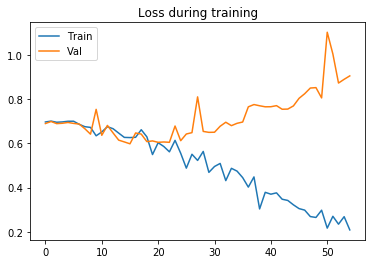

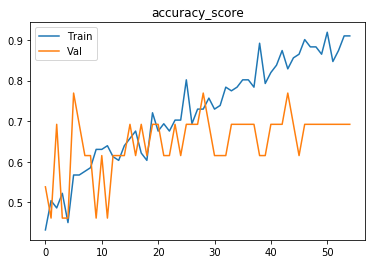

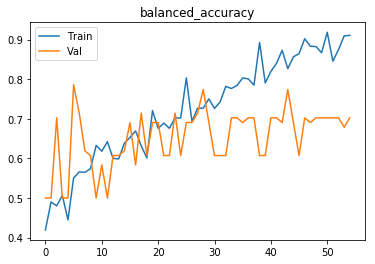

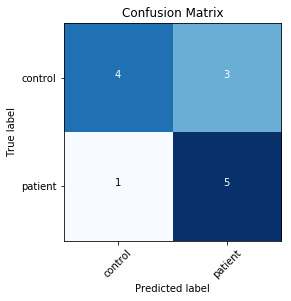

###### Starting inner fold 1
{'model': 'ModelA', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 468521
[0,     5] loss: 0.70811
[0,    10] loss: 0.69014
[0,    15] loss: 0.69854
[0,    20] loss: 0.71285
[0,    25] loss: 0.69923
Time elapsed: 0h:0m:2s
train accuracy_score: 45.95 %
train balanced_accuracy: 46.41 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.689275
[1,     5] loss: 0.71306
[1,    10] loss: 0.69171
[1,    15] loss: 0.68643
[1,    20] loss: 0.69023
[1,    25] loss: 0.70685
Time elapsed: 0h:0m:5s
train accuracy_score: 49.55 %
train balanced_accuracy: 49.93 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.700591
[2,     5] loss: 0.69109
[2,    10] loss: 0.71446
[2,    15] loss: 0.69869
[2,    20] loss: 0.70637
[2,    25] loss: 0.68219
Time elapsed: 0h:0m:8s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.24 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.699271
[3

val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.606708
[28,     5] loss: 0.62911
[28,    10] loss: 0.69502
[28,    15] loss: 0.44152
[28,    20] loss: 0.56218
[28,    25] loss: 0.58154
Time elapsed: 0h:1m:26s
train accuracy_score: 64.86 %
train balanced_accuracy: 64.43 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.86 %
Val loss: 0.614143
[29,     5] loss: 0.42460
[29,    10] loss: 0.72324
[29,    15] loss: 0.56647
[29,    20] loss: 0.52866
[29,    25] loss: 0.63727
Time elapsed: 0h:1m:29s
train accuracy_score: 70.27 %
train balanced_accuracy: 70.25 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.628329
[30,     5] loss: 0.48749
[30,    10] loss: 0.66318
[30,    15] loss: 0.65420
[30,    20] loss: 0.52217
[30,    25] loss: 0.45364
Time elapsed: 0h:1m:32s
train accuracy_score: 69.37 %
train balanced_accuracy: 69.47 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.642459
[31,     5] loss: 0.56959
[31,    10]

val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.749309
[56,     5] loss: 0.30410
[56,    10] loss: 0.24878
[56,    15] loss: 0.20255
[56,    20] loss: 0.21095
[56,    25] loss: 0.46095
Time elapsed: 0h:2m:50s
train accuracy_score: 90.09 %
train balanced_accuracy: 90.19 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.851032
[57,     5] loss: 0.21123
[57,    10] loss: 0.28024
[57,    15] loss: 0.14279
[57,    20] loss: 0.45969
[57,    25] loss: 0.20647
Time elapsed: 0h:2m:53s
train accuracy_score: 90.99 %
train balanced_accuracy: 91.05 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 1.014581
[58,     5] loss: 0.29800
[58,    10] loss: 0.14950
[58,    15] loss: 0.30331
[58,    20] loss: 0.25067
[58,    25] loss: 0.11744
Time elapsed: 0h:2m:56s
train accuracy_score: 90.99 %
train balanced_accuracy: 90.97 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.787695
[59,     5] loss: 0.36494
[59,    10]

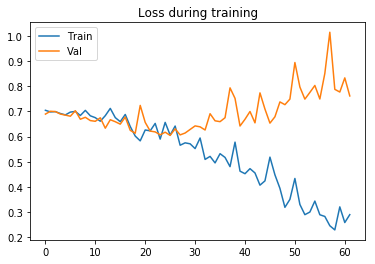

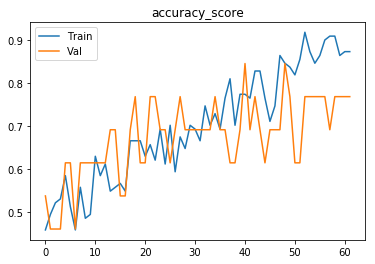

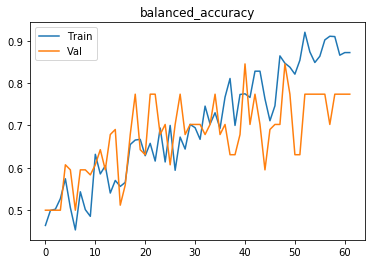

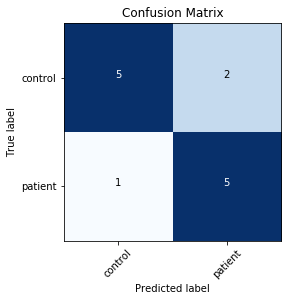

###### Starting inner fold 2
{'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 621961
[0,     5] loss: 0.69489
[0,    10] loss: 0.69650
[0,    15] loss: 0.69541
[0,    20] loss: 0.70126
[0,    25] loss: 0.69073
Time elapsed: 0h:0m:3s
train accuracy_score: 47.75 %
train balanced_accuracy: 47.89 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.698550
[1,     5] loss: 0.67159
[1,    10] loss: 0.71458
[1,    15] loss: 0.73165
[1,    20] loss: 0.69218
[1,    25] loss: 0.68305
Time elapsed: 0h:0m:7s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.49 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.689211
[2,     5] loss: 0.69421
[2,    10] loss: 0.70410
[2,    15] loss: 0.69684
[2,    20] loss: 0.70130
[2,    25] loss: 0.68706
Time elapsed: 0h:0m:11s
train accuracy_score: 49.55 %
train balanced_accuracy: 49.37 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.696879
[3

val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.695946
[28,     5] loss: 0.58339
[28,    10] loss: 0.59229
[28,    15] loss: 0.40547
[28,    20] loss: 0.44837
[28,    25] loss: 0.55775
Time elapsed: 0h:1m:54s
train accuracy_score: 73.87 %
train balanced_accuracy: 74.11 %
val accuracy_score: 61.54 %
val balanced_accuracy: 63.10 %
Val loss: 0.777362
[29,     5] loss: 0.44430
[29,    10] loss: 0.29581
[29,    15] loss: 0.45288
[29,    20] loss: 0.52464
[29,    25] loss: 0.56936
Time elapsed: 0h:1m:58s
train accuracy_score: 77.48 %
train balanced_accuracy: 77.31 %
val accuracy_score: 61.54 %
val balanced_accuracy: 60.71 %
Val loss: 0.692441
[30,     5] loss: 0.53520
[30,    10] loss: 0.59072
[30,    15] loss: 0.55526
[30,    20] loss: 0.43369
[30,    25] loss: 0.43585
Time elapsed: 0h:2m:2s
train accuracy_score: 76.58 %
train balanced_accuracy: 76.61 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.716210
[31,     5] loss: 0.38089
[31,    10] 

val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.909836
[56,     5] loss: 0.37304
[56,    10] loss: 0.29234
[56,    15] loss: 0.27701
[56,    20] loss: 0.35206
[56,    25] loss: 0.29752
Time elapsed: 0h:3m:45s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.44 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.951635
[57,     5] loss: 0.23977
[57,    10] loss: 0.28779
[57,    15] loss: 0.59123
[57,    20] loss: 0.34175
[57,    25] loss: 0.16769
Time elapsed: 0h:3m:49s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.20 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.927920
[58,     5] loss: 0.20314
[58,    10] loss: 0.38768
[58,    15] loss: 0.40624
[58,    20] loss: 0.24721
[58,    25] loss: 0.12115
Time elapsed: 0h:3m:53s
train accuracy_score: 86.49 %
train balanced_accuracy: 86.58 %
val accuracy_score: 69.23 %
val balanced_accuracy: 67.86 %
Val loss: 0.973582
[59,     5] loss: 0.31402
[59,    10]

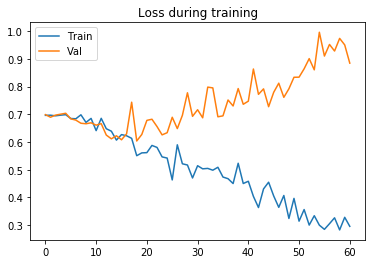

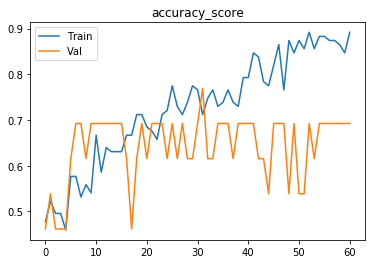

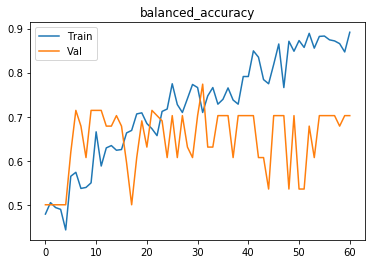

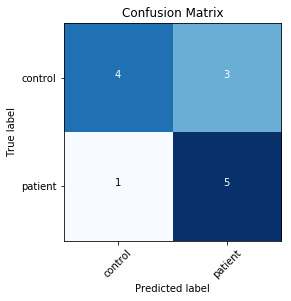

###### Starting inner fold 3
{'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 621961
[0,     5] loss: 0.69306
[0,    10] loss: 0.71665
[0,    15] loss: 0.70191
[0,    20] loss: 0.69608
[0,    25] loss: 0.69204
Time elapsed: 0h:0m:3s
train accuracy_score: 46.85 %
train balanced_accuracy: 47.51 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.695748
[1,     5] loss: 0.68744
[1,    10] loss: 0.68678
[1,    15] loss: 0.69260
[1,    20] loss: 0.71242
[1,    25] loss: 0.69523
Time elapsed: 0h:0m:7s
train accuracy_score: 53.15 %
train balanced_accuracy: 51.35 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694196
[2,     5] loss: 0.68917
[2,    10] loss: 0.67635
[2,    15] loss: 0.71109
[2,    20] loss: 0.67307
[2,    25] loss: 0.73788
Time elapsed: 0h:0m:11s
train accuracy_score: 52.25 %
train balanced_accuracy: 50.49 %
val accuracy_score: 46.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694090
[3

val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.599065
[28,     5] loss: 0.65089
[28,    10] loss: 0.57669
[28,    15] loss: 0.56018
[28,    20] loss: 0.63057
[28,    25] loss: 0.48536
Time elapsed: 0h:1m:54s
train accuracy_score: 66.67 %
train balanced_accuracy: 66.80 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.603538
[29,     5] loss: 0.52567
[29,    10] loss: 0.61626
[29,    15] loss: 0.49652
[29,    20] loss: 0.53240
[29,    25] loss: 0.58395
Time elapsed: 0h:1m:58s
train accuracy_score: 69.37 %
train balanced_accuracy: 69.14 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.654219
[30,     5] loss: 0.62917
[30,    10] loss: 0.38504
[30,    15] loss: 0.65290
[30,    20] loss: 0.51865
[30,    25] loss: 0.63131
Time elapsed: 0h:2m:2s
train accuracy_score: 63.96 %
train balanced_accuracy: 63.97 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.606705
[31,     5] loss: 0.57889
[31,    10] 

val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.721961
[56,     5] loss: 0.25699
[56,    10] loss: 0.31416
[56,    15] loss: 0.52271
[56,    20] loss: 0.22219
[56,    25] loss: 0.37528
Time elapsed: 0h:3m:46s
train accuracy_score: 85.59 %
train balanced_accuracy: 85.56 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.719234
[57,     5] loss: 0.26059
[57,    10] loss: 0.18220
[57,    15] loss: 0.31627
[57,    20] loss: 0.42626
[57,    25] loss: 0.28837
Time elapsed: 0h:3m:50s
train accuracy_score: 89.19 %
train balanced_accuracy: 89.09 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.718313
Early stopping in epoch 58
Total time elapsed: 0h:3m:50s
Writing model to disk...
Best result during training: 0.77. Saving model..
Finished inner fold.


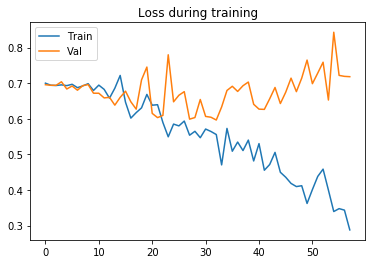

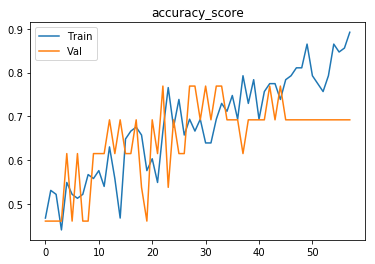

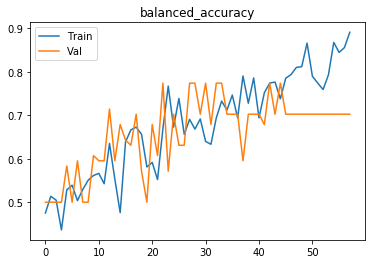

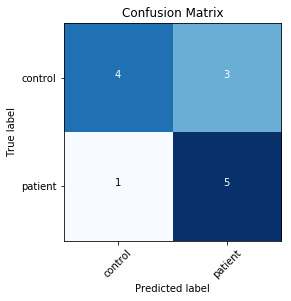

###### Starting inner fold 4
{'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 621961
[0,     5] loss: 0.69777
[0,    10] loss: 0.69619
[0,    15] loss: 0.68561
Time elapsed: 0h:0m:3s
train accuracy_score: 45.05 %
train balanced_accuracy: 46.68 %
val accuracy_score: 53.85 %
val balanced_accuracy: 50.00 %
Val loss: 0.692465
[1,     5] loss: 0.69311
[1,    10] loss: 0.69321
[1,    15] loss: 0.71159
Time elapsed: 0h:0m:6s
train accuracy_score: 45.05 %
train balanced_accuracy: 45.87 %
val accuracy_score: 61.54 %
val balanced_accuracy: 59.52 %
Val loss: 0.692015
[2,     5] loss: 0.69423
[2,    10] loss: 0.70371
[2,    15] loss: 0.69286
Time elapsed: 0h:0m:10s
train accuracy_score: 48.65 %
train balanced_accuracy: 49.32 %
val accuracy_score: 53.85 %
val balanced_accuracy: 51.19 %
Val loss: 0.690824
[3,     5] loss: 0.69089
[3,    10] loss: 0.69173
[3,    15] loss: 0.68487
Time elapsed: 0h:0m:13s
train accuracy_score: 55.86 %
train balanced_accuracy

val accuracy_score: 76.92 %
val balanced_accuracy: 77.38 %
Val loss: 0.613852
[34,     5] loss: 0.48868
[34,    10] loss: 0.55511
[34,    15] loss: 0.54270
Time elapsed: 0h:2m:4s
train accuracy_score: 70.27 %
train balanced_accuracy: 70.41 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.626717
[35,     5] loss: 0.52730
[35,    10] loss: 0.62868
[35,    15] loss: 0.45012
Time elapsed: 0h:2m:8s
train accuracy_score: 70.27 %
train balanced_accuracy: 70.25 %
val accuracy_score: 61.54 %
val balanced_accuracy: 63.10 %
Val loss: 0.701190
[36,     5] loss: 0.67477
[36,    10] loss: 0.63953
[36,    15] loss: 0.54504
Time elapsed: 0h:2m:12s
train accuracy_score: 66.67 %
train balanced_accuracy: 66.23 %
val accuracy_score: 69.23 %
val balanced_accuracy: 70.24 %
Val loss: 0.610630
[37,     5] loss: 0.51482
[37,    10] loss: 0.62286
[37,    15] loss: 0.50826
Time elapsed: 0h:2m:15s
train accuracy_score: 70.27 %
train balanced_accuracy: 69.84 %
val accuracy_score: 69.23 %
va

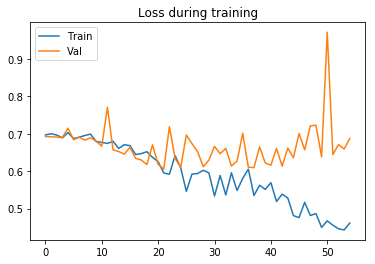

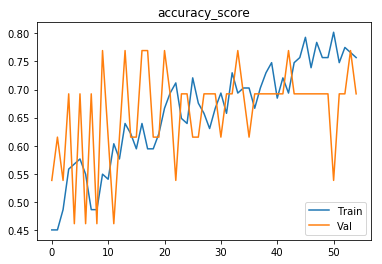

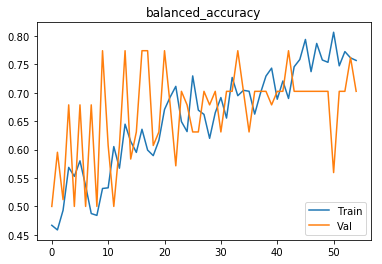

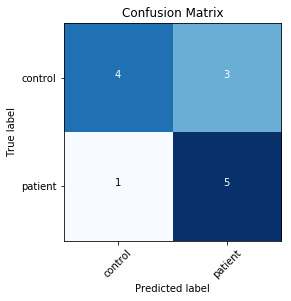

Finished outer fold.
{'final_acc': 0.7738095238095238, 'best_acc': 0.8452380952380951, 'final_iter': 62, 'best_iter': 49, 'params': {'model': 'ModelA', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 1}
################################
################################
All accuracies: [0.5357142857142857, 0.6190476190476191, 0.761904761904762, 0.6190476190476191, 0.6071428571428572, 0.675, 0.675, 0.8125, 0.675, 0.575, 0.7857142857142857, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 0.8571428571428572, 1.0, 0.9166666666666667, 1.0, 0.8452380952380951, 1.0, 0.8452380952380951, 0.5357142857142857, 0.8452380952380951, 0.6785714285714286, 0.7738095238095238, 0.6190476190476191, 0.6904761904761905, 0.6785714285714286, 0.5357142857142857, 0.6190476190476191, 0.6590909090909093, 0.9545454545454546, 0.8636363636363635, 0.9545454545454546, 0.43181818181818177, 0.8333333333333333, 0.6190476190476191, 0.6190476190476191, 0.5595238095238095, 0.75, 0.7738095238095238,

In [20]:
fold_metric, models = run(net=None, data=[X, y],
                  k_folds=-1,
                  callbacks=None,
                  augmentations=augmentations,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  b=None
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [21]:
5/0

ZeroDivisionError: division by zero

In [6]:
training_res = [{'final_acc': 0.761904761904762, 'best_acc': 0.761904761904762, 'final_iter': 65, 'best_iter': 33, 'params': {'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 2},
                {'final_acc': 0.8125, 'best_acc': 0.875, 'final_iter': 58, 'best_iter': 56, 'params': {'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 2},
                {'final_acc': 0.9285714285714286, 'best_acc': 1.0, 'final_iter': 128, 'best_iter': 100, 'params': {'model': 'ModelA', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 1},
                {'final_acc': 1.0, 'best_acc': 1.0, 'final_iter': 200, 'best_iter': 200, 'params': {'model': 'ModelA', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 0},
                {'final_acc': 0.8452380952380951, 'best_acc': 0.8452380952380951, 'final_iter': 115, 'best_iter': 115, 'params': {'model': 'ModelA', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 0},
                {'final_acc': 0.6190476190476191, 'best_acc': 0.7738095238095238, 'final_iter': 57, 'best_iter': 55, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 4},
                {'final_acc': 0.9545454545454546, 'best_acc': 0.9545454545454546, 'final_iter': 75, 'best_iter': 75, 'params': {'model': 'ModelA', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 1},
                {'final_acc': 0.8333333333333333, 'best_acc': 0.8452380952380951, 'final_iter': 64, 'best_iter': 52, 'params': {'model': 'ModelA', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 0},
                {'final_acc': 0.8452380952380951, 'best_acc': 0.9285714285714286, 'final_iter': 76, 'best_iter': 47, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 3},
                {'final_acc': 0.7738095238095238, 'best_acc': 0.8452380952380951, 'final_iter': 62, 'best_iter': 49, 'params': {'model': 'ModelA', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 1}
               ]

In [ ]:
"""training_res = [{'final_acc': 0.7023809523809523, 'best_acc': 0.7857142857142857, 'final_iter': 45, 'best_iter': 0, 'params': {'model': 'ModelA', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 4},
{'final_acc': 0.7750000000000001, 'best_acc': 0.8125, 'final_iter': 168, 'best_iter': 0, 'params': {'model': 'ModelA', 'batch_size': 12, 'patience': 12, 'lr': 1e-05}, 'inner_fold_idx': 0},
{'final_acc': 0.9285714285714286, 'best_acc': 1.0, 'final_iter': 111, 'best_iter': 0, 'params': {'model': 'ModelA', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 0},
{'final_acc': 1.0, 'best_acc': 1.0, 'final_iter': 135, 'best_iter': 0, 'params': {'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 3},
{'final_acc': 0.8452380952380951, 'best_acc': 0.8452380952380951, 'final_iter': 58, 'best_iter': 0, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 3},
{'final_acc': 0.6190476190476191, 'best_acc': 0.6904761904761905, 'final_iter': 200, 'best_iter': 0, 'params': {'model': 'ModelA', 'batch_size': 6, 'patience': 12, 'lr': 1e-05}, 'inner_fold_idx': 1},
{'final_acc': 0.9545454545454546, 'best_acc': 0.9545454545454546, 'final_iter': 81, 'best_iter': 0, 'params': {'model': 'ModelB', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 3},
{'final_acc': 0.8333333333333333, 'best_acc': 0.8333333333333333, 'final_iter': 58, 'best_iter': 0, 'params': {'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 4},
{'final_acc': 0.8452380952380951, 'best_acc': 0.9285714285714286, 'final_iter': 200, 'best_iter': 0, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 1e-05}, 'inner_fold_idx': 3},
{'final_acc': 0.7023809523809523, 'best_acc': 0.7738095238095238, 'final_iter': 50, 'best_iter': 0, 'params': {'model': 'ModelA', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 1}]"""

In [ ]:
"""training_res = [{'final_acc': 0.7023809523809523, 'best_acc': 0.7142857142857143, 'final_iter': 77, 'best_iter': 0, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 12, 'lr': 1e-05}, 'inner_fold_idx': 2},
{'final_acc': 0.7750000000000001, 'best_acc': 0.875, 'final_iter': 99, 'best_iter': 0, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 16, 'lr': 1e-05}, 'inner_fold_idx': 0},
{'final_acc': 0.9285714285714286, 'best_acc': 1.0, 'final_iter': 95, 'best_iter': 0, 'params': {'model': 'ModelB', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 1},
 {'final_acc': 1.0, 'best_acc': 1.0, 'final_iter': 110, 'best_iter': 0, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 2},
 {'final_acc': 0.761904761904762, 'best_acc': 0.8571428571428572, 'final_iter': 70, 'best_iter': 0, 'params': {'model': 'ModelA', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 1},
 {'final_acc': 0.6190476190476191, 'best_acc': 0.6904761904761905, 'final_iter': 200, 'best_iter': 0, 'params': {'model': 'ModelA', 'batch_size': 12, 'patience': 12, 'lr': 1e-05}, 'inner_fold_idx': 2},
 {'final_acc': 0.5909090909090909, 'best_acc': 0.7727272727272727, 'final_iter': 60, 'best_iter': 0, 'params': {'model': 'ModelB', 'batch_size': 4, 'patience': 12, 'lr': 1e-05}, 'inner_fold_idx': 3},
 {'final_acc': 0.75, 'best_acc': 0.8333333333333333, 'final_iter': 63, 'best_iter': 0, 'params': {'model': 'ModelB', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 0},
 {'final_acc': 0.7738095238095238, 'best_acc': 0.9166666666666667, 'final_iter': 78, 'best_iter': 0, 'params': {'model': 'ModelA', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 2},
 {'final_acc': 0.7023809523809523, 'best_acc': 0.7738095238095238, 'final_iter': 53, 'best_iter': 0, 'params': {'model': 'ModelB', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 0}]"""

In [7]:
len(training_res)

10

In [8]:
res_df = pd.DataFrame(training_res)

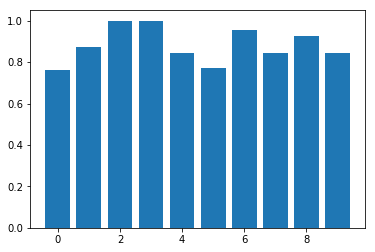

0.8829545454545455
0.8374188311688311


In [9]:
plt.bar(np.arange(len(res_df["best_acc"])), res_df["best_acc"])
plt.show()
print(np.mean(res_df["best_acc"]))
print(np.mean(res_df["final_acc"]))

In [10]:
print(np.mean(res_df["final_iter"]))

90.0


In [11]:
print(res_df["final_iter"])

0     65
1     58
2    128
3    200
4    115
5     57
6     75
7     64
8     76
9     62
Name: final_iter, dtype: int64


# Start inference

### Using best model checkpoint for inference

In [28]:
from collections import OrderedDict

In [30]:
metrics = []

random_states = np.arange(20, 30) # important to use the same values as during training

for outer_fold, r in enumerate(random_states):
    print("Outer fold {}".format(outer_fold))

    all_scores = []
    all_preds = []
    all_labels = []
    
    train_res = training_res[outer_fold]
    model_dir = os.path.join(output_dir,"outer_{}_inner_{}_cv_fold_{}_BEST_ITERATION.h5".format(outer_fold, train_res["inner_fold_idx"], outer_fold * 5 + train_res["inner_fold_idx"]))
    model_name = train_res["params"]["model"]
    net = pick_model(model_name)
    state_dict = torch.load(model_dir, map_location='cpu')
    new_state_dict = OrderedDict()
    for param in state_dict.items():
        new_state_dict.update([(param[0].replace("module.", ""), param[1])])
        
    net.load_state_dict(new_state_dict)
    net = net.cuda(gpu)
    net.eval()
    
    
    # load data
    # separate new test set each run
    _, X_test, _, y_test = train_test_split(X, y, test_size=0.15, random_state=r)
    if zero_one_normalize:
        intensity = IntensityRescale()
        ms_data_test = MSDataset(X_test, y_test, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
    else:
        ms_data_test = MSDataset(X_test, y_test, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)
        
    test_loader = DataLoader(
            ms_data_test, batch_size=1, num_workers=1, shuffle=False
)
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]
            img = img.to(torch.device("cuda:" + str(gpu)))
            
            output = net.forward(img)
            score = torch.sigmoid(output)
            pred = score >= 0.5
            
            all_scores.append(score.cpu().numpy().item())
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    roc_score = roc_auc_score(all_labels, all_scores)
    sens = sensitivity(all_labels, all_preds)
    spec = specificity(all_labels, all_preds)
    print("Bal. accuracy {:.3f} %".format(balanced_acc*100))
    print("ROC AUC Score {:.3f} %".format(roc_score*100))
    print("Sensitivity {:.3f} %".format(sens*100))
    print("Specificity {:.3f} %".format(spec*100))
    metrics.append([balanced_acc, roc_score, sens, spec])
# reset network to training mode6
net.train()
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics, columns=["Bal Acc", "ROC AUC", "Sensitivity", "Specificity"])
print(metrics_df)
print("Balanced accuracy mean {:.3f} % ({:.2f})".format(np.mean(metrics_df["Bal Acc"])*100, np.std(metrics_df["Bal Acc"])*100))
print("ROC AUC mean {:.3f} % ({:.2f})".format(np.mean(metrics_df["ROC AUC"])*100, np.std(metrics_df["ROC AUC"])*100))
print("Sensitivity mean {:.3f} % ({:.2f})".format(np.mean(metrics_df["Sensitivity"])*100, np.std(metrics_df["Sensitivity"])*100))
print("Specificity mean {:.3f} % ({:.2f})".format(np.mean(metrics_df["Specificity"])*100, np.std(metrics_df["Specificity"])*100))

Outer fold 0
Bal. accuracy 82.197 %
ROC AUC Score 80.303 %
Sensitivity 91.667 %
Specificity 72.727 %
Outer fold 1
Bal. accuracy 65.079 %
ROC AUC Score 72.222 %
Sensitivity 44.444 %
Specificity 85.714 %
Outer fold 2
Bal. accuracy 72.308 %
ROC AUC Score 86.923 %
Sensitivity 84.615 %
Specificity 60.000 %
Outer fold 3
Bal. accuracy 85.714 %
ROC AUC Score 88.095 %
Sensitivity 71.429 %
Specificity 100.000 %
Outer fold 4
Bal. accuracy 96.429 %
ROC AUC Score 96.825 %
Sensitivity 100.000 %
Specificity 92.857 %
Outer fold 5
Bal. accuracy 88.889 %
ROC AUC Score 96.032 %
Sensitivity 77.778 %
Specificity 100.000 %
Outer fold 6
Bal. accuracy 86.742 %
ROC AUC Score 98.485 %
Sensitivity 91.667 %
Specificity 81.818 %
Outer fold 7
Bal. accuracy 86.742 %
ROC AUC Score 92.424 %
Sensitivity 91.667 %
Specificity 81.818 %
Outer fold 8
Bal. accuracy 70.635 %
ROC AUC Score 84.127 %
Sensitivity 85.714 %
Specificity 55.556 %
Outer fold 9
Bal. accuracy 70.076 %
ROC AUC Score 78.030 %
Sensitivity 58.333 %
Specific